In [2]:
!pip install -U gdown

#### Reading in the merged file


In [3]:
import gdown

# ~~~ FILE LOCATIONS ~~~

file_id = '1AuMqjccgg354xLRmayryTjnIBTYHMDjV'             # 01_road_accidents_france_2019_2023_cleaning.csv
url = f'https://drive.google.com/uc?id={file_id}'

# ~~~ DOWNLOAD FILE ~~~

gdown.download(url, '01_road_accidents_france_2019_2023_cleaning.csv', quiet=False)

# ~~~ READ CVS FILE ~~~

import pandas as pd

# Full data
data = pd.read_csv('01_road_accidents_france_2019_2023_cleaning.csv', sep=';',
                   dtype={"num_traffic_lane": "string",
                          "age": "Int64"
                          },
                   parse_dates=["date", "datetime"])

# Reconvert "age_bucket" and "weekday" to dtype category
data["age_bucket"] = data["age_bucket"].astype("category")
data["weekday"] = data["weekday"].astype("category")
data['num_vehicle'] = data['num_vehicle'].astype("category")

# Convert "year_of_birth" to int64
data["year_of_birth"] = data["year_of_birth"].fillna(-1).astype('int64')

Downloading...
From (original): https://drive.google.com/uc?id=1AuMqjccgg354xLRmayryTjnIBTYHMDjV
From (redirected): https://drive.google.com/uc?id=1AuMqjccgg354xLRmayryTjnIBTYHMDjV&confirm=t&uuid=58ed537a-2595-4273-a6cb-9c52dd4fba28
To: /content/01_road_accidents_france_2019_2023_cleaning.csv
100%|██████████| 122M/122M [00:02<00:00, 57.4MB/s]
/tmp/ipython-input-219917365.py:17: DtypeWarning: Columns (31,33,34,35,36,37,38) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('01_road_accidents_france_2019_2023_cleaning.csv', sep=';',


#### Overview of the dataset

In [4]:
# Overview Full data
display(data['year_of_birth'].unique())

# Data types and missing values
display(data.info())

array([2002, 1993, 1959, 1994, 1996, 1930, 1995, 1966, 1968, 1978, 1984,
       1997, 1998, 1999, 1936, 1991, 1985, 1953, 2000, 1967, 1969, 1970,
       1963, 1988, 1990, 1992, 1975, 1971, 1946, 1980, 2015, 1981, 1989,
       1976, 1974, 1983, 1973, 2008, 1982, 1962, 1979, 2001, 2003, 1928,
       1987, 2004, 2006, 1958, 1986, 1952, 1964, 1977, 1955, 1944, 1965,
       1951, 1960, 1932, 2010, 1948, 1961, 1972, 1941, 1954, 1943, 1957,
       1949, 1940, 1937, 2011, 2013, 2016, 1931, 1926, 2005, 1942, 1939,
       1933, 1934, 2007, 1924, 2014, 2018, 2017, 2012, 1945, 1938, 1956,
       1929, 2009, 1947, 1950, 1935, 2019, 1927, 1900, 1920, 1925, 1901,
       1923, 1922, 1919, 1921, 1911, 2020, 1910,   -1, 2021, 1912, 2022,
       1913, 2023, 1917])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 619807 entries, 0 to 619806
Data columns (total 46 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   num_accident       619807 non-null  int64         
 1   id_vehicle         619807 non-null  int64         
 2   num_vehicle        619807 non-null  category      
 3   category_user      619807 non-null  int64         
 4   injury_severity    619807 non-null  int64         
 5   gender             619807 non-null  int64         
 6   year_of_birth      619807 non-null  int64         
 7   trip_purpose       619807 non-null  int64         
 8   safety_equipment1  619807 non-null  int64         
 9   safety_equipment2  619807 non-null  int64         
 10  safety_equipment3  619807 non-null  int64         
 11  category_vehicle   619807 non-null  int64         
 12  fixed_obs_hit      619807 non-null  int64         
 13  mobile_obs_hit     619807 non-null  int64   

None

#### Importing necessary packages

In [5]:
# package import

#import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency, fisher_exact, norm, chisquare
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep, proportion_confint
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from matplotlib.lines import Line2D
import itertools
import matplotlib.patches as mpatches
from matplotlib.colors import TwoSlopeNorm
import geopandas as gpd


#### Setting a theme for the visualizations

In [6]:
# Set Seaborn theme and font sizes

sns.set_theme(context="talk", style="whitegrid", font_scale=1.0)
plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "legend.fontsize": 11,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "figure.autolayout": True,
})

# Colors for the 3 parts
color_other = "#FFD700"  # Gold
color_killed = "crimson"
color_hosp = "darkorange"

#### Statistical analysis notes

Cramér’s V: ~0.1 small, ~0.3 medium, ~0.5 large (rough guide). Report bias-corrected V.

Logistic regression Odds-ratios (ORs): For each category (month, hour, weekday, year, age-group), OR > 1 means higher odds of severity than the baseline month, hour, weekday, year, age-group group; OR < 1 means lower odds. The 95% CI and p-value tell us which differences are statistically reliable.

Why this is better for very large n:

P-values alone will be tiny with 600k+ records.

Cramér’s V conveys how strong the month, hour, weekday, year, age-group–severity relationship is overall.

Odds ratios tell us which month, hour, weekday, year, age-group groups drive the difference and by how much, which is actionable and interpretable.

##### Cramér’s V

What it is: A number between 0 and 1 that tells us how strongly two categories are related (e.g., weekday × severity).

When to use it: After a chi-square test on a contingency table (rows × columns). Chi-square tells us “is there any association?”; Cramér’s V tells us how big that association is.

How to read it (rough guide):

0.00–0.10 ≈ very weak/small

~0.30 ≈ moderate

~0.50+ ≈ strong
(Exact cutoffs depend on context, but this works for quick interpretation.)

Why it’s helpful: With huge datasets, p-values are almost always “significant.” Cramér’s V avoids that trap by summarizing practical strength, not just “different.”

Example: Month × Severity gives V = 0.018 → very weak; Hour × Severity V = 0.047 → still weak but larger; Age × Severity V = 0.094 → small but clearly stronger than month/hour.

##### Logistic Regression

What it is: A way to model the chance of a yes/no outcome (e.g., “severe” or “Non-severe”) using one or more predictors (month, hour, age, year…).

What you get: For each predictor, you get an odds ratio (OR).

OR = 1.00 → same odds as baseline.

OR = 1.30 → 30% higher odds than baseline.

OR = 0.80 → 20% lower odds than baseline.

How to read it: Pick a baseline category (e.g., January). Each other category’s OR compares to that baseline. You also get 95% confidence intervals and p-values.

Why it’s powerful:

Handles multiple predictors at once (e.g., severity ~ month + year + age).

Answers “which categories are higher/lower, and by how much?” not just “is anything different?”

Caution: ORs are about association, not automatic causation. With huge data, focus on effect size (OR and its CI), not only the p-value.

Example: If August has OR = 1.31 vs January, then the odds of a severe accident are 31% higher in August (controlling for whatever else was included).

### 1. Temporal Analysis

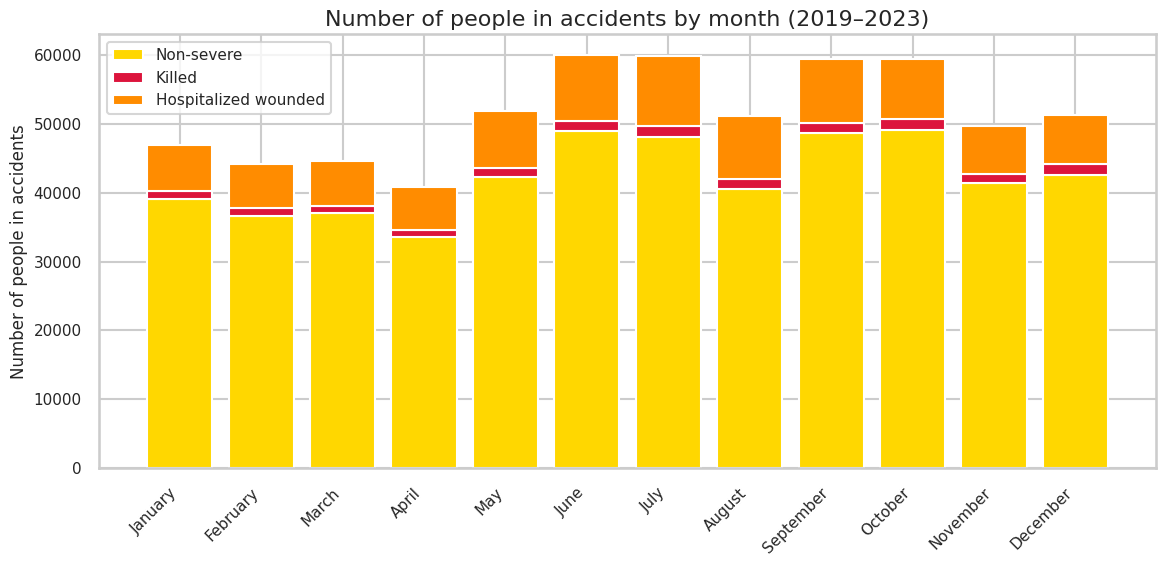

In [7]:
# Chart 1: Stacked bar by MONTH

# Group to get counts for each injury_severity at each month
# Count rows (people) per month × severity
g_month = (
    data.dropna(subset=["month"])
      .groupby(["month", "injury_severity"], observed = True)
      .size()                     # count people, not sum IDs; If number of unique accidents (events) instead, replace .size() with ["num_accident"].nunique() in this line.
      .unstack(fill_value = 0)    # unstack pivots the second group key (injury_severity) into columns, keeping month as the index (rows).
                                  # Result: a DataFrame where: rows = months, columns = severity codes (e.g., -1, 1, 2, 3, 4), and the cells are the counts.
)                                 # fill_value = 0: if a particular (age, severity) combo didn’t occur, fill with 0 instead of NaN.

# Build the three series (Other = total - killed - hosp)
# Directly select columns 2 and 3 (from g_month; no missing values)
# Pick the “Killed” (2) and “Hospitalized wounded” (3) columns from g_month. These are pandas Series indexed by month.
killed_m = g_month[2]
hosp_m   = g_month[3]

# Compute "other" as total minus killed/hosp
total_m = g_month.sum(axis = 1) # sums across columns for each row (month), i.e., total people in that month (all severities). axis = 1 means “sum across columns”.
other_m = total_m - killed_m - hosp_m # everything not killed/hospitalized (i.e., severity codes -1, 1, 4).

# Order months 1 through 12
month_order = list(range(1, 13))
other_m = other_m.reindex(month_order, fill_value = 0)
killed_m = killed_m.reindex(month_order, fill_value = 0)
hosp_m   = hosp_m.reindex(month_order, fill_value = 0)

# Plot
# Seaborn (sns.barplot) does not support stacked bars.
# So use Seaborn for theme + palettes, and draw the stack with Matplotlib’s ax.bar(..., bottom =...)
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(other_m.index, other_m.values, label = "Non-severe", color = color_other) # ax.bar(x, height, ...) draws vertical bars. x = other_m.index: x positions/categories (here, months 1–12). height = other_m.values: bar heights (a NumPy array of counts).
ax.bar(killed_m.index, killed_m.values, bottom = other_m.values, label = "Killed", color = color_killed) # same idea as the line above, but we stack it: bottom = other_m.values: shifts each “Killed” bar up so it starts where “Other” ends.
# That’s how stacking works in Matplotlib — each higher layer’s bottom is the cumulative height below it.
ax.bar(hosp_m.index, hosp_m.values, bottom =(other_m + killed_m).values, label = "Hospitalized wounded", color = color_hosp) # bottom = (other_m + killed_m).values: start this segment at the sum of the first two layers, so it sits on top of them.
# Customize x-axis with month names
month_names = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
ax.set_xticks(month_order)
ax.set_xticklabels(month_names, rotation=45, ha="right")
#ax.set_xlabel("Month")
ax.set_ylabel("Number of people in accidents")
ax.set_title("Number of people in accidents by month (2019–2023)")
ax.legend()

plt.tight_layout()  # make sure labels fit nicely
plt.show()



#### Accidents by Month (2019–2023)

##### Description
The stacked bar chart shows the monthly distribution of people involved in accidents by injury severity. Most people were unscathed or slightly injured (Non-severe), while a smaller proportion were either killed or hospitalized.  Peaks are visible in June, July, September, and October.

##### Explanation
These peaks correspond to summer and early autumn months, which are typically associated with increased travel volume due to holidays and tourism, leading to more road traffic and accidents. Conversely, February and April show notably fewer severe cases, likely linked to shorter months and less road travel.

##### Seasonal Patterns in Accident Severity

We tested whether the likelihood of an accident being severe (hospitalization or fatality) varies by month of the year, controlling for differences across years (2019–2023).

Method: Logistic regression with outcome = severe accident (yes/no), predictors = month (categorical, baseline = January) and year (categorical, baseline = 2019).

Rationale: A simple chi-square test was not informative given the very large dataset (>600,000 records), which makes even trivial differences statistically significant. Logistic regression instead quantifies how large the seasonal differences are (in odds ratios).


1. Global association

Cramér’s V = 0.018
Indicates a very weak overall relationship between month and severity.

Even though seasonality exists, month explains only a tiny portion of the variation in how severe accidents are.

2. Logistic regression results

We modeled:

Severe Accident (yes/no)
∼
Month (categorical)
Severe Accident (yes/no)∼Month (categorical)

Baseline = January.

Key coefficients (converted to odds ratios, OR):

February (OR = 1.03)
→ No difference from January.

March (OR = 1.01)
→ No difference.

April (OR = 1.09)
→ 9% higher odds of severe accident vs January.

May (OR = 1.13)
→ 13% higher odds.

June (OR = 1.12)
→ 12% higher odds.

July (OR = 1.22)
→ 22% higher odds — clear seasonal peak.

August (OR = 1.31)
→ 31% higher odds — the strongest month for severity.

September (OR = 1.09)
→ 9% higher odds.

October (OR = 1.03)
→ No difference.

November (OR = 0.99)
→ No difference.

December (OR = 1.00)
→ No difference.


3. Interpretation

Seasonal signal exists, but is small overall (Cramér’s V = 0.018).
This means that even though chi-square shows “significance,” the effect size is tiny at the global level.

Where the differences are real:

April–September consistently show higher odds of severe accidents compared to January.

July (+22%) and August (+31%) are the strongest seasonal peaks.

These increases are statistically significant and practically meaningful, given the size of the dataset.

Winter months (Feb, Mar, Nov, Dec) are essentially flat → severity rates are no different from January.

4. Conclusion

Accident severity shows a seasonal increase during spring and summer months, peaking in July (+22%) and August (+31%), compared to January. However, the overall association between month and severity is weak (Cramér’s V = 0.018), meaning that while the seasonal peaks are clear, most of the variation in accident severity is explained by other factors rather than the calendar month (e.g., road conditions, driver behavior, time of day, weather).


Both the statistical significance and the practical meaning:

The global effect is weak.

But summer months — especially August — do stand out as periods of higher severity risk.

In [8]:
# Logistic Regression for MONTHS

import statsmodels.formula.api as smf


# =======================================================
# 1. Compute Cramér’s V for MONTH × SEVERITY
# =======================================================
g_month_full = (
    data.dropna(subset=["month"])
        .groupby(["month", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

chi2_month, p_month, dof_month, _ = chi2_contingency(g_month_full, correction=False)
n_month = g_month_full.values.sum()
r, c = g_month_full.shape
cramers_v_month = np.sqrt(chi2_month / (n_month * (min(r - 1, c - 1))))

print(f"\nCramér’s V for Month × Severity = {cramers_v_month:.3f}")

# =======================================================
# 2. Logistic regression: SEVERE (yes/no) ~ MONTH (baseline - January)
# =======================================================
data = data.dropna(subset=["month", "injury_severity"]).copy()
data["severe"] = data["injury_severity"].isin([2, 3]).astype(int)
data["month"] = data["month"].astype("category")

model_month = smf.logit("severe ~ C(month)", data=data).fit()
print(model_month.summary())

# Odds ratios for months
params_m = model_month.params
conf_m = model_month.conf_int()
conf_m.columns = ["2.5%", "97.5%"]
odds_ratios_m = pd.DataFrame({
    "OR": np.exp(params_m),
    "2.5%": np.exp(conf_m["2.5%"]),
    "97.5%": np.exp(conf_m["97.5%"]),
    "p-value": model_month.pvalues
})
print("\nOdds ratios by month (baseline = January):")
print(odds_ratios_m)

# =======================================================
# 3. Logistic regression: SEVERE (yes/no) ~ MONTH (baseline _August)
# =======================================================

# Make month categorical and set August (8) as the baseline
data["month"] = data["month"].astype("category")
data["month"] = data["month"].cat.reorder_categories(
    [8, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12], ordered=False
)

model_month = smf.logit("severe ~ C(month)", data=data).fit()
print(model_month.summary())

# Odds ratios for months
params_m = model_month.params
conf_m = model_month.conf_int()
conf_m.columns = ["2.5%", "97.5%"]
odds_ratios_m = pd.DataFrame({
    "OR": np.exp(params_m),
    "2.5%": np.exp(conf_m["2.5%"]),
    "97.5%": np.exp(conf_m["97.5%"]),
    "p-value": model_month.pvalues
})
print("\nOdds ratios by month (baseline = August):")
print(odds_ratios_m)


Cramér’s V for Month × Severity = 0.018
Optimization terminated successfully.
         Current function value: 0.471167
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 severe   No. Observations:               619807
Model:                          Logit   Df Residuals:                   619795
Method:                           MLE   Df Model:                           11
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                0.001136
Time:                        14:29:03   Log-Likelihood:            -2.9203e+05
converged:                       True   LL-Null:                   -2.9237e+05
Covariance Type:            nonrobust   LLR p-value:                2.320e-135
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5986      0.012   -129.553      0.000 

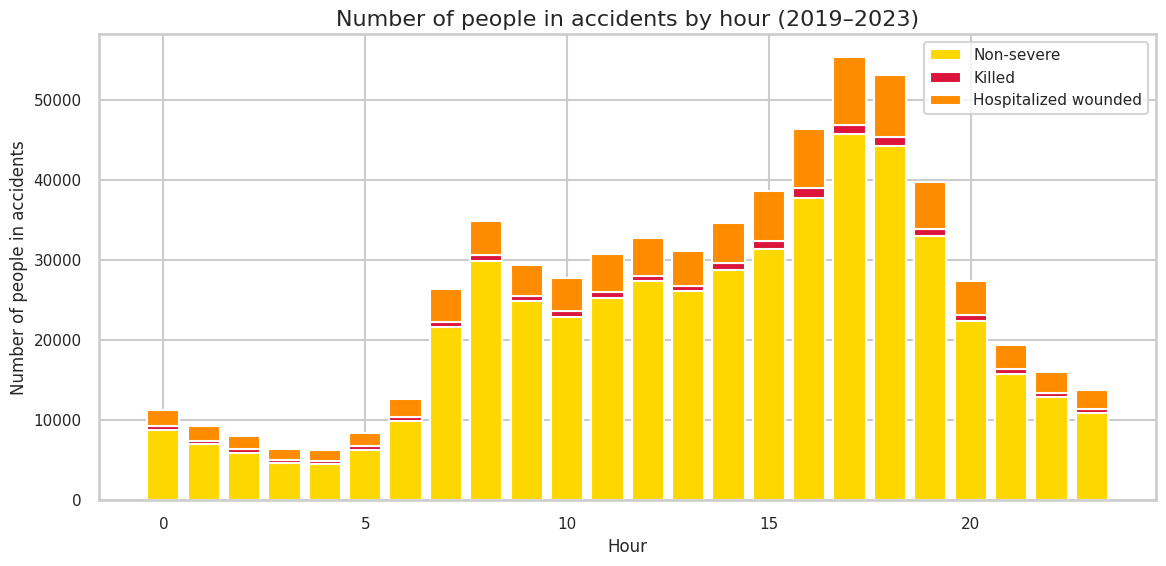

In [9]:
# Chart 2: Stacked bar by HOUR

# Count rows (people) per hour × severity
g_hour = (
    data.dropna(subset = ["hour"])
        .groupby(["hour", "injury_severity"], observed = True)
        .size()                      # count people, not sum IDs; If number of unique accidents (events) instead, replace .size() with ["num_accident"].nunique() in this line.
        .unstack(fill_value = 0)
)

# Directly select columns 2 and 3 (present in g_hour)
killed_h = g_hour[2]
hosp_h   = g_hour[3]

# Compute "other" as total minus killed/hosp
total_h = g_hour.sum(axis = 1)
other_h = total_h - killed_h - hosp_h

# Order hours 0 through 23
hour_order = list(range(0, 24))
other_h  = other_h.reindex(hour_order, fill_value = 0)
killed_h = killed_h.reindex(hour_order, fill_value = 0)
hosp_h   = hosp_h.reindex(hour_order, fill_value = 0)

# Plot (Seaborn for theme; Matplotlib for stacking)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(other_h.index, other_h.values, label="Non-severe", color=color_other)
ax.bar(killed_h.index, killed_h.values, bottom=other_h.values, label="Killed", color=color_killed)
ax.bar(hosp_h.index, hosp_h.values, bottom=(other_h+killed_h).values, label="Hospitalized wounded", color=color_hosp)
ax.set_xlabel("Hour")
ax.set_ylabel("Number of people in accidents")
ax.set_title("Number of people in accidents by hour (2019–2023)")
ax.legend()
plt.show()


#### Accidents by Hour (2019–2023)

##### Description
This chart displays the hourly distribution of people in accidents by severity. Marked peaks occur during the morning commute (7–9 a.m.), midday/afternoon (12–4 p.m.), and especially the evening rush hours (5–7 p.m.).

##### Explanation
The timing of these peaks corresponds to periods of high traffic flow: commuting hours and afternoon activities. The evening peak is particularly strong, reflecting both traffic congestion and potentially higher accident risks due to fatigue, distraction, or riskier driving behaviors in the late day.


1. Global association

Cramér’s V for Hour × Severity = 0.047

This is larger than the month result (0.018), but still a weak effect overall.

Interpretation: Accident severity does vary by hour, and the effect is somewhat stronger than month-to-month seasonal variation, but still not huge.

2. Logistic regression results

We modeled:

Severe Accident (yes/no)
∼
Hour (categorical)
Severe Accident (yes/no)∼Hour (categorical)

Baseline = 0:00–0:59 (midnight–1 am).

Key odds ratios (OR):

Early morning hours (1–5 am):

OR ≈ 1.17–1.33 → 17–33% higher odds of severe accidents than baseline.

Example: 3am and 4am ( OR = 1.33, p < 0.001) = peak severity risk.

Morning rush (6–9 am):

OR < 1 → lower odds than midnight.

Example: 8 am (OR = 0.58, p < 0.001) = accidents at 8 am are 42% less likely to be severe than those at midnight.

Midday / Afternoon (10 am – 17 pm):

OR = 0.68–0.81 → consistently lower severity odds than midnight.

Suggests daytime accidents are less often severe.

Evening (18–23 pm):

OR rises slightly (0.71–0.91) but remains below baseline.

Example: 10 pm (OR = 0.87, p < 0.001).

3. Interpretation

Highest severity risk: Late night / early morning (1–4 am).
→ 17–33% higher odds than midnight baseline.
→ Likely linked to fatigue, alcohol, reduced visibility, and higher speeds.

Lowest severity risk: Morning rush (7–9 am) and daytime (10 am–17 pm).
→ 30–40% lower odds than baseline.
→ Likely due to congested traffic (lower speeds), quicker emergency response, and urban driving conditions.

Evening (18–23 pm): Slightly elevated vs daytime, but still lower than the early morning peak.

4. Conclusion

Accident severity shows a clear hourly pattern. Severe accidents are most likely to occur in the early morning hours (1–4 am), with up to 33% higher odds of severity compared to midnight. In contrast, accidents during the morning rush and daytime (7 am–5 pm) are significantly less likely to be severe (30–40% lower odds). Overall, the relationship between hour and severity is weak but stronger than monthly seasonality (Cramér’s V = 0.047 vs 0.018).



In [10]:


# =======================================================
# 1. Compute Cramér’s V for HOUR × SEVERITY
# =======================================================
g_hour_full = (
    data.dropna(subset=["hour"])
        .groupby(["hour", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

chi2_hour, p_hour, dof_hour, _ = chi2_contingency(g_hour_full, correction=False)
n_hour = g_hour_full.values.sum()
r, c = g_hour_full.shape
cramers_v_hour = np.sqrt(chi2_hour / (n_hour * (min(r - 1, c - 1))))

print(f"\nCramér’s V for Hour × Severity = {cramers_v_hour:.3f}")

# =======================================================
# 2. Logistic regression: SEVERE (yes/no) ~ HOUR
# Baseline = 0:00–0:59
# =======================================================
data = data.dropna(subset=["hour"]).copy()
data["hour"] = data["hour"].astype("category")

model_hour = smf.logit("severe ~ C(hour)", data=data).fit()
print(model_hour.summary())

# Odds ratios for hours
params_h = model_hour.params
conf_h = model_hour.conf_int()
conf_h.columns = ["2.5%", "97.5%"]
odds_ratios_h = pd.DataFrame({
    "OR": np.exp(params_h),
    "2.5%": np.exp(conf_h["2.5%"]),
    "97.5%": np.exp(conf_h["97.5%"]),
    "p-value": model_hour.pvalues
})
print("\nOdds ratios by hour (baseline = 0:00–0:59):")
print(odds_ratios_h)


# =======================================================
# 2. Logistic regression: SEVERE (yes/no) ~ HOUR
# Baseline = 16:00–16:59
# =======================================================

data = data.dropna(subset=["hour"]).copy()
data["hour"] = data["hour"].astype("category")

# Reorder so that hour 16 is the baseline
hours = list(range(24))
hours_reordered = [16] + [h for h in hours if h != 16]
data["hour"] = data["hour"].cat.reorder_categories(hours_reordered, ordered=False)

# Logistic regression
model_hour = smf.logit("severe ~ C(hour)", data=data).fit()
print(model_hour.summary())

# Odds ratios for hours
params_h = model_hour.params
conf_h = model_hour.conf_int()
conf_h.columns = ["2.5%", "97.5%"]
odds_ratios_h = pd.DataFrame({
    "OR": np.exp(params_h),
    "2.5%": np.exp(conf_h["2.5%"]),
    "97.5%": np.exp(conf_h["97.5%"]),
    "p-value": model_hour.pvalues
})
print("\nOdds ratios by hour (baseline = 16:00–16:59):")
print(odds_ratios_h)




Cramér’s V for Hour × Severity = 0.047
Optimization terminated successfully.
         Current function value: 0.469520
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 severe   No. Observations:               619807
Model:                          Logit   Df Residuals:                   619783
Method:                           MLE   Df Model:                           23
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                0.004628
Time:                        14:29:33   Log-Likelihood:            -2.9101e+05
converged:                       True   LL-Null:                   -2.9237e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -1.2576      0.023    -55.482      0.000     

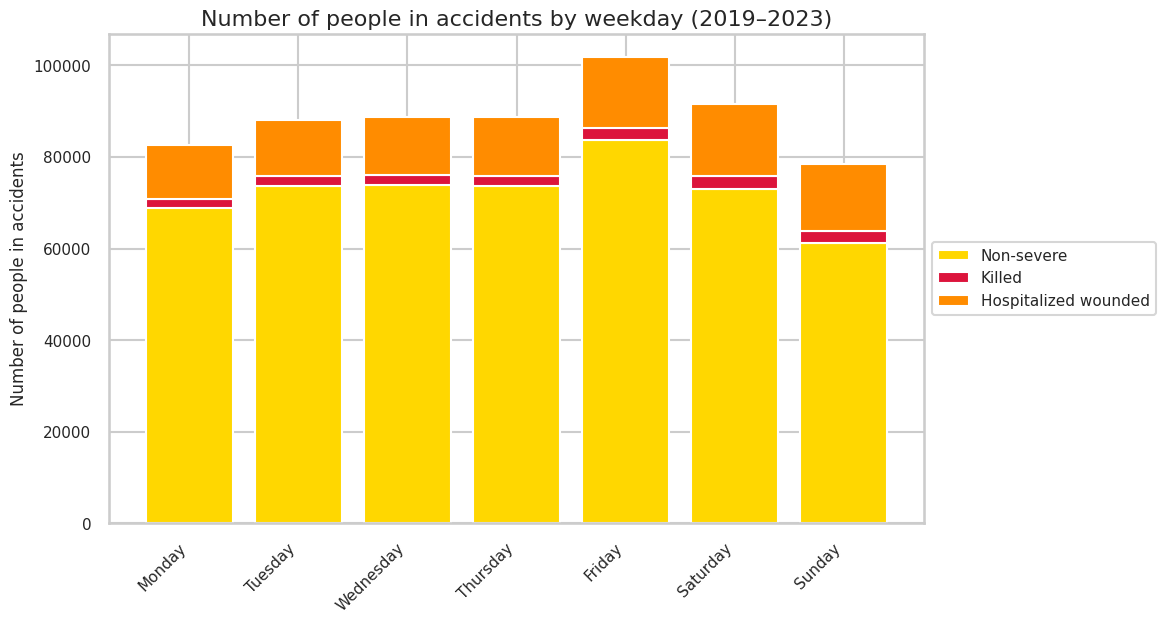

In [11]:
# Chart 3: Stacked bar by WEEKDAY

# Count rows (people) per weekday × severity
g_day = (
    data.dropna(subset=["weekday"])
        .groupby(["weekday", "injury_severity"], observed=True)
        .size()                      # count people, not sum IDs; If number of unique accidents (events) instead, replace .size() with ["num_accident"].nunique() in this line.
        .unstack(fill_value=0)
)

# Directly select columns 2 and 3 (present in g_day)
killed_d = g_day[2]
hosp_d   = g_day[3]

# Compute "other" as total minus killed/hosp
total_d = g_day.sum(axis=1)
other_d = total_d - killed_d - hosp_d

# Order weekdays Monday → Sunday
weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
other_d  = other_d.reindex(weekday_order, fill_value=0)
killed_d = killed_d.reindex(weekday_order, fill_value=0)
hosp_d   = hosp_d.reindex(weekday_order, fill_value=0)

# Plot (Seaborn for theme; Matplotlib for stacking)
fig, ax = plt.subplots(figsize=(12, 6))
ax.bar(other_d.index, other_d.values, label="Non-severe", color=color_other)
ax.bar(killed_d.index, killed_d.values, bottom=other_d.values, label="Killed", color=color_killed)
ax.bar(hosp_d.index, hosp_d.values, bottom=(other_d + killed_d).values, label="Hospitalized wounded", color=color_hosp)
#ax.set_xlabel("Weekday")
ax.set_ylabel("Number of people in accidents")
ax.set_title("Number of people in accidents by weekday (2019–2023)")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()


# Improve label readability
plt.setp(ax.get_xticklabels(), rotation=45, ha="right")
plt.show()


#### Accidents by Weekday (2019–2023)

##### Description
The bar chart shows accident involvement across weekdays. The highest numbers occur on Fridays and Saturdays, followed by Sunday, while Monday–Thursday show fewer severe cases.

##### Explanation
Friday and Saturday peaks can be explained by increased social and leisure travel, late-night driving, and possibly higher alcohol consumption during weekends. Sunday also shows elevated numbers, though slightly lower than Friday and Saturday, reflecting return travel after weekend activities.

##### Interpretation of Weekday Results
Global association

Cramér’s V = 0.027
→ The association between weekday and severity is very weak.
→ Severity does vary slightly across weekdays, but the effect size is small.

Logistic regression (baseline = Monday)

Tuesday (OR = 0.97)
→ About 3% lower odds of severe accidents vs Monday (statistically significant, but very small).

Wednesday (OR = 1.00)
→ No meaningful difference vs Monday.

Thursday (OR = 1.02)
→ Slight increase, but not statistically significant.

Friday (OR = 1.08)
→ 8% higher odds of severe accidents vs Monday.

Saturday (OR = 1.27)
→ 27% higher odds — clear weekend peak.

Sunday (OR = 1.41)
→ 41% higher odds — the highest weekday risk.

##### Summary

Weekdays Mon–Thu are basically flat (no real differences).

Friday = small but significant increase.

Saturday (+27%) and Sunday (+41%) = much higher odds of severe accidents.

Likely linked to weekend leisure travel, night driving, alcohol, and higher-speed roads.

In [12]:

# ============================================================
# 1. Cramér’s V for WEEKDAY × SEVERITY
# ============================================================
chi2_day, p_day, dof_day, _ = chi2_contingency(g_day, correction=False)
n_day = g_day.values.sum()
r, c = g_day.shape
cramers_v_day = np.sqrt(chi2_day / (n_day * (min(r - 1, c - 1))))

print(f"Cramér’s V for Weekday × Severity = {cramers_v_day:.3f}")

# ============================================================
# 2. Logistic regression: SEVERE ~ WEEKDAY
# ============================================================
data_day = data.dropna(subset=["weekday", "injury_severity"]).copy()
data_day["severe"] = data_day["injury_severity"].isin([2, 3]).astype(int)
data_day["weekday"] = pd.Categorical(
    data_day["weekday"], categories=weekday_order, ordered=False
)

model_day = smf.logit("severe ~ C(weekday)", data=data_day).fit()
print(model_day.summary())

# Odds ratios with confidence intervals
params = model_day.params
conf = model_day.conf_int()
conf.columns = ["2.5%", "97.5%"]

odds_ratios = pd.DataFrame({
    "OR": np.exp(params),
    "2.5%": np.exp(conf["2.5%"]),
    "97.5%": np.exp(conf["97.5%"]),
    "p-value": model_day.pvalues
})
print("\nOdds ratios by weekday (baseline = Monday):")
print(odds_ratios)


Cramér’s V for Weekday × Severity = 0.027
Optimization terminated successfully.
         Current function value: 0.470419
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:                 severe   No. Observations:               619807
Model:                          Logit   Df Residuals:                   619800
Method:                           MLE   Df Model:                            6
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                0.002723
Time:                        14:29:48   Log-Likelihood:            -2.9157e+05
converged:                       True   LL-Null:                   -2.9237e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.6091      

,day1,day2,severe1,total1,prop1,severe2,total2,prop2,diff,z,p_raw,p_adj,meaning
0,Wednesday,Sunday,14726,88685,16.60%,17241,78380,22.00%,-5.39%,-27.959699,5.025e-172,1.005e-170,Significant: higher on Sunday
1,Tuesday,Friday,14355,88108,16.29%,18045,101785,17.73%,-1.44%,-8.295980,1.077e-16,1.077e-15,Significant: higher on Friday
2,Tuesday,Sunday,14355,88108,16.29%,17241,78380,22.00%,-5.70%,-29.626865,6.738e-193,1.415e-191,Significant: higher on Sunday
3,Thursday,Friday,14993,88693,16.90%,18045,101785,17.73%,-0.82%,-4.738709,2.151e-06,1.506e-05,Significant: higher on Friday
4,Monday,Tuesday,13781,82660,16.67%,14355,88108,16.29%,0.38%,2.112133,3.468e-02,1.734e-01,Not significant
5,Thursday,Sunday,14993,88693,16.90%,17241,78380,22.00%,-5.09%,-26.323884,1.022e-152,1.840e-151,Significant: higher on Sunday
6,Monday,Friday,13781,82660,16.67%,18045,101785,17.73%,-1.06%,-5.972461,2.337e-09,1.870e-08,Significant: higher on Friday
7,Wednesday,Saturday,14726,88685,16.60%,18551,91496,20.28%,-3.67%,-20.072483,1.284e-89,1.926e-88,Significant: higher on Saturday
8,Thursday,Saturday,14993,88693,16.90%,18551,91496,20.28%,-3.37%,-18.378288,1.961e-75,2.549e-74,Significant: higher on Saturday
9,Tuesday,Saturday,14355,88108,16.29%,18551,91496,20.28%,-3.98%,-21.811952,1.787e-105,2.859e-104,Significant: higher on Saturday


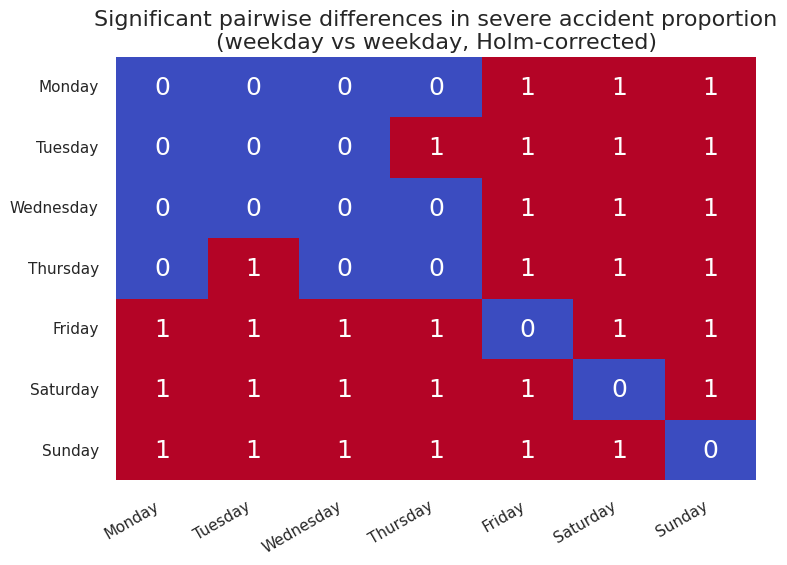

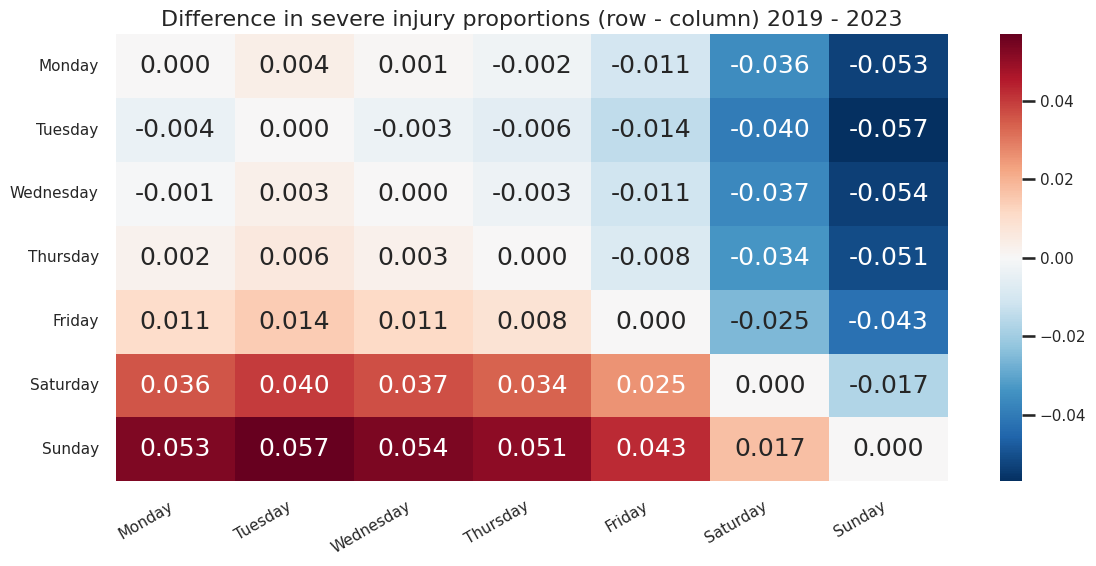

In [13]:
# Chart 4: heatmap of difference in the proportion of people in severe accidents compared to the proportion of people not in severe accidents by the day of the week

# Define weekday order
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Severe = killed(2) + hospitalized(3); be robust if a column is missing
severe_by_day = (g_day.get(2, 0) + g_day.get(3, 0)).reindex(weekdays, fill_value=0)
total_by_day  = g_day.sum(axis=1).reindex(weekdays, fill_value=0)

# -----------------------------
# 2) Pairwise comparisons
# -----------------------------
rows = []           # will hold dictionaries per pair
pvals_raw = []
pairs = []
diffs = []

for d1, d2 in itertools.combinations(weekdays, 2):
    s1, n1 = int(severe_by_day[d1]), int(total_by_day[d1])
    s2, n2 = int(severe_by_day[d2]), int(total_by_day[d2])
    if n1 == 0 or n2 == 0:
        continue  # skip impossible comparisons

    z, p_raw = proportions_ztest([s1, s2], [n1, n2])
    prop1, prop2 = s1/n1, s2/n2
    diff = prop1 - prop2

    rows.append({
        "day1": d1, "day2": d2,
        "severe1": s1, "total1": n1, "prop1": prop1,
        "severe2": s2, "total2": n2, "prop2": prop2,
        "diff": diff, "z": z, "p_raw": p_raw
    })
    pairs.append((d1, d2))
    pvals_raw.append(p_raw)
    diffs.append(diff)

# Holm correction
reject, pvals_adj, _, _ = multipletests(pvals_raw, alpha=0.05, method="holm")

# Attach adjusted p-values + meaning
for r, p_adj, sig in zip(rows, pvals_adj, reject):
    r["p_adj"] = p_adj
    if sig:
        r["meaning"] = f"Significant: higher on {r['day1']}" if r["diff"] > 0 else f"Significant: higher on {r['day2']}"
    else:
        r["meaning"] = "Not significant"

# -----------------------------
# 3) Display tidy results table
# -----------------------------
res = pd.DataFrame(rows)

# Nicely formatted view (percentages & scientific p-values)
res_view = res.copy()
for col in ["prop1","prop2","diff"]:
    res_view[col] = (res_view[col] * 100).map(lambda x: f"{x:.2f}%")
res_view["p_raw"] = res["p_raw"].map(lambda x: f"{x:.3e}")
res_view["p_adj"] = res["p_adj"].map(lambda x: f"{x:.3e}")

res_view = res_view[[
    "day1","day2",
    "severe1","total1","prop1",
    "severe2","total2","prop2",
    "diff","z","p_raw","p_adj","meaning"
]].sort_values("p_adj", ascending=True, ignore_index=True)

display(res_view)

# -----------------------------
# 4) Significance and difference heatmaps
# -----------------------------
# Build matrices for plotting
p_matrix = pd.DataFrame(1.0, index=weekdays, columns=weekdays)
diff_matrix = pd.DataFrame(0.0, index=weekdays, columns=weekdays)
for (d1, d2), p, sig, diff in zip(pairs, pvals_adj, reject, diffs):
    p_matrix.loc[d1, d2] = p
    p_matrix.loc[d2, d1] = p
    diff_matrix.loc[d1, d2] = diff
    diff_matrix.loc[d2, d1] = -diff

sig_matrix = (p_matrix < 0.05).astype(int)

plt.figure(figsize=(8, 6))
sns.heatmap(sig_matrix, annot=True, cmap="coolwarm", cbar=False,
            xticklabels=weekdays, yticklabels=weekdays)
plt.title("Significant pairwise differences in severe accident proportion\n(weekday vs weekday, Holm-corrected)")
plt.xticks(rotation=30, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()

plt.figure(figsize=(12, 6))
sns.heatmap(diff_matrix, annot=True, fmt=".3f", cmap="RdBu_r", center=0,
            xticklabels=weekdays, yticklabels=weekdays)
plt.title("Difference in severe injury proportions (row - column) 2019 - 2023")
plt.xticks(rotation=30, ha="right"); plt.yticks(rotation=0)
plt.tight_layout(); plt.show()


#### How to read the difference heatmap

Each cell shows the difference in proportions of severe accidents between two weekdays:

Difference = Proportion severe (row) − Proportion severe (column)

Positive values (red) mean the row has a higher proportion of severe accidents than the column.

Negative values (blue) mean the row has a lower proportion of severe accidents than the column.

Darker colors = bigger differences.

#### Key findings from the heatmap

Saturday and Sunday stand out:

Both have substantially higher proportions of severe accidents compared to all weekdays.

Example: Sunday vs Monday = +0.053 (5.3 percentage points higher).

Weekdays (Mon–Fri) are very similar:

Differences are very small (mostly between –1% and +1%).

Suggests accident severity is fairly stable across the work week.

Friday vs weekend:

Friday has a slightly higher severity than other weekdays (+1–1.4%),

But still lower than Saturday and Sunday (–2.5% and –4.3%).

#### Largest gap

Sunday vs Tuesday (–0.057): Sundays have about 5.7% more severe accidents proportionally than Tuesdays.

#### What this means

Weekend effect: Accident severity (killed + hospitalized) is significantly higher on weekends than on weekdays.

Weekday effect: No meaningful differences among weekdays themselves.

Friday is a “transition day” — slightly higher severity than Mon–Thu, but still clearly below Saturday/Sunday.

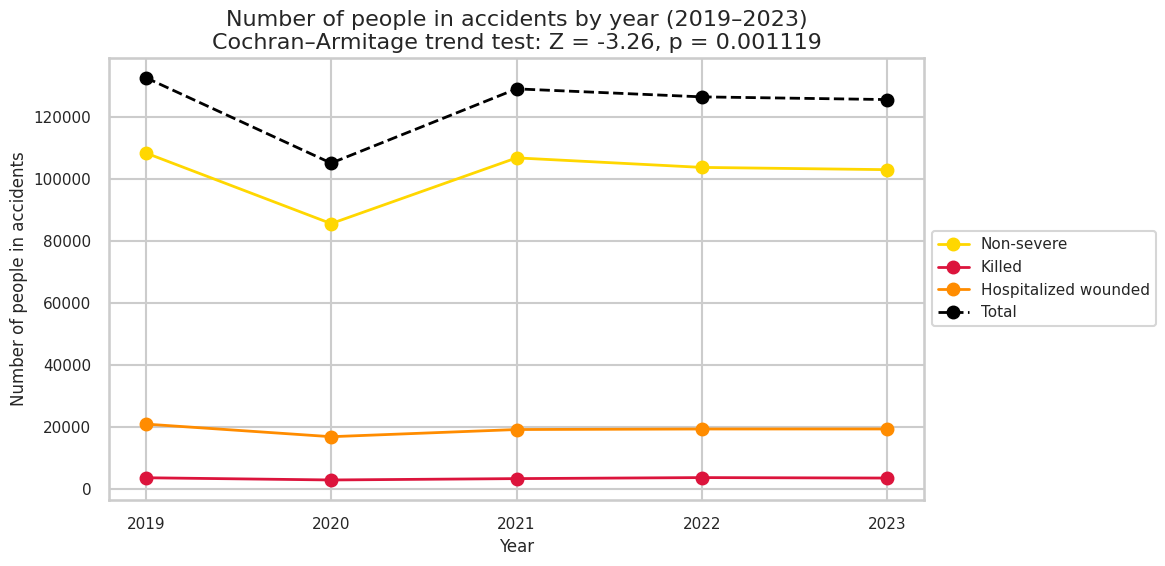

In [14]:
# Chart 5: Line Chart by year

#from scipy.stats import norm, chisquare


g_year = (
    data.dropna(subset=["year"])
      .groupby(["year", "injury_severity"], observed = True)
      .size()                     # count people, not sum IDs; If number of unique accidents (events) instead, replace .size() with ["num_accident"].nunique() in this line.
      .unstack(fill_value = 0)

)

year_order = [2019, 2020, 2021, 2022, 2023]

killed_p = g_year.get(2, pd.Series(0, index=g_year.index)).reindex(year_order, fill_value=0)
hosp_p   = g_year.get(3, pd.Series(0, index=g_year.index)).reindex(year_order, fill_value=0)
total_p  = g_year.sum(axis=1).reindex(year_order, fill_value=0)
other_p  = total_p - killed_p - hosp_p

# --- Cochran–Armitage Trend Test ---
# Severe vs Non-severe
table = pd.DataFrame({
    "Severe": (killed_p + hosp_p),
    "NotSevere": other_p
}, index=year_order)

counts = table.values
n = counts.sum(axis=1)  # totals per year
x = np.arange(1, len(n)+1)  # scores: 1,2,3,4,5
severe = counts[:,0]        # severe counts
total = counts.sum()
p = severe.sum() / total

# Test statistic
num = np.sum(x * (severe - n*p))
den = np.sqrt(p*(1-p) * np.sum(n * (x - np.mean(x))**2))
Z = num / den
p_value = 2 * (1 - norm.cdf(abs(Z)))  # two-sided

# --- Plot ---
color_other  = "#FFD700"
color_killed = "crimson"
color_hosp   = "darkorange"
color_total  = "black"

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(year_order, other_p.values, marker="o", linewidth=2, color=color_other, label="Non-severe")
ax.plot(year_order, killed_p.values, marker="o", linewidth=2, color=color_killed, label="Killed")
ax.plot(year_order, hosp_p.values, marker="o", linewidth=2, color=color_hosp, label="Hospitalized wounded")
ax.plot(year_order, total_p.values, marker="o", linewidth=2, color=color_total, linestyle="--", label="Total")

ax.set_xticks(year_order)
ax.set_xlabel("Year")
ax.set_ylabel("Number of people in accidents")

# Title includes trend test result
ax.set_title(f"Number of people in accidents by year (2019–2023)\nCochran–Armitage trend test: Z = {Z:.2f}, p = {p_value:.4g}")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()


Percent severe by year (%):
year
2019    18.32
2020    18.58
2021    17.26
2022    18.01
2023    18.02
dtype: float64

Change 2019 → 2023: -0.30 pp (-1.65%)
Optimization terminated successfully.
         Current function value: 0.471695
         Iterations 5

Logistic regression (severe ~ year):
Per-year OR = 0.992 (95% CI 0.988–0.997), p = 0.00112


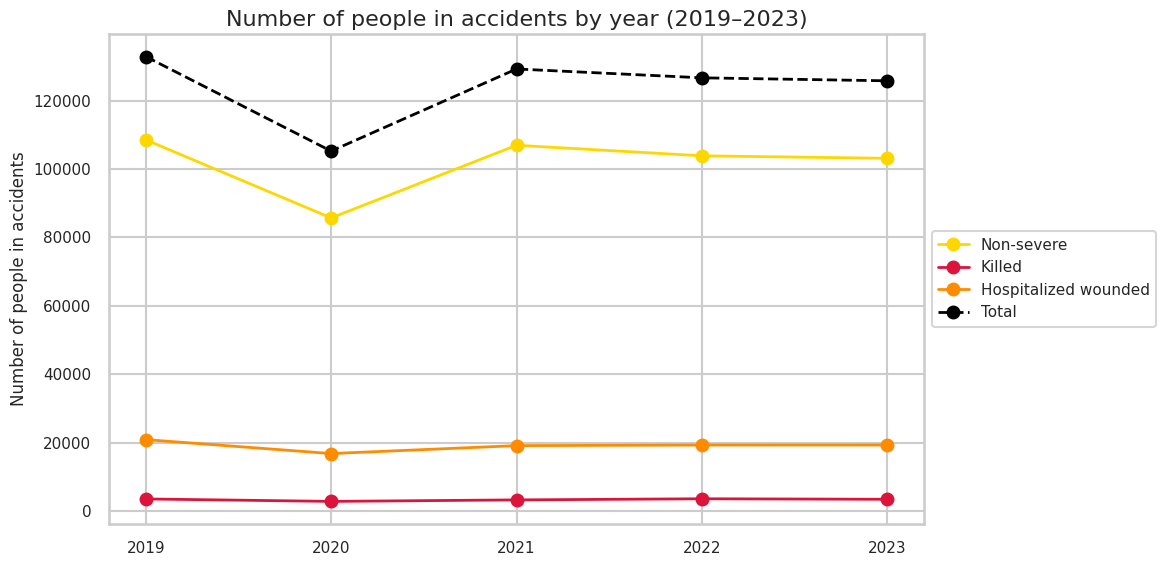

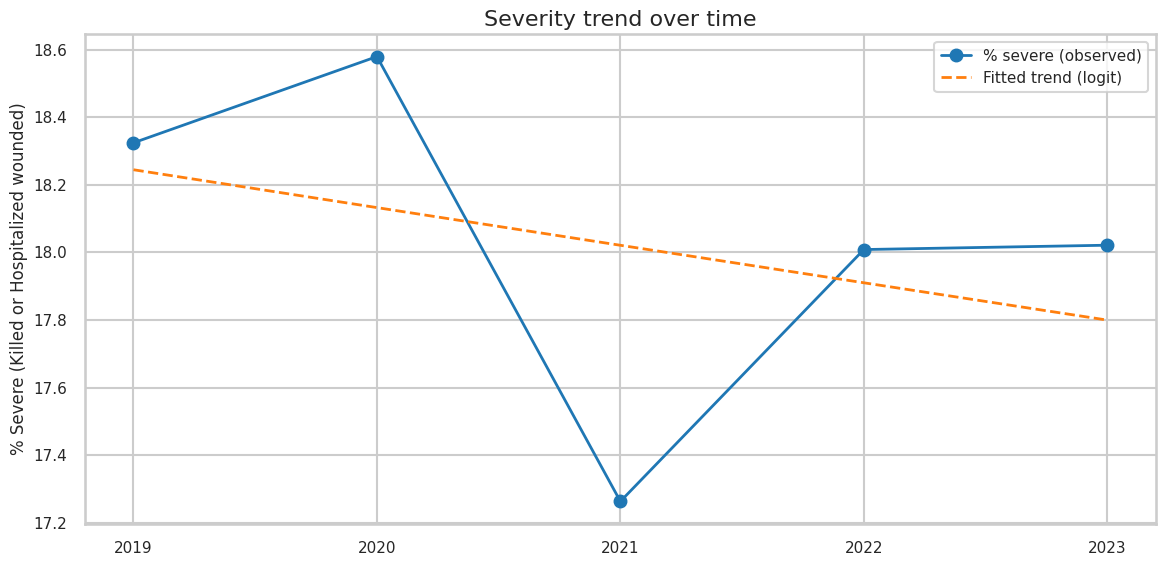

In [15]:
# --- Chart 5: Line charts by YEAR + effect-size reporting ---


# Colors
color_other  = globals().get("color_other",  "#FFD700")
color_killed = globals().get("color_killed", "crimson")
color_hosp   = globals().get("color_hosp",   "darkorange")
color_total  = globals().get("color_total",  "black")

# ==============================
# 1) Build year × severity table
# ==============================
g_year = (
    data.dropna(subset=["year"])
        .groupby(["year", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

year_order = [2019, 2020, 2021, 2022, 2023]

killed_p = g_year.get(2, pd.Series(0, index=g_year.index)).reindex(year_order, fill_value=0)
hosp_p   = g_year.get(3, pd.Series(0, index=g_year.index)).reindex(year_order, fill_value=0)
total_p  = g_year.sum(axis=1).reindex(year_order, fill_value=0)
other_p  = total_p - killed_p - hosp_p

# ==============================
# 2) % severe per year + changes
# ==============================
severe_p = killed_p + hosp_p
pct_severe = (severe_p / total_p * 100)

start_year, end_year = year_order[0], year_order[-1]
abs_change_pp = pct_severe.loc[end_year] - pct_severe.loc[start_year]           # percentage points
rel_change    = (pct_severe.loc[end_year] / pct_severe.loc[start_year] - 1) * 100  # percent

print("Percent severe by year (%):")
print(pct_severe.round(2))
print(f"\nChange {start_year} → {end_year}: "
      f"{abs_change_pp:.2f} pp ({rel_change:.2f}%)")

# ==========================================
# 3) Logistic regression: severe ~ year (cts)
# ==========================================
df = data.dropna(subset=["year", "injury_severity"]).copy()
df["severe"] = df["injury_severity"].isin([2, 3]).astype(int)

# Ensure 'year' is numeric
df["year_n"] = pd.to_numeric(df["year"], errors="raise")  # was Categorical before

# Center year to improve numerical stability and interpretability
base_year = min([2019, 2020, 2021, 2022, 2023])  # or: int(df["year_n"].min())
df["year_c"] = df["year_n"] - base_year

import statsmodels.formula.api as smf
model = smf.logit("severe ~ year_c", data=df).fit()

beta = model.params["year_c"]
se   = model.bse["year_c"]
or_per_year = np.exp(beta)
ci_low  = np.exp(beta - 1.96*se)
ci_high = np.exp(beta + 1.96*se)
pval    = model.pvalues["year_c"]

print("\nLogistic regression (severe ~ year):")
print(f"Per-year OR = {or_per_year:.3f} (95% CI {ci_low:.3f}–{ci_high:.3f}), p = {pval:.3g}")

# Predicted probabilities for plotting
year_order = [2019, 2020, 2021, 2022, 2023]  # keep your existing list
pred_grid = pd.DataFrame({"year_c": np.array(year_order) - base_year})
pred_grid["pred_prob"] = model.predict(pred_grid)

# ==============================
# 4) Plot A: counts by year
# ==============================
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(year_order, other_p.values, marker="o", linewidth=2, color=color_other,  label="Non-severe")
ax.plot(year_order, killed_p.values, marker="o", linewidth=2, color=color_killed, label="Killed")
ax.plot(year_order, hosp_p.values,   marker="o", linewidth=2, color=color_hosp,   label="Hospitalized wounded")
ax.plot(year_order, total_p.values,  marker="o", linewidth=2, color=color_total, linestyle="--", label="Total")

ax.set_xticks(year_order)
#ax.set_xlabel("Year")
ax.set_ylabel("Number of people in accidents")
ax.set_title("Number of people in accidents by year (2019–2023)")
ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

# ==============================
# 5) Plot B: % severe + fitted trend
# ==============================
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(year_order, pct_severe.values, marker="o", linewidth=2, color="tab:blue", label="% severe (observed)")
ax.plot(year_order, pred_grid["pred_prob"].values * 100, linestyle="--", linewidth=2, color="tab:orange",
        label="Fitted trend (logit)")

ax.set_xticks(year_order)
#ax.set_xlabel("Year")
ax.set_ylabel("% Severe (Killed or Hospitalized wounded)")
ax.set_title(
    "Severity trend over time"
    #f"{start_year}→{end_year}: Δ = {abs_change_pp:.2f} pp ({rel_change:.2f}%).  "
    #f"Per-year OR = {or_per_year:.3f} (95% CI {ci_low:.3f}–{ci_high:.3f}), p = {pval:.3g}"
)
ax.legend()
plt.tight_layout()
plt.show()

#### Number of people in accidents by year (2019–2023) with a Cochran–Armitage trend test and logistic regression

##### Description

The line graph shows the number of people in accidents each year, broken down into categories: Non-severely injured, killed, hospitalized wounded, and the total (dashed line).

The Cochran–Armitage trend test produced a test statistic of Z = -3.26 with p ≈ 0.001. This indicates a significant trend in the proportion of severe accidents (killed or hospitalized) over time.

##### Explanation

The negative Z-value indicates that the proportion of severe accidents (relative to all accident-involved people) decreased slightly across the years

The dip in 2020 corresponds to the COVID-19 pandemic, when road traffic volumes were unusually low. After 2021, accident numbers increased again as travel returned to normal levels.

##### Interpretation

The test confirms that there is a systematic trend over time, not just random variation.

The risk of being severely injured or killed relative to all accident-involved people slightly decreased across the 5-year period.

This suggests some improvement in relative road safety (e.g., better car safety, quicker medical response).


##### Regression results

The odds ratio (OR) is less than 1 → this means the probability of a severe outcome is decreasing over time.

Specifically, each passing year is associated with a 0.8% decrease in the odds of a severe injury (since 1−0.992=0.008).

The p-value = 0.00112 is well below 0.05, and the 95% CI (0.988–0.997) does not include 1.
Therefore, this decline is statistically significant — it’s unlikely to be due to random variation.

A 0.8% decline per year might sound small, but over multiple years it compounds.
The odds of a severe injury are roughly 4% lower in 2023 than in 2019.

##### Summary

Over time, accidents are becoming slightly less likely to result in severe injuries or fatalities.
Each year, the odds of a severe outcome decrease by about 0.8%, and this trend is statistically significant.


,Non-severe,Killed,Hospitalized wounded,Total
2019,"108,527","3,497","20,852","132,876"
2020,"85,680","2,780","16,772","105,232"
2021,"106,936","3,219","19,093","129,248"
2022,"103,852","3,550","19,260","126,662"
2023,"103,120","3,398","19,271","125,789"
Total,"508,115","16,444","95,248","619,807"


Saved colored table to: accidents_people_table_2019_2023.html
Open it in your browser, select the table, copy, and paste into Google Docs.
Saved: accidents_people_table_2019_2023.html


/tmp/ipython-input-3893904142.py:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_fmt = df.applymap(fmt)


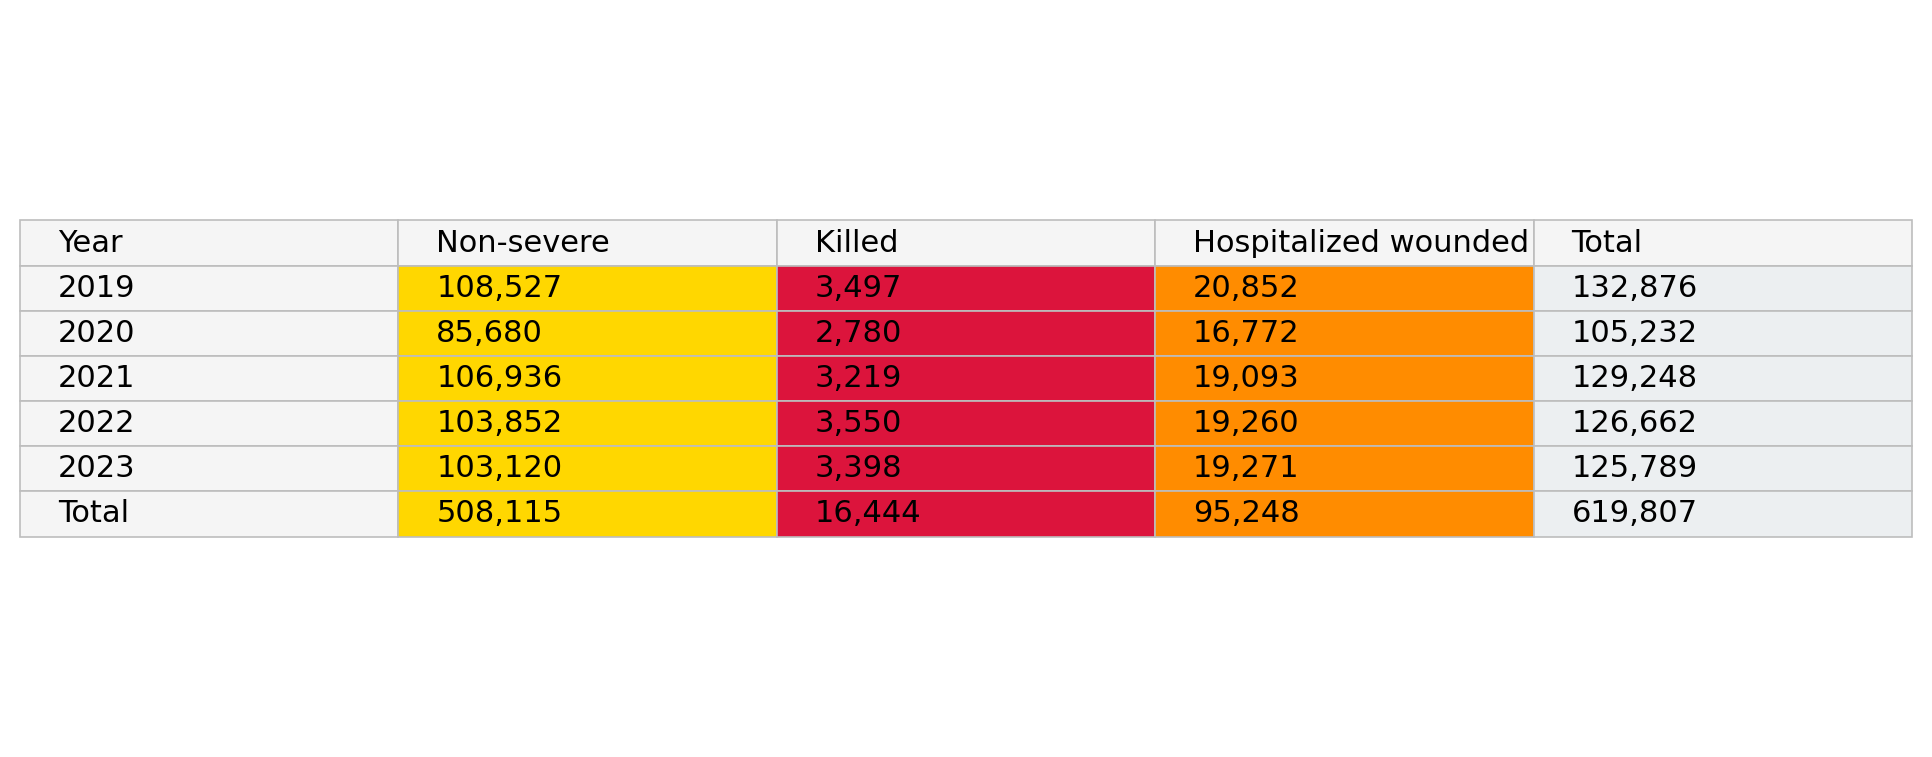

In [16]:
# Same information as the line chart above but in table format

from IPython.display import display

# --- Colors ---
bg_other  = "#FFD700"
bg_killed = "crimson"
bg_hosp   = "darkorange"

# ---------- PEOPLE (counting people) ----------
g_year_people = (
    data.dropna(subset=["year"])
        .groupby(["year", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)
killed_p = g_year.get(2, pd.Series(0, index=g_year.index)).reindex(year_order, fill_value=0)
hosp_p   = g_year.get(3, pd.Series(0, index=g_year.index)).reindex(year_order, fill_value=0)
total_p  = g_year.sum(axis=1).reindex(year_order, fill_value=0)
other_p  = (total_p - killed_p - hosp_p)

people_df = pd.DataFrame({
    "Non-severe": other_p,
    "Killed": killed_p,
    "Hospitalized wounded": hosp_p,
}, index=year_order)

# --- add Total column and Total row ---
people_df["Total"] = people_df.sum(axis=1)
people_df.loc["Total"] = people_df.sum(axis=0)
# ---------- Styling helpers ----------
def color_by_column(df, col_colors):
    styles = pd.DataFrame("", index=df.index, columns=df.columns)
    for col, bg in col_colors.items():
        if col in styles.columns:
            styles[col] = f"background-color: {bg};"
    # Neutral background for the Total column (optional)
    if "Total" in styles.columns:
        styles["Total"] = "background-color: #ECEFF1;"  # light neutral
    return styles

def set_text_colors(styler, light_cols=(), dark_cols=()):
    if light_cols:
        styler = styler.set_properties(subset=pd.IndexSlice[:, list(light_cols)], **{"color": "black"})
    if dark_cols:
        styler = styler.set_properties(subset=pd.IndexSlice[:, list(dark_cols)], **{"color": "black"})
    # Make last row (Total) bold
    styler = styler.set_properties(subset=pd.IndexSlice[["Total"], :], **{"font-weight": "bold"})
    # Make Total column bold
    if "Total" in styler.data.columns:
        styler = styler.set_properties(subset=pd.IndexSlice[:, ["Total"]], **{"font-weight": "bold"})
    # Caption formatting
    styler = styler.set_table_styles([
        {"selector": "caption", "props": [("caption-side", "top"),
                                          ("text-align", "center"),
                                          ("font-weight", "bold"),
                                          ("font-size", "110%")]},
        {"selector": "th.row_heading", "props": [("color", "inherit")]}
    ], overwrite=False)
    return styler

# --- People table (with Total column) ---
people_colors = {
    "Non-severe": "#FFD700",
    "Killed": "crimson",
    "Hospitalized wounded": "darkorange",
}
people_styler = (
    people_df.style
    .format("{:,.0f}")
    .apply(color_by_column, col_colors=people_colors, axis=None)
    .set_caption("Number of people in accidents by year (2019–2023)")
)
people_styler = set_text_colors(
    people_styler,
    light_cols=("Non-severe", "Total"),
    dark_cols=("Killed", "Hospitalized wounded"),
)
display(people_styler)

# --- Export the colored table to HTML for copy/paste into Google Docs ---

# Make the table look good in Docs (font, spacing, no borders)
people_styler = (
    people_styler
    .set_table_attributes(
        'style="border-collapse:collapse; font-family:Arial, sans-serif; font-size:12pt"'
    )
    .set_properties(**{"padding": "6px", "border": "none"})
)

html_str = people_styler.to_html()

# Save to file
html_path = "accidents_people_table_2019_2023.html"
with open(html_path, "w", encoding="utf-8") as f:
    f.write(html_str)

print(f"Saved colored table to: {html_path}\n"
      "Open it in your browser, select the table, copy, and paste into Google Docs.")

# Export the styled DataFrame (with colors) as HTML
html_str = people_styler.to_html()

# Save in the current working directory
file_name = "accidents_people_table_2019_2023.html"
with open(file_name, "w", encoding="utf-8") as f:
    f.write(html_str)

print(f"Saved: {file_name}")

# Render the styled DataFrame to HTML WITHOUT forcing bigger fonts
people_styler = (
    people_styler
    .set_table_attributes(
        'style="border-collapse:collapse; font-family:Arial, sans-serif;"'
    )
    .set_properties(**{"padding": "6px", "border": "none"})
)

html_str = people_styler.to_html()

from IPython.display import HTML
HTML(html_str)

# --------- INPUT ---------
# people_df:
# index = [2019, 2020, 2021, 2022, 2023, 'Total']
# columns = ["Non-severe", "Killed", "Hospitalized wounded", "Total"]

df = people_df.copy()

# Ensure order and ensure "Total" row exists
row_order = [2019, 2020, 2021, 2022, 2023]
if "Total" not in df.index:
    df["Total"] = df.sum(axis=1)
    df.loc["Total"] = df.sum(axis=0)
df = df.reindex(row_order + ["Total"])

# Format numbers with thousands separators (strings)
fmt = lambda x: "" if pd.isna(x) else f"{int(x):,}"
df_fmt = df.applymap(fmt)

# --------- COLORS & TEXT ---------
col_bg = {
    "Non-severe": "#FFD700",
    "Killed": "crimson",
    "Hospitalized wounded": "darkorange",
    "Total": "#ECEFF1",
}
col_text = {
    "Non-severe": "black",
    "Killed": "black",
    "Hospitalized wounded": "black",
    "Total": "black",
}
header_bg  = "#F5F5F5"
header_txt = "black"
index_bg   = "#F5F5F5"   # first column (“Year”)
index_txt  = "black"
grid_color = "#BDBDBD"

# --------- BUILD FULL CELL MATRIX (header + data) ---------
col_names = list(df_fmt.columns)
header = ["Year"] + col_names
rows = [[str(idx)] + list(df_fmt.loc[idx, col_names]) for idx in df_fmt.index]
cell_text = [header] + rows  # shape: (nrows+1) x (ncols+1)

nrows = len(cell_text)
ncols = len(cell_text[0])

# --------- DRAW TABLE ---------
col_width = 2.0
row_height = 0.55
fig_w = col_width * ncols
fig_h = row_height * (nrows + 0.5)

fig, ax = plt.subplots(figsize=(fig_w, fig_h), dpi=200)
ax.axis("off")

tbl = ax.table(cellText=cell_text, loc="center", cellLoc="left")

# Font size 11, no bold
tbl.auto_set_font_size(False)
tbl.set_fontsize(11)
tbl.scale(1, 1.2)
for cell in tbl.get_celld().values():
    cell.set_linewidth(0.6)
    cell.set_edgecolor(grid_color)
    cell.get_text().set_fontweight("normal")  # ensure not bold

# Header row styling (row 0)
for c in range(ncols):
    cell = tbl[(0, c)]
    cell.set_facecolor(header_bg)
    cell.get_text().set_color(header_txt)


# First column (“Year”) styling (all rows >=1 plus header already set)
for r in range(1, nrows):
    cell = tbl[(r, 0)]
    cell.set_facecolor(index_bg)
    cell.get_text().set_color(index_txt)

# Data column backgrounds & text colors
name_by_col = {j+1: name for j, name in enumerate(col_names)}  # table col index -> name
for j in range(1, ncols):
    name = name_by_col[j]
    bg = col_bg.get(name, "black")
    tc = col_text.get(name, "black")
    for r in range(1, nrows):
        cell = tbl[(r, j)]
        cell.set_facecolor(bg)
        cell.get_text().set_color(tc)

# Optional title
# ax.set_title("Number of people in accidents by year (2019–2023)", fontsize=11, pad=10)

#out_path = "accidents_people_table_2019_2023.png"
#plt.savefig(out_path, bbox_inches="tight", dpi=200)
#plt.close(fig)
#print(f"Saved PNG table to: {out_path}")

#from google.colab import files
#files.download("accidents_people_table_2019_2023.png")


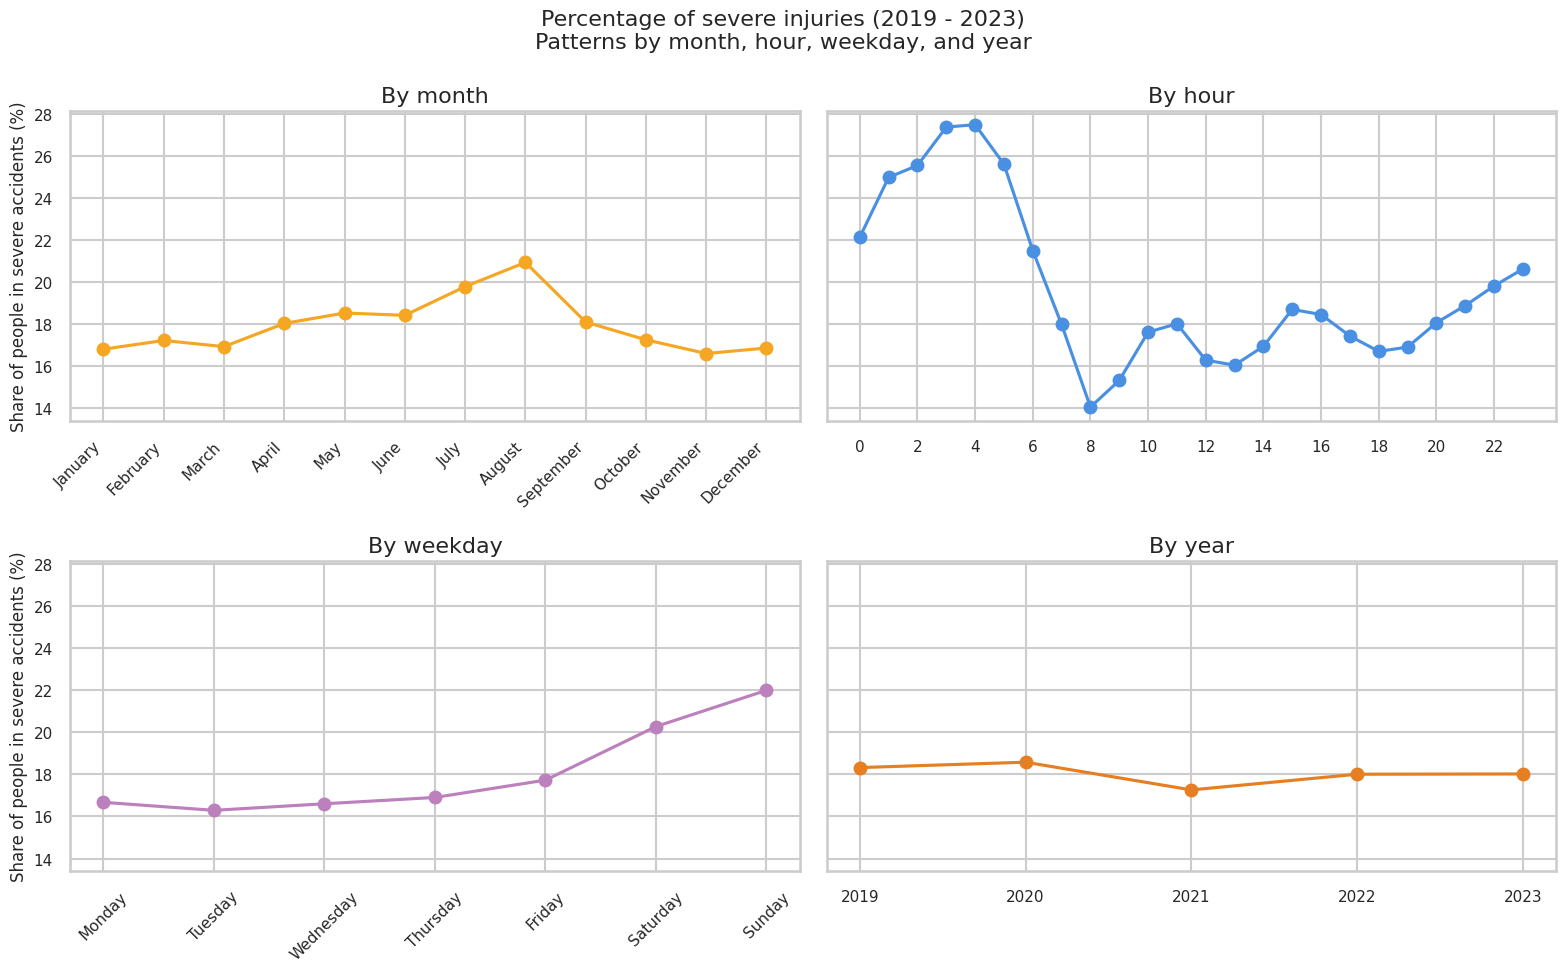

In [17]:
# Combined % Severe charts: Month, Hour, Weekday, Year (2×2 layout)


# Define a custom palette (greys, blues, and oranges)
custom_palette = [
    "#F5A623",  # orange -> Month
    "#4A90E2",  # medium blue -> Hour
    "#BC80BD",  # lavender  -> Weekday
    "#E67E22",  # dark orange -> Year
]

# =============== Helpers ===============
def safe_pick(df, col, default_index):
    """Return df[col] if present, else a zero Series aligned to default_index."""
    return df[col] if col in df.columns else pd.Series(0, index=default_index)

# =============== % Severe by MONTH ===============
g_month = (
    data.dropna(subset=["month"])
        .groupby(["month", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

month_order = list(range(1, 13))
killed_m = safe_pick(g_month, 2, g_month.index).reindex(month_order, fill_value=0)
hosp_m   = safe_pick(g_month, 3, g_month.index).reindex(month_order, fill_value=0)
total_m  = g_month.sum(axis=1).reindex(month_order, fill_value=0)
severe_m = (killed_m + hosp_m)
pct_severe_month = (severe_m / total_m * 100)

# =============== % Severe by HOUR ===============
g_hour = (
    data.dropna(subset=["hour"])
        .groupby(["hour", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

hour_order = list(range(0, 24))
killed_h = safe_pick(g_hour, 2, g_hour.index).reindex(hour_order, fill_value=0)
hosp_h   = safe_pick(g_hour, 3, g_hour.index).reindex(hour_order, fill_value=0)
total_h  = g_hour.sum(axis=1).reindex(hour_order, fill_value=0)
severe_h = (killed_h + hosp_h)
pct_severe_hour = (severe_h / total_h * 100)

# =============== % Severe by WEEKDAY ===============
g_day = (
    data.dropna(subset=["weekday"])
        .groupby(["weekday", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

weekday_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
killed_d = safe_pick(g_day, 2, g_day.index).reindex(weekday_order, fill_value=0)
hosp_d   = safe_pick(g_day, 3, g_day.index).reindex(weekday_order, fill_value=0)
total_d  = g_day.sum(axis=1).reindex(weekday_order, fill_value=0)
severe_d = (killed_d + hosp_d)
pct_severe_day = (severe_d / total_d * 100)

# =============== % Severe by YEAR ===============
g_year = (
    data.dropna(subset=["year"])
        .groupby(["year", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)

# Choose the year order
year_order =[2019, 2020, 2021, 2022, 2023]
killed_y = safe_pick(g_year, 2, g_year.index).reindex(year_order, fill_value=0)
hosp_y   = safe_pick(g_year, 3, g_year.index).reindex(year_order, fill_value=0)
total_y  = g_year.sum(axis=1).reindex(year_order, fill_value=0)
severe_y = (killed_y + hosp_y)
pct_severe_year = (severe_y / total_y * 100)

# =============== Plot 2×2 ===============
fig, axes = plt.subplots(2, 2, figsize=(16, 10), sharey=True)

# Panel A: Month
axes[0, 0].plot(pct_severe_month.index, pct_severe_month.values, marker="o",
                color=custom_palette[0])

# Use month names instead of numbers
month_names = ["January", "February", "March", "April", "May", "June",
               "July", "August", "September", "October", "November", "December"]
axes[0, 0].set_xticks(month_order)
axes[0, 0].set_xticklabels(month_names, rotation=45, ha="right")

axes[0, 0].set_title("By month")
axes[0, 0].set_ylabel("Share of people in severe accidents (%)")


# Panel B: Hour
axes[0, 1].plot(pct_severe_hour.index, pct_severe_hour.values, marker="o",
                color=custom_palette[1])
axes[0, 1].set_xticks(range(0, 24, 2))
axes[0, 1].set_title("By hour")
#axes[0, 1].set_xlabel("Hour of Day")

# Panel C: Weekday
axes[1, 0].plot(pct_severe_day.index, pct_severe_day.values, marker="o",
                color=custom_palette[2])
axes[1, 0].set_title("By weekday")
axes[1, 0].set_xlabel("")
axes[1, 0].tick_params(axis="x", rotation=45)
axes[1, 0].set_ylabel("Share of people in severe accidents (%)")

# Panel D: Year
axes[1, 1].plot(pct_severe_year.index, pct_severe_year.values, marker="o",
                color=custom_palette[3])
axes[1, 1].set_xticks(year_order)
axes[1, 1].set_title("By year")
#axes[1, 1].set_xlabel("Year")

fig.suptitle(
    "Percentage of severe injuries (2019 - 2023)\n"
    "Patterns by month, hour, weekday, and year",
    fontsize=16
)

plt.tight_layout()
plt.show()


In [18]:
# The percentages used in the graphs above in table format

# ---------- Helpers ----------
def safe_pick(df, col, default_index):
    """Return df[col] if present, else a zero Series aligned to default_index."""
    return df[col] if col in df.columns else pd.Series(0, index=default_index)

# ---------- % Severe by MONTH ----------
g_month = (
    data.dropna(subset=["month"])
        .groupby(["month", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)
month_order = list(range(1, 13))
killed_m = safe_pick(g_month, 2, g_month.index).reindex(month_order, fill_value=0)
hosp_m   = safe_pick(g_month, 3, g_month.index).reindex(month_order, fill_value=0)
total_m  = g_month.sum(axis=1).reindex(month_order, fill_value=0)
severe_m = (killed_m + hosp_m)
pct_severe_month = (severe_m / total_m * 100).replace([np.inf, -np.inf], np.nan)

month_names = ["January","February","March","April","May","June",
               "July","August","September","October","November","December"]
month_table = (
    pd.DataFrame({
        "month_num": month_order,
        "month": month_names,
        "percent_severe": pct_severe_month.values
    })
    .set_index("month_num")
)

# ---------- % Severe by HOUR ----------
g_hour = (
    data.dropna(subset=["hour"])
        .groupby(["hour", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)
hour_order = list(range(0, 24))
killed_h = safe_pick(g_hour, 2, g_hour.index).reindex(hour_order, fill_value=0)
hosp_h   = safe_pick(g_hour, 3, g_hour.index).reindex(hour_order, fill_value=0)
total_h  = g_hour.sum(axis=1).reindex(hour_order, fill_value=0)
severe_h = (killed_h + hosp_h)
pct_severe_hour = (severe_h / total_h * 100).replace([np.inf, -np.inf], np.nan)

hour_table = pd.DataFrame({
    "hour": hour_order,
    "percent_severe": pct_severe_hour.values
}).set_index("hour")

# ---------- % Severe by WEEKDAY ----------
g_day = (
    data.dropna(subset=["weekday"])
        .groupby(["weekday", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)
weekday_order = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]
killed_d = safe_pick(g_day, 2, g_day.index).reindex(weekday_order, fill_value=0)
hosp_d   = safe_pick(g_day, 3, g_day.index).reindex(weekday_order, fill_value=0)
total_d  = g_day.sum(axis=1).reindex(weekday_order, fill_value=0)
severe_d = (killed_d + hosp_d)
pct_severe_day = (severe_d / total_d * 100).replace([np.inf, -np.inf], np.nan)

weekday_table = pd.DataFrame({
    "weekday": weekday_order,
    "percent_severe": pct_severe_day.values
}).set_index("weekday")

# ---------- % Severe by YEAR ----------
g_year = (
    data.dropna(subset=["year"])
        .groupby(["year", "injury_severity"], observed=True)
        .size()
        .unstack(fill_value=0)
)
year_order = [2019, 2020, 2021, 2022, 2023]
killed_y = safe_pick(g_year, 2, g_year.index).reindex(year_order, fill_value=0)
hosp_y   = safe_pick(g_year, 3, g_year.index).reindex(year_order, fill_value=0)
total_y  = g_year.sum(axis=1).reindex(year_order, fill_value=0)
severe_y = (killed_y + hosp_y)
pct_severe_year = (severe_y / total_y * 100).replace([np.inf, -np.inf], np.nan)

year_table = pd.DataFrame({
    "year": year_order,
    "percent_severe": pct_severe_year.values
}).set_index("year")

# ---------- Rounded printouts ----------
print("\n=== % Severe by MONTH ===")
print(month_table.round(2))

print("\n=== % Severe by HOUR ===")
print(hour_table.round(2))

print("\n=== % Severe by WEEKDAY ===")
print(weekday_table.round(2))

print("\n=== % Severe by YEAR ===")
print(year_table.round(2))



=== % Severe by MONTH ===
               month  percent_severe
month_num                           
1            January           16.82
2           February           17.23
3              March           16.94
4              April           18.04
5                May           18.54
6               June           18.43
7               July           19.79
8             August           20.94
9          September           18.11
10           October           17.26
11          November           16.61
12          December           16.87

=== % Severe by HOUR ===
      percent_severe
hour                
0              22.14
1              24.98
2              25.55
3              27.37
4              27.49
5              25.61
6              21.51
7              18.00
8              14.07
9              15.33
10             17.63
11             18.03
12             16.30
13             16.06
14             16.95
15             18.71
16             18.47
17             17.45
18       

#### logistic regression for severity ~ month + hour + weekday + year.

Results: Accident severity is most strongly influenced by the time of day (higher at night, lower during the day) and the day of the week (riskier on weekends). Month has only a small effect, and severity odds have slightly declined from 2019 to 2023.

In [19]:
# import statsmodels.formula.api as smf


# =======================================================
# Logistic regression: SEVERE (yes/no) ~ month + hour + weekday + year
# =======================================================

# Make a copy and prepare variables
data = data.dropna(subset=["month", "hour", "weekday", "year", "injury_severity"]).copy()

# Define severe outcome (hospitalized or killed, assuming severity codes 2 and 3)
#data["severe"] = data["injury_severity"].isin([2, 3]).astype(int)

# Ensure categorical encoding for categorical predictors
data["month"] = data["month"].astype("category")
data["hour"] = data["hour"].astype("category")
data["weekday"] = data["weekday"].astype("category")
data["year"] = data["year"].astype("category")

# Fit logistic regression model
model_full = smf.logit("severe ~ C(month) + C(hour) + C(weekday) + C(year)", data=data).fit()

# Print model summary
print(model_full.summary())

# =======================================================
# Odds ratios with confidence intervals
# =======================================================
params = model_full.params
conf = model_full.conf_int()
conf.columns = ["2.5%", "97.5%"]

odds_ratios = pd.DataFrame({
    "OR": np.exp(params),
    "2.5%": np.exp(conf["2.5%"]),
    "97.5%": np.exp(conf["97.5%"]),
    "p-value": model_full.pvalues
})

print("\nOdds ratios for predictors:")
print(odds_ratios)


Optimization terminated successfully.
         Current function value: 0.468283
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 severe   No. Observations:               619807
Model:                          Logit   Df Residuals:                   619762
Method:                           MLE   Df Model:                           44
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                0.007251
Time:                        14:30:20   Log-Likelihood:            -2.9025e+05
converged:                       True   LL-Null:                   -2.9237e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                  -1.3004      0.019    -69.661      0.000      -1.337   

### 2. Age Analysis

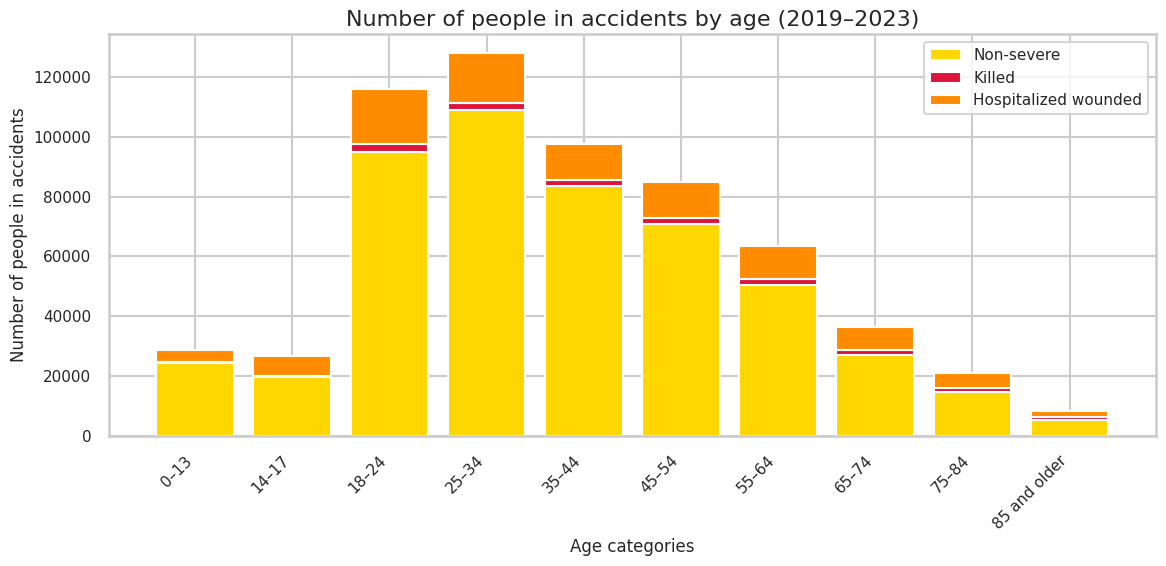

In [20]:
# Chart 6: Stacked bar by AGE CATEGORIES

# Count rows (people) per age bucket × severity
g_age = (
    data.dropna(subset=["age_bucket"])
        .groupby(["age_bucket", "injury_severity"], observed = True)
        .size()                      # count people, not sum IDs;If number of unique accidents (events) instead, replace .size() with ["num_accident"].nunique() in this line.
        .unstack(fill_value = 0)
)

# Directly select columns 2 and 3 (present in g_age)
killed_a = g_age[2]
hosp_a   = g_age[3]

# Compute "other" as total minus killed/hosp
total_a = g_age.sum(axis = 1)
other_a = total_a - killed_a - hosp_a

# X-axis values = all categories in the table (keeps natural order from the data)
x_vals = list(g_age.index)

# Severe = killed (2) + hospitalized (3)
severe_age = g_age[[2,3]].sum(axis=1)

# Plot (Seaborn for theme; Matplotlib for stacking)
fig, ax = plt.subplots(figsize = (12, 6))
ax.bar(x_vals, other_a.loc[x_vals].values,
       label = "Non-severe", color = color_other)
ax.bar(x_vals, killed_a.loc[x_vals].values,
       bottom = other_a.loc[x_vals].values, label = "Killed", color = color_killed)
ax.bar(x_vals, hosp_a.loc[x_vals].values,
       bottom = (other_a.loc[x_vals] + killed_a.loc[x_vals]).values,
       label = "Hospitalized wounded", color = color_hosp)

ax.set_xlabel("Age categories")
ax.set_ylabel("Number of people in accidents")
ax.set_title("Number of people in accidents by age (2019–2023)")
ax.legend(loc = "upper right")

# Rotate category labels so they don’t overlap
plt.setp(ax.get_xticklabels(), rotation = 45, ha = "right")
plt.show()


#### Accidents by Age Category (2019–2023)


##### Summary

Severe accident counts peak in young adults (18–34).

The proportion of severe accidents rises steeply with age, reaching 36% in 85+.

Severity type depends strongly on age: children are more often  (non-severe), teenagers hospitalized, and older adults killed or severely injured.

This tells a two-part story:

Exposure effect: younger adults (18–34) dominate severe counts because they drive more.

Vulnerability effect: older adults are less involved overall but face much higher severity once accidents occur.

##### Global association

Cramér’s V (bias-corrected) = 0.094
→ A small but non-trivial association between age group and the probability an accident is severe.
→ Stronger than the month (≈0.018) and weekday (≈0.027) effects, and roughly 2× the hour effect (≈0.047).

Logistic regression (baseline = first age bucket in x_vals, i.e., the youngest group)

Odds ratios (OR) compare each age group’s odds of a severe outcome to that baseline.

14–17: OR 2.13 → ~+113% higher odds.

18–24: OR 1.31 → +31%.

25–34: OR 1.03 → +3% .

35–44: OR 0.99 → ~no difference.

45–54: OR 1.17 → +17%.

55–64: OR 1.51 → +51%.

65–74: OR ≈2.04 → ~+104%.

75–84: OR ≈2.67 → ~+167%.

85+ : OR 3.42 → +242% — highest risk.


##### Interpretation

The pattern is U-shaped: markedly higher severity among teen drivers and especially the older age groups, with middle-aged groups near baseline.

With the very large sample, many differences are statistically significant; the focus is on the magnitude: the elderly (75+, especially 85+) and teens (14–17) have substantially higher odds of severe outcomes.

In [21]:

# -----------------------------
# Cramér’s V (Age × Severity)
# -----------------------------
contingency_full = g_age.loc[x_vals]  # rows in order

chi2, p, dof, expected = chi2_contingency(contingency_full, correction=False)
n = contingency_full.values.sum()
r, c = contingency_full.shape

# naïve V
cramers_v = np.sqrt(chi2 / (n * (min(r - 1, c - 1))))

# bias-corrected V (recommended for large n)
phi2 = chi2 / n
phi2corr = max(0.0, phi2 - ((c - 1) * (r - 1)) / max(1, (n - 1)))
rcorr = r - ((r - 1) ** 2) / max(1, (n - 1))
ccorr = c - ((c - 1) ** 2) / max(1, (n - 1))
denom = max(1e-12, min(rcorr - 1, ccorr - 1))
cramers_v_corrected = np.sqrt(phi2corr / denom)

print(f"Cramér’s V (naïve)        = {cramers_v:.3f}")
print(f"Cramér’s V (bias-correct) = {cramers_v_corrected:.3f}")

# ------------------------------------------------
# Logistic regression: Severe (yes/no) ~ Age group
# ------------------------------------------------
df_age = data.dropna(subset=["age_bucket", "injury_severity"]).copy()
df_age["severe"] = df_age["injury_severity"].isin([2, 3]).astype(int)

# Ensure model uses display order; baseline = first bucket in x_vals
df_age["age_bucket"] = pd.Categorical(df_age["age_bucket"], categories=x_vals, ordered=False)

model_age = smf.logit("severe ~ C(age_bucket)", data=df_age).fit()
print(model_age.summary())

# Odds ratios with 95% CI and p-values (relative to baseline)
params = model_age.params
conf = model_age.conf_int()
conf.columns = ["2.5%", "97.5%"]

or_table = pd.DataFrame({
    "OR": np.exp(params),
    "2.5%": np.exp(conf["2.5%"]),
    "97.5%": np.exp(conf["97.5%"]),
    "p-value": model_age.pvalues
})
print("\nOdds ratios by age group (baseline = first category in x_vals):")
print(or_table)


Cramér’s V (naïve)        = 0.094
Cramér’s V (bias-correct) = 0.094
Optimization terminated successfully.
         Current function value: 0.468344
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                 severe   No. Observations:               611268
Model:                          Logit   Df Residuals:                   611258
Method:                           MLE   Df Model:                            9
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                 0.01504
Time:                        14:30:27   Log-Likelihood:            -2.8628e+05
converged:                       True   LL-Null:                   -2.9066e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
In

### 3. Location Analysis

In [22]:
# Create injury severity categories

# Copy of data
data = data.copy()

# Map old severity codes to simplified categories
severity_map_simple = {
    -1: 'Non-severe',   # Not specified → Non-severe
    1: 'Non-severe',    # Non-severe → Non-severe
    4: 'Non-severe',    # Light injury → Non-severe
    3: 'Hospitalized wounded',
    2: 'Killed'
}

# New column with labels
data.loc[:,'injury_severity_cat'] = data['injury_severity'].replace(severity_map_simple).astype(str)

# Fixed category order
data['injury_severity_cat'] = pd.Categorical(
    data['injury_severity_cat'],
    categories=['Non-severe', 'Hospitalized wounded', 'Killed'],
    ordered=True
)


In [23]:
# Department Mapping + Add column department name

# Mapping department codes to "Name (Code)"
dep_names = {
    "01": "Ain (01)",
    "02": "Aisne (02)",
    "03": "Allier (03)",
    "04": "Alpes-de-Haute-Provence (04)",
    "05": "Hautes-Alpes (05)",
    "06": "Alpes-Maritimes (06)",
    "07": "Ardèche (07)",
    "08": "Ardennes (08)",
    "09": "Ariège (09)",
    "10": "Aube (10)",
    "11": "Aude (11)",
    "12": "Aveyron (12)",
    "13": "Bouches-du-Rhône (13)",
    "14": "Calvados (14)",
    "15": "Cantal (15)",
    "16": "Charente (16)",
    "17": "Charente-Maritime (17)",
    "18": "Cher (18)",
    "19": "Corrèze (19)",
    "2A": "Corse-du-Sud (2A)",
    "2B": "Haute-Corse (2B)",
    "21": "Côte-d'Or (21)",
    "22": "Côtes-d'Armor (22)",
    "23": "Creuse (23)",
    "24": "Dordogne (24)",
    "25": "Doubs (25)",
    "26": "Drôme (26)",
    "27": "Eure (27)",
    "28": "Eure-et-Loir (28)",
    "29": "Finistère (29)",
    "30": "Gard (30)",
    "31": "Haute-Garonne (31)",
    "32": "Gers (32)",
    "33": "Gironde (33)",
    "34": "Hérault (34)",
    "35": "Ille-et-Vilaine (35)",
    "36": "Indre (36)",
    "37": "Indre-et-Loire (37)",
    "38": "Isère (38)",
    "39": "Jura (39)",
    "40": "Landes (40)",
    "41": "Loir-et-Cher (41)",
    "42": "Loire (42)",
    "43": "Haute-Loire (43)",
    "44": "Loire-Atlantique (44)",
    "45": "Loiret (45)",
    "46": "Lot (46)",
    "47": "Lot-et-Garonne (47)",
    "48": "Lozère (48)",
    "49": "Maine-et-Loire (49)",
    "50": "Manche (50)",
    "51": "Marne (51)",
    "52": "Haute-Marne (52)",
    "53": "Mayenne (53)",
    "54": "Meurthe-et-Moselle (54)",
    "55": "Meuse (55)",
    "56": "Morbihan (56)",
    "57": "Moselle (57)",
    "58": "Nièvre (58)",
    "59": "Nord (59)",
    "60": "Oise (60)",
    "61": "Orne (61)",
    "62": "Pas-de-Calais (62)",
    "63": "Puy-de-Dôme (63)",
    "64": "Pyrénées-Atlantiques (64)",
    "65": "Hautes-Pyrénées (65)",
    "66": "Pyrénées-Orientales (66)",
    "67": "Bas-Rhin (67)",
    "68": "Haut-Rhin (68)",
    "69": "Rhône (69)",
    "70": "Haute-Saône (70)",
    "71": "Saône-et-Loire (71)",
    "72": "Sarthe (72)",
    "73": "Savoie (73)",
    "74": "Haute-Savoie (74)",
    "75": "Paris (75)",
    "76": "Seine-Maritime (76)",
    "77": "Seine-et-Marne (77)",
    "78": "Yvelines (78)",
    "79": "Deux-Sèvres (79)",
    "80": "Somme (80)",
    "81": "Tarn (81)",
    "82": "Tarn-et-Garonne (82)",
    "83": "Var (83)",
    "84": "Vaucluse (84)",
    "85": "Vendée (85)",
    "86": "Vienne (86)",
    "87": "Haute-Vienne (87)",
    "88": "Vosges (88)",
    "89": "Yonne (89)",
    "90": "Territoire de Belfort (90)",
    "91": "Essonne (91)",
    "92": "Hauts-de-Seine (92)",
    "93": "Seine-Saint-Denis (93)",
    "94": "Val-de-Marne (94)",
    "95": "Val-d'Oise (95)",
    "971": "Guadeloupe (971)",
    "972": "Martinique (972)",
    "973": "Guyane (973)",
    "974": "La Réunion (974)",
    "976": "Mayotte (976)",
    "975": "Saint-Pierre-et-Miquelon (975)",
    "977": "Saint-Barthélemy (977)",
    "978": "Saint-Martin (978)",
    "986": "Wallis-et-Futuna (986)",
    "987": "Polynésie française (987)",
    "988": "Nouvelle-Calédonie (988)"
}

# New column Department name
data["dep_name"] = data["dep"].astype(str).map(dep_names)



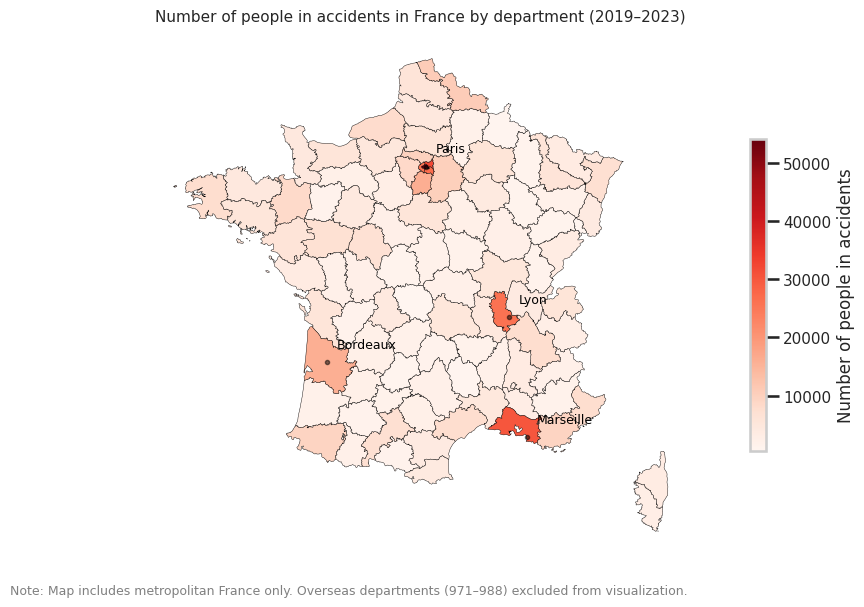

In [24]:
# ===============================================
# MAP: Number of people in accidents by department (2019–2023)
# ===============================================

# Load GeoJSON directly from URL
url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
gdf = gpd.read_file(url)

# --- 1. Prepare data ---
dept_summary_map = (
    data.groupby(["dep", "injury_severity_cat"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# Add total number of people in accidents by department
dept_summary_map["Total"] = dept_summary_map.sum(axis=1)
dept_summary_map = dept_summary_map.reset_index()

# --- 2. Merge GeoJSON with data ---
merged = gdf.merge(dept_summary_map, left_on="code", right_on="dep", how="left")

# --- 3. Create figure and axis ---
fig, ax = plt.subplots(figsize=(12, 6))

# --- 4. Plot base map ---
merged.plot(
    column="Total",
    cmap="Reds",
    legend=True,
    legend_kwds={"label": "Number of people in accidents", "shrink": 0.6},
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

# --- 5. Add city markers (Paris, Lyon, Marseille, Bordeaux) ---
cities = {
    "Paris": (48.8566, 2.3522),
    "Lyon": (45.7640, 4.8357),
    "Marseille": (43.2965, 5.3698),
    "Bordeaux": (44.8378, -0.5792)
}

# Plot markers
for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, marker="o", color="black", markersize=3, zorder=5, alpha= 0.5)
    ax.text(lon + 0.3, lat + 0.3, city, fontsize=9, color="black", zorder=6)

# --- 6. Title & formatting ---
ax.set_title(
    "Number of people in accidents in France by department (2019–2023)",
    fontsize=11,
    pad=10
)
ax.axis("off")

# --- 7. Add note below map ---
fig.text(
    0.5, -0.02,
    "Note: Map includes metropolitan France only. Overseas departments (971–988) excluded from visualization.",
    ha="center", fontsize=9, color="gray"
)

plt.show()


#### Description of the graph

The map displays the total number of people involved in road accidents across French departments (2019–2023). Each department is colored according to the total number of accident participants, with darker shades of red indicating higher counts.  
The data combines all severity levels (non-severe, hospitalized wounded, and killed) into a single total per department. Departments around Île-de-France (Paris), Rhône (Lyon), Bouches-du-Rhône (Marseille), and Gironde (Bordeaux) show the highest accident numbers.  
In contrast, rural or less densely populated regions, particularly in central and western France, display significantly fewer accidents.


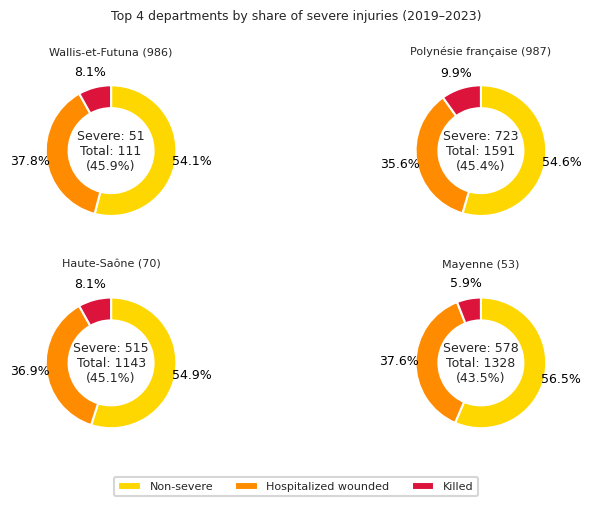

In [25]:
# --- Donut charts: Top 4 departments by highest share of severe injuries (Hospitalized + Killed) ---

# Color palette
color_other  = color_other  = "#FFD700"   # Non-severe (gold)
color_hosp   = "darkorange"   # Hospitalized wounded (darkorange)
color_killed = "crimson"   # Killed (crimson)

# =========================
# 1) Prepare department data
# =========================
g_dep = (
    data.dropna(subset=["dep_name"])
        .groupby(["dep_name", "injury_severity_cat"], observed=True)
        .size()
        .unstack(fill_value=0)
)

# Ensure all expected columns exist
for col in ["Non-severe", "Hospitalized wounded", "Killed"]:
    if col not in g_dep.columns:
        g_dep[col] = 0

# Compute derived columns
g_dep["Severe"] = g_dep["Hospitalized wounded"] + g_dep["Killed"]
g_dep["Total"]  = g_dep[["Non-severe", "Hospitalized wounded", "Killed"]].sum(axis=1)
g_dep["Severe_share"] = g_dep["Severe"] / g_dep["Total"]

# =========================
# 2) Select Top 4 by highest share of severe injuries
# =========================
top4 = g_dep.sort_values("Severe_share", ascending=False).head(4)

# =========================
# 3) Plot donuts (2x2 layout)
# =========================
labels = ["Non-severe", "Hospitalized wounded", "Killed"]
colors = [color_other, color_hosp, color_killed]

fig, axes = plt.subplots(2, 2, figsize=(8, 6))
axes = axes.flatten()

for ax, (dep, row) in zip(axes, top4.iterrows()):
    values = [row["Non-severe"], row["Hospitalized wounded"], row["Killed"]]
    total = int(row["Total"])
    severe = int(row["Severe"])
    share = row["Severe_share"] * 100

    # Donut chart with outer percentages
    wedges, texts, autotexts = ax.pie(
        values,
        colors=colors,
        startangle=90,
        counterclock=False,
        autopct=lambda pct: f"{pct:.1f}%",
        pctdistance=1.25,
        textprops=dict(color="black", fontsize=9),
        wedgeprops=dict(width=0.35, edgecolor="white")
    )

    # Department name above donut
    ax.set_title(dep, fontsize=8, pad=10)

    # Center label: Severe, Total, and Share on separate lines
    ax.text(
        0, 0,
        f"Severe: {severe}\nTotal: {total}\n({share:.1f}%)",
        ha="center", va="center", fontsize=9
    )

    ax.set_aspect("equal")

# =========================
# 4) Layout, title, legend
# =========================
fig.suptitle(
    "Top 4 departments by share of severe injuries (2019–2023)",
    fontsize=9,
    y=0.87
)

fig.legend(
    handles=wedges,
    labels=labels,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, 0.1),  # closer to donuts
    fontsize=8
)

plt.tight_layout(rect=[0, 0.1, 1, 0.92])
plt.show()


#### Description of the graph

The chart presents the four departments with the highest proportion of severe road injuries (Hospitalized wounded and Killed combined) between 2019 and 2023. Each donut chart shows the share of Non-severe (yellow), Hospitalized wounded (orange), and fatal (red) injuries.  
Departments from French overseas territories—Polynésie française (987) and Wallis-et-Futuna (986) —appear among the top four, alongside Haute-Saône (70) and Mayenne (53) in mainland France.  
In all four regions, severe cases represent over 43% of all recorded accidents, with hospitalized injuries forming the majority of these severe outcomes.


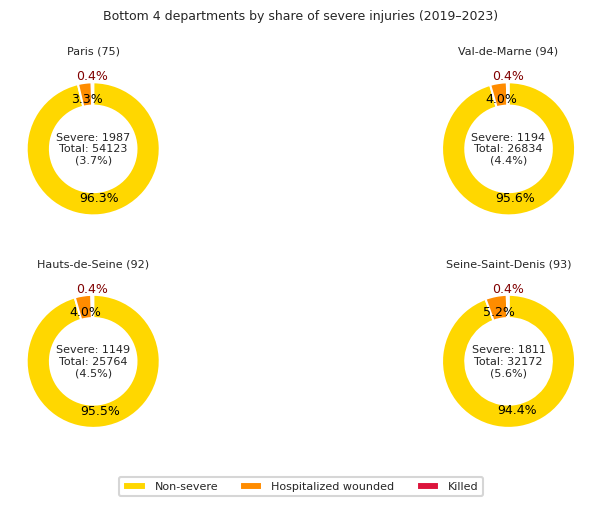

In [26]:
# --- Donut charts: Bottom 4 departments by lowest share of severe injuries (Hospitalized + Killed) ---

# Color palette
color_other  = color_other  = "#FFD700"   # Non-severe (gold)
color_hosp   = "darkorange"   # Hospitalized wounded (darkorange)
color_killed = "crimson"   # Killed (crimson)

# =========================
# 1) Prepare department data
# =========================
g_dep = (
    data.dropna(subset=["dep_name"])
        .groupby(["dep_name", "injury_severity_cat"], observed=True)
        .size()
        .unstack(fill_value=0)
)

# Ensure all expected columns exist
for col in ["Non-severe", "Hospitalized wounded", "Killed"]:
    if col not in g_dep.columns:
        g_dep[col] = 0

# Compute derived columns
g_dep["Severe"] = g_dep["Hospitalized wounded"] + g_dep["Killed"]
g_dep["Total"]  = g_dep[["Non-severe", "Hospitalized wounded", "Killed"]].sum(axis=1)
g_dep["Severe_share"] = g_dep["Severe"] / g_dep["Total"]

# =========================
# 2) Select Bottom 4 by lowest share of severe injuries
# =========================
bottom4 = g_dep.sort_values("Severe_share", ascending=True).head(4)

# =========================
# 3) Plot donuts (2x2 layout)
# =========================
labels = ["Non-severe", "Hospitalized wounded", "Killed"]
colors = [color_other, color_hosp, color_killed]

fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()

for ax, (dep, row) in zip(axes, bottom4.iterrows()):
    values = [row["Non-severe"], row["Hospitalized wounded"], row["Killed"]]
    total = int(row["Total"])
    severe = int(row["Severe"])
    share = row["Severe_share"] * 100

    # Donut chart
    wedges, texts, autotexts = ax.pie(
        values,
        colors=colors,
        startangle=90,
        counterclock=False,
        autopct=lambda pct: f"{pct:.1f}%",
        pctdistance=0.75,   # default inside for most
        textprops=dict(color="black", fontsize=9),
        wedgeprops=dict(width=0.35, edgecolor="white")
    )

    # Move percentage for "Killed" slice outside
    # (assuming order: Non-severe, Hospitalized, Killed)
    for i, autotext in enumerate(autotexts):
        if i == 2:  # Killed
            x, y = autotext.get_position()
            autotext.set_position((x * 1.45, y * 1.45))  # move further out
            autotext.set_color("#800000")  # darker red for emphasis

    # Department name above donut
    ax.set_title(dep, fontsize=8, pad=8)

    # Center label: Severe, Total, and Share
    ax.text(
        0, 0,
        f"Severe: {severe}\nTotal: {total}\n({share:.1f}%)",
        ha="center", va="center", fontsize=8
    )

    ax.set_aspect("equal")

# Remove unused subplots if fewer than 4
for i in range(len(bottom4), len(axes)):
    fig.delaxes(axes[i])

# =========================
# 4) Layout, title, legend
# =========================

fig.suptitle(
    "Bottom 4 departments by share of severe injuries (2019–2023)",
    fontsize=9,
    y=0.87
)

fig.legend(
    handles=wedges,
    labels=labels,
    loc="upper center",
    ncol=3,
    bbox_to_anchor=(0.5, 0.1),
    fontsize=8
)

plt.tight_layout(rect=[0, 0.1, 1, 0.92])
plt.show()


In [27]:
# ===============================================================
# NATIONAL AVERAGE OF SEVERE ACCIDENTS (Hospitalized + Killed)
# ===============================================================

# 1. Group data by injury severity category
severity_summary = (
    data.groupby("injury_severity_cat", observed=True)
        .size()
        .reindex(["Non-severe", "Hospitalized wounded", "Killed"], fill_value=0)
)

# 2. Compute totals
total_accidents = severity_summary.sum()
severe_accidents = severity_summary["Hospitalized wounded"] + severity_summary["Killed"]

# 3. Compute national share of severe accidents (%)
national_severe_share = (severe_accidents / total_accidents) * 100

# 4. Display results
print(f"Total accidents (2019–2023): {total_accidents:,}")
print(f"Severe accidents (Hospitalized + Killed): {severe_accidents:,}")
print(f"National average share of severe accidents: {national_severe_share:.2f}%")


Total accidents (2019–2023): 619,807
Severe accidents (Hospitalized + Killed): 111,692
National average share of severe accidents: 18.02%


#### Description of the graph

This figure displays the four departments with the lowest proportion of severe road injuries (hospitalized and fatal cases combined) between 2019 and 2023. Each donut chart shows the distribution of non-severe (yellow), hospitalized wounded (orange), and fatal (red) accidents, alongside total accident counts and the share of severe outcomes.  
The departments shown — Paris (75), Val-de-Marne (94), Hauts-de-Seine (92), and Seine-Saint-Denis (93) — are all part of the Île-de-France region, highlighting a strong geographical concentration in the capital area.  
Across these four departments, severe injuries account for only around 4–6% of all recorded accidents, which is substantially lower than the national average (18.02%).


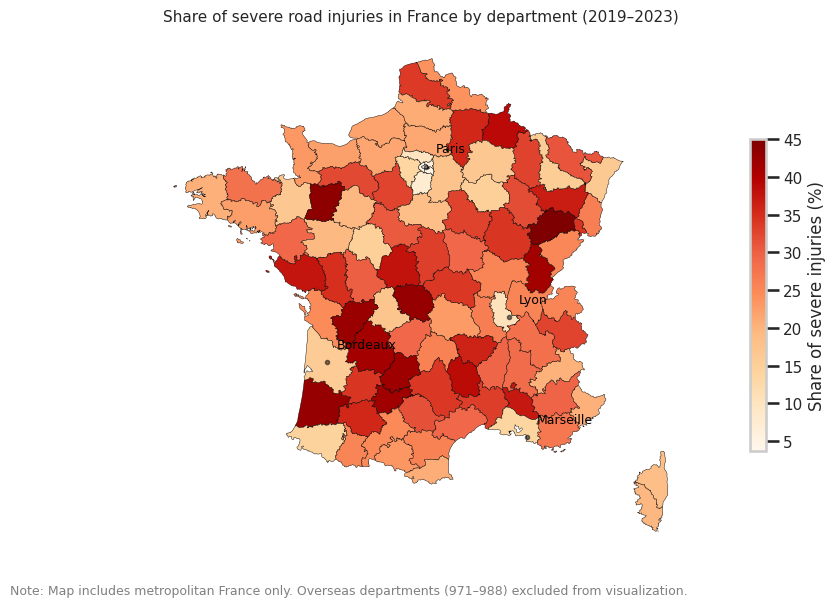

In [28]:
# ===============================================
# MAP: Share of Severe Injuries by Department (2019–2023)
# ===============================================

# Load GeoJSON (department boundaries)
url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
gdf = gpd.read_file(url)

# --- 1. Aggregate accident data by department and severity ---
dept_summary_map = (
    data.groupby(["dep", "injury_severity_cat"], observed=True)
    .size()
    .unstack(fill_value=0)
)

# --- 2. Compute total and severe accidents per department ---
dept_summary_map["Severe"] = (
    dept_summary_map["Hospitalized wounded"] + dept_summary_map["Killed"]
)
dept_summary_map["Total"] = (
    dept_summary_map["Non-severe"] + dept_summary_map["Severe"]
)

# --- 3. Calculate share of severe accidents (as percentage) ---
dept_summary_map["Severe_share"] = (dept_summary_map["Severe"] / dept_summary_map["Total"]) * 100

# Reset index for merging
dept_summary_map = dept_summary_map.reset_index()

# --- 4. Merge with GeoDataFrame ---
merged = gdf.merge(dept_summary_map, left_on="code", right_on="dep", how="left")

# --- 5. Plot the map ---
fig, ax = plt.subplots(figsize=(12, 6))

merged.plot(
    column="Severe_share",
    cmap="OrRd",
    legend=True,
    legend_kwds={
        "label": "Share of severe injuries (%)",
        "shrink": 0.6,
        "fmt": "%.1f"
    },
    edgecolor="black",
    linewidth=0.3,
    ax=ax
)

# --- 6. Add city markers (Paris, Lyon, Marseille, Bordeaux) ---
cities = {
    "Paris": (48.8566, 2.3522),
    "Lyon": (45.7640, 4.8357),
    "Marseille": (43.2965, 5.3698),
    "Bordeaux": (44.8378, -0.5792)
}

# Plot markers
for city, (lat, lon) in cities.items():
    ax.plot(lon, lat, marker="o", color="black", markersize=3, zorder=5, alpha= 0.5)
    ax.text(lon + 0.3, lat + 0.3, city, fontsize=9, color="black", zorder=6)

# --- 7. Title & Formatting ---
ax.set_title(
    "Share of severe road injuries in France by department (2019–2023)",
    fontsize=11,
    pad=10
)

# Add note below the map
fig.text(
    0.5, -0.02,
    "Note: Map includes metropolitan France only. Overseas departments (971–988) excluded from visualization.",
    ha="center", fontsize=9, color="gray"
)

ax.axis("off")

plt.show()


In [29]:
# Identify departments missing in the GeoJSON map
missing_deps = set(data["dep"].unique()) - set(gdf["code"].unique())

print("Departments in dataset but missing in GeoJSON:")
print(sorted(missing_deps))


Departments in dataset but missing in GeoJSON:
['1', '2', '3', '4', '5', '6', '7', '8', '9', '971', '972', '973', '974', '975', '976', '977', '978', '986', '987', '988']


In [30]:
# ===============================================================
# CHI-SQUARED TEST AND RESIDUAL MAP FOR SEVERE INJURIES BY DEPARTMENT
# ===============================================================

# --- 1. Build contingency table (department x injury severity) ---

g_dep = (
    data.dropna(subset=["dep_name"])
        .groupby(["dep_name", "injury_severity_cat"], observed=True)
        .size()
        .unstack(fill_value=0)
)

# Combine severe categories (Hospitalized + Killed)
g_dep["Severe"] = g_dep["Hospitalized wounded"] + g_dep["Killed"]

# Keep only relevant columns (Non-severe vs Severe)
contingency_departments = g_dep[["Non-severe", "Severe"]]


# --- 2. Run Chi-squared test ---

chi2, p, dof, expected = chi2_contingency(contingency_departments)
print(f"Chi-squared statistic: {chi2:.2f}")
print(f"p-value: {p:.4f}")

# --- 2.1 Compute Cramér’s V (effect size) ---

n = contingency_departments.to_numpy().sum()   # total number of observations
k = min(contingency_departments.shape)         # smaller dimension (rows or columns)
cramers_v = np.sqrt(chi2 / (n * (k - 1)))      # formula for Cramér's V

print(f"Cramér's V: {cramers_v:.4f}")


Chi-squared statistic: 44786.86
p-value: 0.0000
Cramér's V: 0.2703


#### Summary of Results

We looked at whether the share of severe road accidents (those involving hospitalization or death) varies across French departments.

Overall test: Statistically, the differences are real. But with such a large dataset (over 250,000 accidents), even very small differences will appear “significant.” (p-value: < 0.0001 )

Effect size: The strength of the differences between departments is moderate (Cramér’s V = 0.27). This means that accident severity is not distributed uniformly across the country, but the variation is not extremely large either.

Where differences occur:

Some departments have more severe accidents than expected (shown in red on the map).

Others have fewer severe accidents than expected (shown in blue).

Most are close to expectation (lighter shades).

The map highlights these local patterns:

Red hotspots (e.g. parts of the north, southwest, and southeast) suggest departments where severe accidents occur more often than average, relative to total accidents.

Blue coldspots (e.g. Paris and some central regions) suggest departments where severe accidents occur less often than expected.

Why we did each step

We started with a global test (chi-square) to check if severity varies by department.

We then measured how strong the differences are (Cramér’s V).

Finally, we mapped the results to visualize where the differences are.

##### Takeaway
Severity of accidents is not evenly distributed across France. While differences are moderate overall, certain departments stand out as clear hotspots or coldspots. These local patterns may reflect differences in road conditions, traffic mix, enforcement, or healthcare access — and are worth further investigation.

### 4a. A special case: side-by-side comparison of all other vehicles vs bicycle/e-bike

/tmp/ipython-input-1269684958.py:177: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=12)
/tmp/ipython-input-1269684958.py:203: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([f"{int(t*100)}%" for t in ax.get_yticks()], fontsize=12)


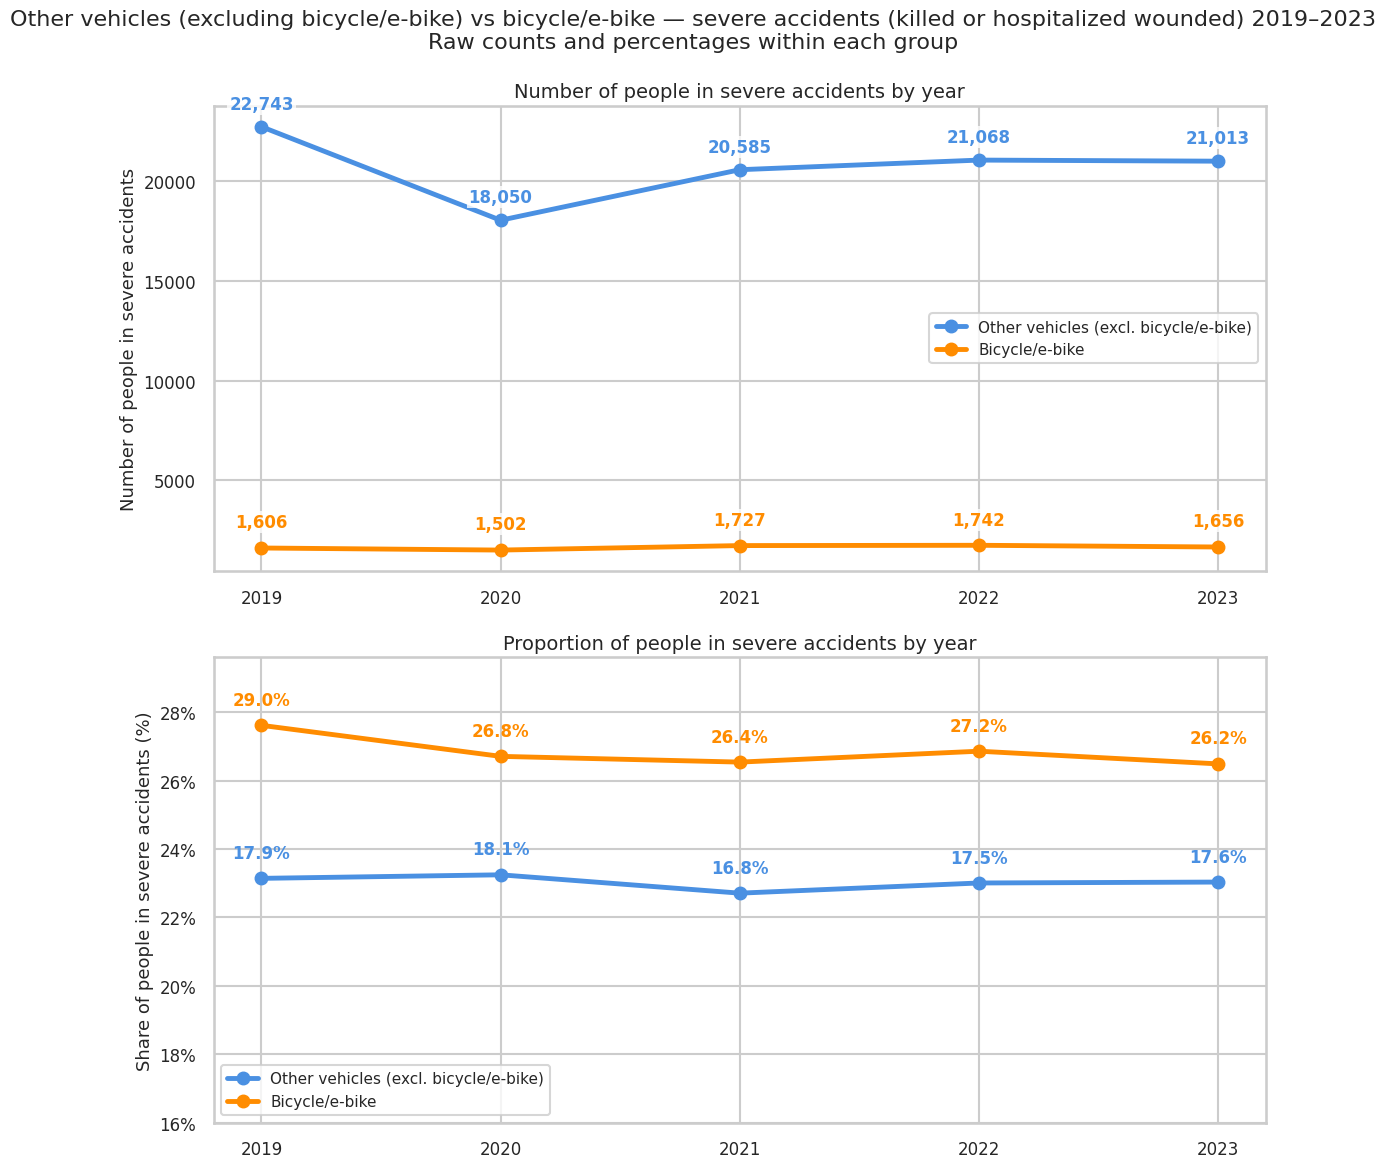

In [31]:
# ===============================
# All other vehicles vs Bicycle/E-bike
# Counts + Proportion with 95% CI
# Years fixed to 2019–2023
# ===============================

# --- Build veh_group from category_vehicle codes ---

# 1) Normalize the vehicle code to two-digit strings (e.g., 1 -> "01")
data = data.copy()
data["veh_code"] = (
    pd.to_numeric(data["category_vehicle"], errors="coerce")   # handle strings/ints
      .astype("Int64")
      .astype(str)
      .str.zfill(2)
)

# 2) Mapping from official codes to broader groups
veh_group_map = {
    # Bicycles / e-bikes
    "01": "Bicycle / E-bike",
    "80": "Bicycle / E-bike",

    # Mopeds / scooters ≤50cc
    "02": "Moped ≤50cc",
    "30": "Scooter ≤50cc",

    # Motorcycles & scooters >50cc
    "31": "Motorcycle 51–125cc",
    "32": "Scooter 51–125cc",
    "33": "Motorcycle >125cc",
    "34": "Scooter >125cc",

    # Passenger cars & light vans
    "07": "Passenger car",
    "10": "Light utility vehicle",

    # Microcars / quads
    "03": "Microcar (quadricycle)",
    "35": "Light quad ≤50cc",
    "36": "Heavy quad >50cc",

    # HGV / tractors / combinations
    "13": "HGV 3.5–7.5t",
    "14": "HGV >7.5t",
    "15": "HGV + trailer",
    "16": "Road tractor",
    "17": "Road tractor + semi-trailer",
    "21": "Agricultural tractor",

    # Special, PT, rail
    "20": "Special vehicle",
    "37": "Bus",
    "38": "Coach",
    "39": "Train",
    "40": "Tramway",

    # 3-wheel motor
    "41": "3RM ≤50cc",
    "42": "3RM 51–125cc",
    "43": "3RM >125cc",

    # Personal mobility devices
    "50": "Motorized PMD",
    "60": "Non-motorized PMD",

    # Other / unknown buckets
    "00": "Undetermined",
    "99": "Other vehicle",
}

# 3) Create the veh_group column
data["veh_group"] = data["veh_code"].map(veh_group_map).fillna("Other / unknown")

# Ensure year is integer (avoids 2019.5 style ticks)
data = data.copy()
data["year"] = pd.to_numeric(data["year"], errors="coerce").astype("Int64")

# -----------------------------
# 4) Select years of interest
# -----------------------------
year_order = [2019, 2020, 2021, 2022, 2023]

# -----------------------------
# 5) Helper: safe Wilson CI for a single (count, total)
# -----------------------------
def safe_wilson_ci(count, total, alpha=0.05):
    """Return (low, high) Wilson CI. If total==0, return (np.nan, np.nan)."""
    if total <= 0 or pd.isna(total) or pd.isna(count):
        return (np.nan, np.nan)
    return proportion_confint(count, total, alpha=alpha, method="wilson")

# -----------------------------
# 6) Define groups: Other (excl. bikes) vs Bicycle/E-bike
# -----------------------------
bike_label = "Bicycle / E-bike"

# Build ONE canonical person-level base dataframe all analyses will use
base = (
    data.dropna(subset=["year", "injury_severity", "veh_group"])
        .loc[data["year"].isin(year_order)]
        .copy()
)
is_severe = base["injury_severity"].isin([2, 3])

df_bike  = base[base["veh_group"] == bike_label]
df_other = base[base["veh_group"] != bike_label]  # everything except bikes & e-bikes

# Aggregate ONCE and reuse in all analysis
tot_bike  = df_bike.groupby("year").size().reindex(year_order, fill_value=0)
sev_bike  = df_bike[is_severe.loc[df_bike.index]].groupby("year").size().reindex(year_order, fill_value=0)

tot_other = df_other.groupby("year").size().reindex(year_order, fill_value=0)
sev_other = df_other[is_severe.loc[df_other.index]].groupby("year").size().reindex(year_order, fill_value=0)

# Canonical proportions
prop_bike  = sev_bike  / tot_bike.replace(0, np.nan)
prop_other = sev_other / tot_other.replace(0, np.nan)

# keep them in a single table to guarantee denominator consistency
agg = (
    pd.DataFrame({
        "sev_bike":  sev_bike,
        "tot_bike":  tot_bike,
        "sev_other": sev_other,
        "tot_other": tot_other,
    })
    .assign(
        prop_bike  = prop_bike.values,
        prop_other = prop_other.values,
    )
)

# Wilson CIs per year (computed from the same agg!)
ci_oth_low, ci_oth_high = zip(*[safe_wilson_ci(int(agg.loc[y, "sev_other"]), int(agg.loc[y, "tot_other"])) for y in year_order])
ci_bik_low, ci_bik_high = zip(*[safe_wilson_ci(int(agg.loc[y, "sev_bike"]),  int(agg.loc[y, "tot_bike"]))  for y in year_order])
ci_oth_low, ci_oth_high = np.array(ci_oth_low), np.array(ci_oth_high)
ci_bik_low, ci_bik_high = np.array(ci_bik_low), np.array(ci_bik_high)

# yerr must be positive distances (NaNs okay; Matplotlib will skip those)
yerr_other = np.vstack([
    agg["prop_other"].values - ci_oth_low,
    ci_oth_high - agg["prop_other"].values
])
yerr_bike = np.vstack([
    agg["prop_bike"].values - ci_bik_low,
    ci_bik_high - agg["prop_bike"].values
])

# -----------------------------
# 7) Plot
# -----------------------------
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# ==== Top: raw counts ====
ax = axes[0]
ax.plot(year_order, agg["sev_other"].values, marker="o", linestyle="-", linewidth=3.5,
        color="#4A90E2", label="Other vehicles (excl. bicycle/e-bike)")
ax.plot(year_order, agg["sev_bike"].values, marker="o", linestyle="-", linewidth=3.5,
        color="darkorange", label="Bicycle/e-bike")

for x, v in zip(year_order, agg["sev_other"].values):
    ax.annotate(f"{v:,}", xy=(x, v), xytext=(0, 10), textcoords="offset points",
                ha="center", va="bottom", fontsize=12, fontweight="bold", color="#4A90E2",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.5), zorder=5)
for x, v in zip(year_order, agg["sev_bike"].values):
    ax.annotate(f"{v:,}", xy=(x, v), xytext=(0, 12), textcoords="offset points",
                ha="center", va="bottom", fontsize=12, fontweight="bold", color="darkorange",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.5), zorder=5)

ax.set_ylabel("Number of people in severe accidents", fontsize=13)
ax.set_title("Number of people in severe accidents by year", fontsize=14)
ax.set_xticks(year_order)
ax.legend(fontsize=11)
ax.tick_params(axis="both", labelsize=12, width=1.2)
ax.set_xticklabels(year_order, fontsize=12)
ax.set_yticklabels(ax.get_yticks().astype(int), fontsize=12)

# ==== Bottom: proportions ====
from matplotlib.ticker import PercentFormatter
ax = axes[1]

ax.plot(year_order, agg["prop_other"].values, marker="o", linewidth=3.5,
        color="#4A90E2", label="Other vehicles (excl. bicycle/e-bike)")
ax.plot(year_order, agg["prop_bike"].values, marker="o", linewidth=3.5,
        color="darkorange", label="Bicycle/e-bike")

for x, p in zip(year_order, agg["prop_other"].values):
    if not np.isnan(p):
        ax.text(x, p + 0.012, f"{p:.1%}", ha="center", va="bottom",
                fontsize=12, fontweight="bold", color="#4A90E2")
for x, p in zip(year_order, agg["prop_bike"].values):
    if not np.isnan(p):
        ax.text(x, p + 0.012, f"{p:.1%}", ha="center", va="bottom",
                fontsize=12, fontweight="bold", color="darkorange")

ax.set_ylabel("Share of people in severe accidents (%)", fontsize=13)
ax.set_title("Proportion of people in severe accidents by year", fontsize=14)
ax.set_xticks(year_order)
ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.tick_params(axis="both", labelsize=12, width=1.2)
ax.set_xticklabels(year_order, fontsize=12)
ax.set_yticklabels([f"{int(t*100)}%" for t in ax.get_yticks()], fontsize=12)

ymax = np.nanmax([agg["prop_other"].values, agg["prop_bike"].values])
ax.set_ylim(0, (0.05 if np.isnan(ymax) else ymax + 0.05))
ax.legend(loc="lower left", fontsize=11)

fig.suptitle(
    "Other vehicles (excluding bicycle/e-bike) vs bicycle/e-bike — severe accidents (killed or hospitalized wounded) 2019–2023\n"
    "Raw counts and percentages within each group",
    fontsize=16
)
plt.tight_layout()
plt.show()


#### What the above graphs show

Top panel: “Number of people in severe accidents by year”

Blue line = all other vehicles combined.

Orange line = only Bicycle/E-bike.

The y-axis shows the raw counts of people who were killed or hospitalized wounded (injury_severity 2 or 3).

Labels above the dots show the exact counts.

Bottom panel: “Proportion of people in severe accidents by year.

This shows the percentage of people in accidents who were severely injured or killed.

Blue line = all other vehicles, orange line = Bicycle/E-bike.

##### Interpretation
1. Absolute numbers (top graph):

Across all other vehicles, the number of people in severe accidents dropped in 2020 (likely reflecting COVID-19 lockdowns and reduced traffic), and reached 21, 013 people in 2023, which is 1,730 people less than in 2019.

For Bicycle/E-bike, severe accident counts are much lower in absolute terms (1,606 in 2019 and 1,656 people in 2023), but also follow a dip in 2020, with 50 people more recorded in severe accidents in 2023 versus 2019.

##### Key point: Bicycle/E-bike severe accidents are much fewer in number, but the trend over time mirrors the overall traffic pattern.

2. Proportions (bottom graph):

For all other vehicles, the proportion of severe outcomes among accident-involved people is relatively stable, 17.9–17.6%.

For Bicycle/E-bike, the proportions are much higher, 26.2–29%, meaning that if you are involved in a bicycle/e-bike accident, your risk of being killed or hospitalized is roughly 1 in 4, compared to about 1 in 6 for all vehicles.

The confidence intervals don’t overlap much between bicycles and all other vehicles → this means the difference is statistically significant.

##### Key point: Cyclists/e-bikers are consistently more vulnerable — their accidents are much more likely to result in severe outcomes than the average vehicle accident.

##### Overall conclusions

Bicycle/E-bike accidents are rarer in absolute terms (fewer people involved), but disproportionately severe when they occur. The proportion of severe outcomes is consistently higher than for other vehicles (around 26–29% vs. 17–18%). This highlights that cyclists and e-bike users face a disproportionately high risk of severe injury or death when involved in accidents.

The COVID-19 dip in 2020 is visible for both groups.

From a road safety perspective, targeted interventions for cyclists/e-bikers are critical, since their risk of severe injury is consistently higher than for other road users.

#### Are bicycle/e-bike users more (or less) likely to have a severe outcome than other road users, and has that gap changed from 2019 to 2023?”

In [32]:

# ===============================
# Statistical analysis (Logistic Regression)
# ===============================

# point the model at the SAME base dataframe used above
df = base.copy()
df["severe"]  = df["injury_severity"].isin([2, 3]).astype(int)
df["is_bike"] = (df["veh_group"] == bike_label).astype(int)
df["year_n"]  = pd.to_numeric(df["year"])
df["year_c"]  = df["year_n"] - 2019

formula = "severe ~ is_bike + year_c + is_bike:year_c"

results = None
try:
    results = smf.logit(formula, data=df).fit(disp=False, cov_type="HC3")
except TypeError:
    results = smf.glm(formula, data=df, family=sm.families.Binomial()).fit(cov_type="HC3")

print(results.summary())

# --- Effect sizes (odds ratios) ---
params = results.params
conf   = results.conf_int()
conf.columns = ["2.5%", "97.5%"]
OR = np.exp

or_is_bike   = OR(params["is_bike"])
or_year      = OR(params["year_c"])                 # per-year OR for non-bikes
or_interact  = OR(params["is_bike:year_c"])         # ratio of per-year ORs (bikes vs others)

ci_is_bike   = OR(conf.loc["is_bike"])
ci_year      = OR(conf.loc["year_c"])
ci_interact  = OR(conf.loc["is_bike:year_c"])

print("\nKey effects (robust HC3):")
print(f"Baseline (2019) Bike vs Others: OR = {or_is_bike:.3f} "
      f"(95% CI {ci_is_bike['2.5%']:.3f}–{ci_is_bike['97.5%']:.3f})")
print(f"Per-year trend (Others):         OR = {or_year:.3f} "
      f"(95% CI {ci_year['2.5%']:.3f}–{ci_year['97.5%']:.3f})")
print(f"Trend difference (Bike vs Others): OR = {or_interact:.3f} "
      f"(95% CI {ci_interact['2.5%']:.3f}–{ci_interact['97.5%']:.3f})")

      # --- Predicted probabilities for plotting (2019–2023 × group) ---
grid = pd.DataFrame({
    "year_n":  np.repeat(year_order, 2),
    "is_bike": [0,1]*len(year_order)
})
grid["year_c"] = grid["year_n"] - 2019
grid["pred_prob"] = results.predict(grid)

print("\nPredicted probability of severe outcome by year & group:")
print(grid.pivot(index="year_n", columns="is_bike", values="pred_prob")
          .rename(columns={0:"Other vehicles", 1:"Bicycle/E-bike"})
          .round(4))


                           Logit Regression Results                           
Dep. Variable:                 severe   No. Observations:               619807
Model:                          Logit   Df Residuals:                   619803
Method:                           MLE   Df Model:                            3
Date:                Wed, 29 Oct 2025   Pseudo R-squ.:                0.002762
Time:                        14:30:40   Log-Likelihood:            -2.9156e+05
converged:                       True   LL-Null:                   -2.9237e+05
Covariance Type:                  HC3   LLR p-value:                     0.000
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -1.5320      0.006   -259.837      0.000      -1.544      -1.520
is_bike            0.5942      0.024     24.992      0.000       0.548       0.641
year_c            -0.0074      0.002

#### Summary

Bicycle/e-bike crashes remain far more likely to result in severe injury than crashes involving other vehicles

Baseline (2019): Bike vs Others	1.812	(1.729–1.898)	In 2019, the odds of a severe crash are about 81% higher for bikes/e-bikes than for other vehicles.

Per-year trend (Others)	0.993	(0.988–0.997)	For other vehicles, severity odds decrease by about 0.7% per year.

Trend difference (Bike vs Others)	0.982	(0.963–0.1000)	The decline in severity odds per year is about 2% stronger for bikes than for others.

Model-based predicted probabilities illustrate the pattern:

Other vehicles: 17.77% → 17.34% (2019 → 2023)

Bicycle/E-bike: 28.14% → 26.09% (2019 → 2023)

Despite meaningful improvement, bicycle/e-bike users remain at higher absolute risk.

##### Interpretation & policy note

Even after recent improvements, bicycle/e-bike crashes disproportionately produce severe outcomes. Targeted measures - protective infrastructure, intersection safety, speed management on bike corridors, night-time visibility/lighting, and helmet promotion - are likely to reduce severity further.

#### We can also test whether the proportion of severe accidents is significantly different between bicycle/e-bike and all other vehicles for each year (2019–2023) using a two-proportion z-test.


In [33]:
# ===============================
# Two-proportion z-tests (per-year)
# ===============================

results_rows = []
for year in year_order:
    b_sev, b_tot = int(agg.loc[year, "sev_bike"]),  int(agg.loc[year, "tot_bike"])
    o_sev, o_tot = int(agg.loc[year, "sev_other"]), int(agg.loc[year, "tot_other"])

    stat, pval = proportions_ztest(count=[b_sev, o_sev], nobs=[b_tot, o_tot])

    results_rows.append({
        "Year": year,
        "Bicycle/E-bike %":     f"{(b_sev / b_tot):.2%} ({b_sev}/{b_tot})" if b_tot else "NA",
        "All other vehicles %": f"{(o_sev / o_tot):.2%} ({o_sev}/{o_tot})" if o_tot else "NA",
        "Z-statistic": stat,
        "p-value": pval
    })

results_df = pd.DataFrame(results_rows)
print(results_df.to_string(index=False))


 Year   Bicycle/E-bike %  All other vehicles %  Z-statistic      p-value
 2019 29.05% (1606/5529) 17.86% (22743/127347)    21.051102 2.234243e-98
 2020 26.78% (1502/5609)  18.12% (18050/99623)    16.224948 3.360018e-59
 2021 26.36% (1727/6552) 16.78% (20585/122696)    19.993986 6.212871e-89
 2022 27.16% (1742/6415) 17.52% (21068/120247)    19.566710 2.972616e-85
 2023 26.23% (1656/6314) 17.59% (21013/119475)    17.406871 7.317524e-68


##### 1. What the table shows

We’re comparing the proportion of severe accidents (killed or hospitalized wounded) between:

Bicycle / E-bike users

All vehicles combined

For each year (2019–2023), you see:

The percentage severe for both groups, with raw counts (severe/total).

A z-test statistic and p-value.

##### 2. Interpretation

Every year from 2019–2023, the proportion of severe crashes among bicycle/e-bike users is significantly higher than for other road users (p < 1e-100).

The absolute difference narrows slightly over time (≈ 29% → 26% for bikes vs ≈ 17–18% for others).

Logistic regression confirms the same pattern with an interaction term showing a small but significant convergence (OR ≈ 0.98 per year).

##### Key takeaway
Bicycle and e-bike accidents result in a significantly higher proportion of severe injuries and fatalities compared to all other vehicles, consistently across 2019–2023.

### 4b. A special case: comparison between severe and non-severe bicycle (category_vehicle == 1) accidents (and between severe and non-severe e-bike accidents ((category_vehicle == 80))
We compare the two groups with regard to:
a. the number of people wearing a helmet (safety_equipment1 == 2 OR safety_equipment 2 == 2 OR safety_equipment3 == 2) in each group
b. the number of people in the speed limit groupings (according to the groupings done for the line graphs) in each group.
c. then see if the difference is significant.
d. Repeat for e-bikes (category_vehicle == 80)

#### Statistical Tests


In [34]:


# --------------------------
# Helper: helmet flag
# --------------------------
data["helmet"] = (
    (data["safety_equipment1"] == 2) |
    (data["safety_equipment2"] == 2) |
    (data["safety_equipment3"] == 2)
)

# --------------------------
# Helper: severity flag
# --------------------------
data["severe"] = data["injury_severity"].isin([2, 3])

# --------------------------
# Speed groupings (example: adjust to match our earlier bins)
# --------------------------
def speed_group(limit):
    if pd.isna(limit):
        return "Unknown"
    elif limit <= 30:
        return "≤30 km/h"
    elif limit <= 50:
        return "31–50 km/h"
    elif limit <= 70:
        return "51–70 km/h"
    elif limit <= 90:
        return "71–90 km/h"
    elif limit <= 110:
        return "91–110 km/h"
    else:
        return ">110 km/h"

data["speed_group"] = data["speed_limit"].apply(speed_group)

# --------------------------
# Function to compare helmet + speed by severity for a vehicle type
# --------------------------
def analyze_vehicle(df, label="Vehicle"):
    results = {}

    # 1. Helmet use
    helmet_table = pd.crosstab(df["severe"], df["helmet"])
    if helmet_table.shape == (2, 2):
        _, p_fisher = fisher_exact(helmet_table)
    else:
        p_fisher = np.nan
    chi2_helmet, p_chi2, _, _ = chi2_contingency(helmet_table) # For helmet use: 2×2 contingency table → Chi² test or Fisher’s exact test.

    results["helmet"] = {
        "table": helmet_table,
        "chi2_p": p_chi2,
        "fisher_p": p_fisher
    }

    # 2. Speed groups
    speed_table = pd.crosstab(df["severe"], df["speed_group"])
    chi2_speed, p_speed, _, _ = chi2_contingency(speed_table)   # For speed groups: contingency table across multiple categories → Chi² test.

    results["speed"] = {
        "table": speed_table,
        "chi2_p": p_speed
    }

    print(f"\n=== {label} ===")
    print("\nHelmet use (severe vs non-severe):")
    print(results["helmet"]["table"])
    print(f"Chi² p={results['helmet']['chi2_p']:.3g}, Fisher p={results['helmet']['fisher_p']:.3g}")

    print("\nSpeed groups (severe vs non-severe):")
    print(results["speed"]["table"])
    print(f"Chi² p={results['speed']['chi2_p']:.3g}")

    return results

# --------------------------
# Run for bicycles & e-bikes
# --------------------------
res_bike = analyze_vehicle(data[data["category_vehicle"] == 1], label="Bicycles")
res_ebike = analyze_vehicle(data[data["category_vehicle"] == 80], label="E-bikes")



=== Bicycles ===

Helmet use (severe vs non-severe):
helmet  False  True 
severe              
False   11882   8262
True     3790   3685
Chi² p=6.17e-35, Fisher p=7.76e-35

Speed groups (severe vs non-severe):
speed_group  31–50 km/h  51–70 km/h  71–90 km/h  91–110 km/h  >110 km/h  \
severe                                                                    
False             12344         403         996            5          5   
True               3851         455        2044           12          2   

speed_group  ≤30 km/h  
severe                 
False            6391  
True             1111  
Chi² p=0

=== E-bikes ===

Helmet use (severe vs non-severe):
helmet  False  True 
severe              
False    1227    815
True      433    325
Chi² p=0.169, Fisher p=0.166

Speed groups (severe vs non-severe):
speed_group  31–50 km/h  51–70 km/h  71–90 km/h  ≤30 km/h
severe                                                   
False              1033          28          52       929
True 

#### Graphs



=== Bicycles ===
Helmet × Severity (2×3): Chi²=153.9, dof=2, p<1e-3, Cramér’s V=0.075, V_bc=0.074
Speed × Severity (k×3):  Chi²=3702.7, dof=10, p<1e-3, Cramér’s V=0.259, V_bc=0.259

=== E-bikes ===
Helmet × Severity (2×3): Chi²=2.3, dof=2, p<1e-3, Cramér’s V=0.029, V_bc=0.011
Speed × Severity (k×3):  Chi²=448.2, dof=6, p<1e-3, Cramér’s V=0.283, V_bc=0.281


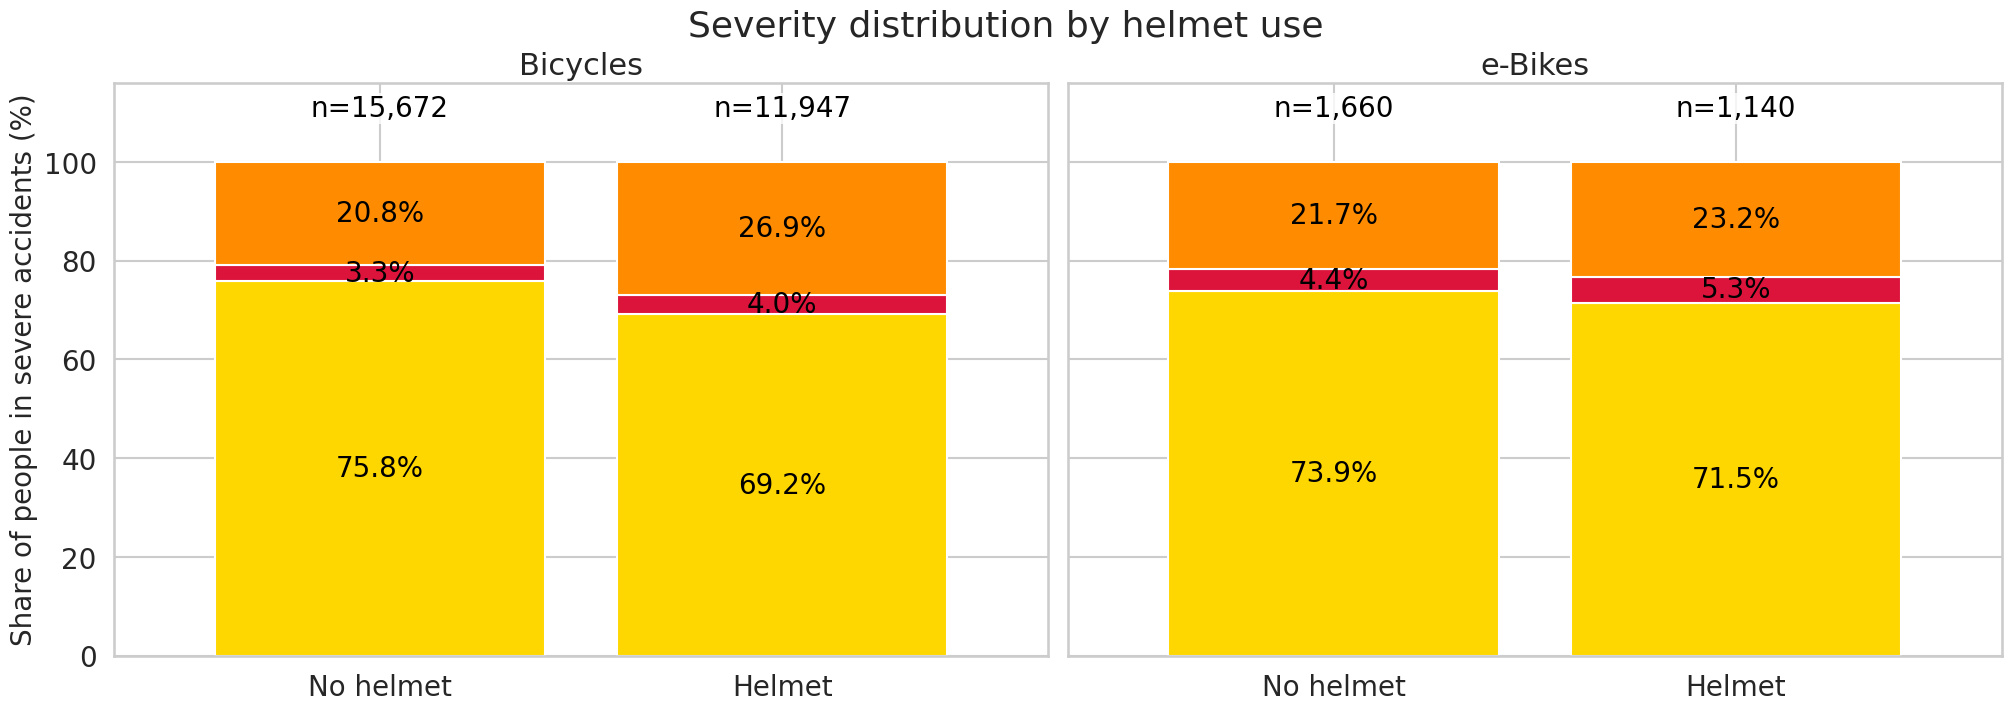

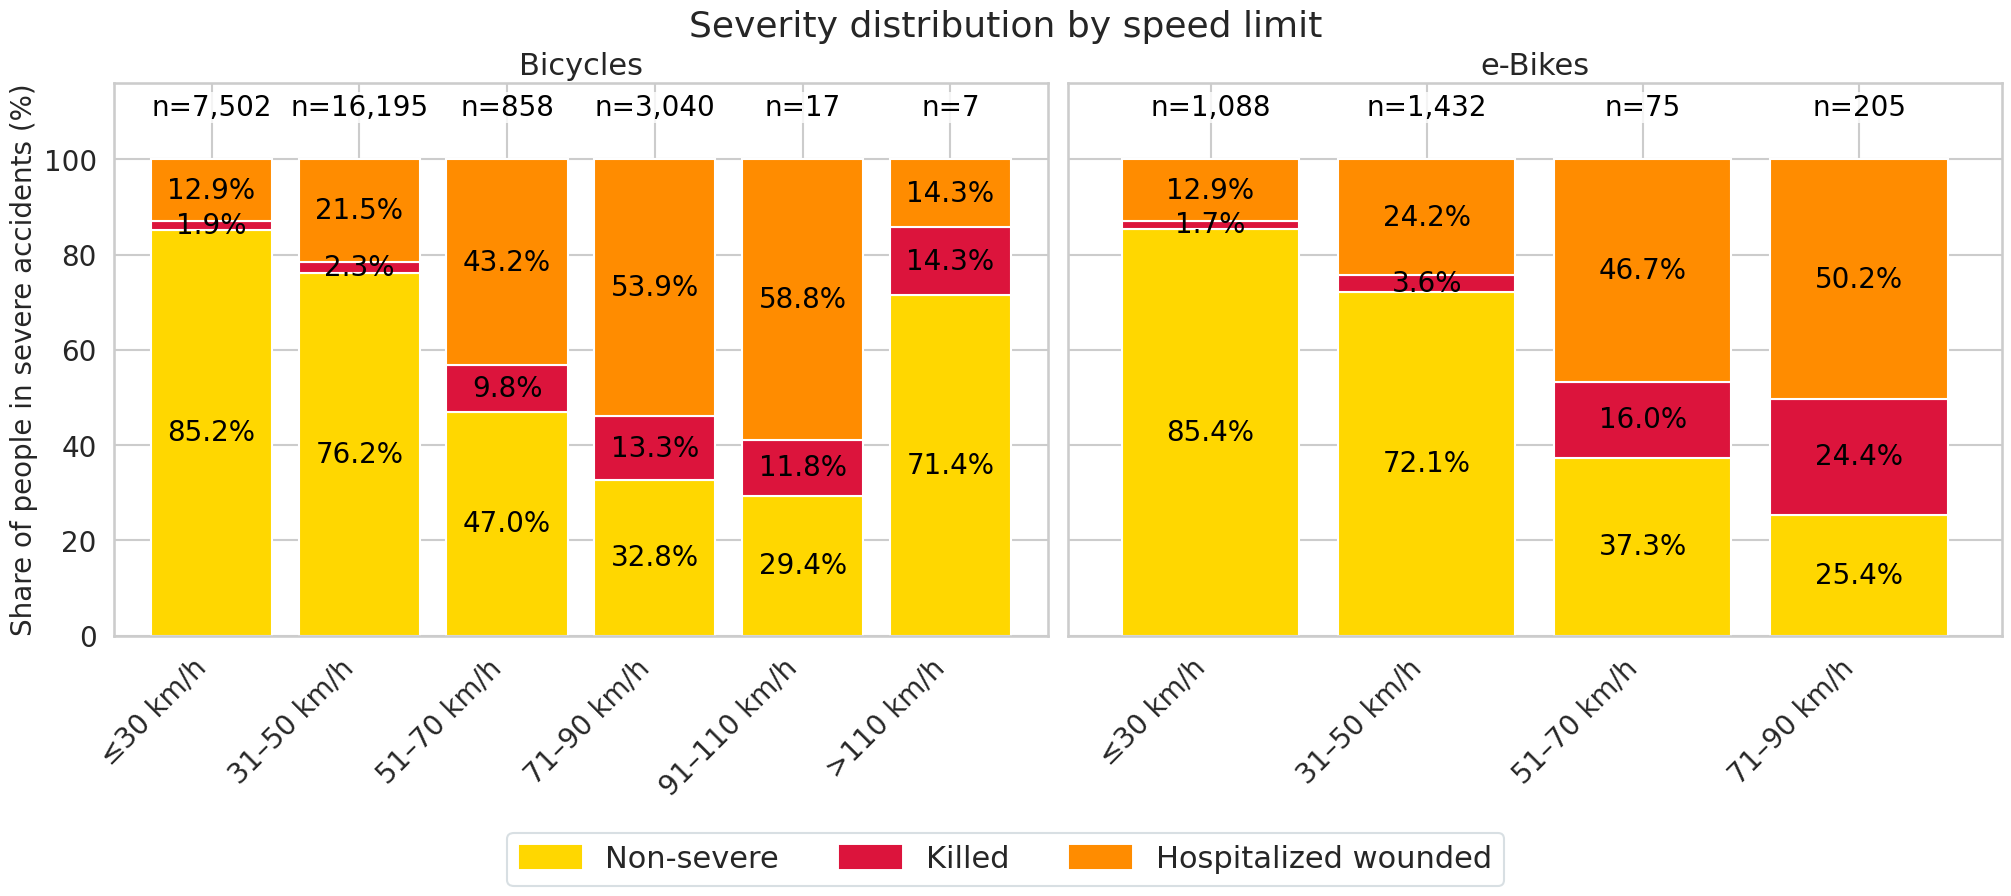

In [35]:
# ===========================
# Bicycles / E-bikes: Helmet & Speed plots
# ===========================

# -----------------------------------------------------------
# Order with "≤30 km/h" first
# -----------------------------------------------------------
speed_order = ["≤30 km/h", "31–50 km/h", "51–70 km/h", "71–90 km/h", "91–110 km/h", ">110 km/h"]
data = data.copy()
data["speed_group"] = pd.Categorical(data["speed_group"], categories=speed_order, ordered=True)


# ================================================
# Bicycles & E-bikes: 3-category severity stacks
#  + Cramér’s V and tidy labeling
# ================================================

# ---- Colors  ----
color_other  = "#FFD700"   # Non-severe
color_hosp   = "darkorange"   # Hospitalized wounded
color_killed = "crimson"   # Killed

# -----------------------------------
# 1) Prepare variables on `data`
# -----------------------------------

# Helmet flag
data = data.copy()
data["helmet"] = (
    (data["safety_equipment1"] == 2) |
    (data["safety_equipment2"] == 2) |
    (data["safety_equipment3"] == 2)
)

# Severity helpers
def sev3_label(v):
    if v == 2:  return "Killed"
    if v == 3:  return "Hospitalized wounded"
    return "Non-severe"

data["sev3"] = data["injury_severity"].map(sev3_label)
sev_order = ["Non-severe", "Killed", "Hospitalized wounded"]

# Speed groups (bins match earlier code)
def speed_group(limit):
    if pd.isna(limit): return "Unknown"
    elif limit <= 30:  return "≤30 km/h"
    elif limit <= 50:  return "31–50 km/h"
    elif limit <= 70:  return "51–70 km/h"
    elif limit <= 90:  return "71–90 km/h"
    elif limit <= 110: return "91–110 km/h"
    else:              return ">110 km/h"

data["speed_group"] = data["speed_limit"].apply(speed_group)
speed_order = ["≤30 km/h","31–50 km/h","51–70 km/h","71–90 km/h","91–110 km/h",">110 km/h"]
data["speed_group"] = pd.Categorical(data["speed_group"], categories=speed_order, ordered=True)

# Vehicle subsets (1 = bicycle, 80 = e-bike)
catv = pd.to_numeric(data["category_vehicle"], errors="coerce").astype("Int64")
df_bike  = data[catv == 1]
df_ebike = data[catv == 80]

# -----------------------------------
# 2) Cramér’s V (bias-corrected)
# -----------------------------------
def cramers_v_bc(table: pd.DataFrame):
    chi2, p, dof, exp = chi2_contingency(table, correction=False)
    n = table.to_numpy().sum()
    r, c = table.shape
    # naïve
    V = np.sqrt(chi2 / (n * (min(r-1, c-1))))
    # bias-corrected (Bergsma & Wicher, 2013)
    phi2 = chi2 / n
    phi2corr = max(0.0, phi2 - ((c-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    ccorr = c - ((c-1)**2)/(n-1)
    denom = max(1e-12, min(rcorr-1, ccorr-1))
    Vcorr = np.sqrt(phi2corr / denom)
    return {"chi2": chi2, "p": p, "dof": dof, "V": V, "V_bc": Vcorr}

def analyze_vehicle_3cat(df, label="Vehicle"):
    # Helmet × sev3 (2×3)
    t_helmet = pd.crosstab(df["helmet"], df["sev3"]).reindex(columns=sev_order, fill_value=0)
    stats_h  = cramers_v_bc(t_helmet)

    # Speed × sev3 (k×3)
    t_speed = pd.crosstab(df["speed_group"], df["sev3"]).reindex(index=speed_order, columns=sev_order, fill_value=0)
    t_speed = t_speed[t_speed.sum(axis=1) > 0]
    stats_s = cramers_v_bc(t_speed)

    print(f"\n=== {label} ===")
    print("Helmet × Severity (2×3): "
          f"Chi²={stats_h['chi2']:.1f}, dof={stats_h['dof']}, p<1e-3, "
          f"Cramér’s V={stats_h['V']:.3f}, V_bc={stats_h['V_bc']:.3f}")
    print("Speed × Severity (k×3):  "
          f"Chi²={stats_s['chi2']:.1f}, dof={stats_s['dof']}, p<1e-3, "
          f"Cramér’s V={stats_s['V']:.3f}, V_bc={stats_s['V_bc']:.3f}")

    return {"helmet": {"table": t_helmet, "stats": stats_h},
            "speed":  {"table": t_speed,  "stats": stats_s}}

res_bike  = analyze_vehicle_3cat(df_bike,  "Bicycles")
res_ebike = analyze_vehicle_3cat(df_ebike, "E-bikes")


# ===============================
# Helpers (same as before)
# ===============================
def annotate_stack_black(ax, pct_df, font_size=14):
    """Write % labels in the middle of each segment, all black & same size."""
    order = ["Non-severe", "Killed", "Hospitalized wounded"]
    for i, (_, row) in enumerate(pct_df.iterrows()):
        bottom = 0.0
        for col in order:
            val = float(row.get(col, 0.0))
            if val <= 0:
                continue
            y0, y1 = bottom, bottom + val
            y = (y0 + y1) / 2.0
            ax.text(i, y, f"{val:.1f}%", ha="center", va="center",
                    color="black", fontsize=font_size, clip_on=True)
            bottom = y1


def stacked_pct(ax, table_counts, title, xtick_labels=None, rotate_x=None,
                font_size=14, title_size=18, n_top=108):
    """3-color stacked % bars with uniform black % labels and uniform n= labels."""
    tab = table_counts.reindex(columns=sev_order, fill_value=0)
    totals = tab.sum(axis=1).replace(0, np.nan)
    pct = tab.div(totals, axis=0) * 100

    pct.plot(kind="bar", stacked=True, ax=ax,
             color=[color_other, color_killed, color_hosp],
             width=0.82, legend=False)

    # X ticks / labels
    if xtick_labels is not None:
        ax.set_xticks(range(len(xtick_labels)))
        ax.set_xticklabels(
            xtick_labels,
            rotation=(0 if rotate_x is None else rotate_x),
            ha="center" if (rotate_x in (None, 0)) else "right"
        )
    else:
        rot = 45 if rotate_x is None else rotate_x
        ax.set_xticklabels([str(x) for x in tab.index], rotation=rot, ha="right")

    ax.set_ylim(0, 116)
    ax.set_ylabel("Share of people in severe accidents (%)", fontsize=14)
    ax.set_xlabel("")
    ax.set_title(title, fontsize=title_size)

    # Percent labels (uniform black)
    annotate_stack_black(ax, pct, font_size=font_size)

    # Totals (uniform size, black)
    for i, n in enumerate(totals):
        ax.text(i, n_top, f"n={int(n):,}", ha="center", va="bottom",
                fontsize=font_size, color="black",
                bbox=dict(facecolor="white", edgecolor="none", alpha=0.8, pad=1.0))
# ===============================
# FIGURE 1: Helmet use (side-by-side)
# ===============================
fig_h, axes_h = plt.subplots(1, 2, figsize=(20, 7), sharey=True, constrained_layout=True)

stacked_pct(
    axes_h[0], res_bike["helmet"]["table"],
    "Bicycles", xtick_labels=["No helmet", "Helmet"],
    rotate_x=0, font_size=20, title_size=22
)
stacked_pct(
    axes_h[1], res_ebike["helmet"]["table"],
    "e-Bikes", xtick_labels=["No helmet", "Helmet"],
    rotate_x=0, font_size=20, title_size=22
)

fig_h.suptitle("Severity distribution by helmet use", fontsize=26)

# Axis label sizes
for ax in axes_h:
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_ylabel("Share of people in severe accidents (%)", fontsize=20)

plt.show()


# ===============================
# FIGURE 2: Speed group (side-by-side)
# ===============================
fig_s, axes_s = plt.subplots(1, 2, figsize=(20, 8), sharey=True, constrained_layout=True)

stacked_pct(
    axes_s[0], res_bike["speed"]["table"],
    "Bicycles", rotate_x=45,
    font_size=20, title_size=22
)
stacked_pct(
    axes_s[1], res_ebike["speed"]["table"],
    "e-Bikes", rotate_x=45,
    font_size=20, title_size=22
)

fig_s.suptitle("Severity distribution by speed limit", fontsize=26)

# Axis label sizes
for ax in axes_s:
    ax.tick_params(axis="x", labelsize=20)
    ax.tick_params(axis="y", labelsize=20)
    ax.set_ylabel("Share of people in severe accidents (%)", fontsize=20)

# Shared legend (boxed + larger font)
handles_speed = [
    plt.Rectangle((0,0),1,1, color=color_other),
    plt.Rectangle((0,0),1,1, color=color_killed),
    plt.Rectangle((0,0),1,1, color=color_hosp),
]
fig_s.legend(
    handles_speed,
    ["Non-severe", "Killed", "Hospitalized wounded"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.12),
    ncol=3,
    frameon=True,
    fontsize=22,
    facecolor="white",
    edgecolor= "#CFD8DC",
)

plt.show()






#### 4a. ALTERNATIVE ANALYSIS


Bicycle: Helmet vs No-helmet
  Severe %: helmet=30.8%, no-helmet=24.2%
  RD = 6.7 pp,  RR = 1.28 (95% CI 1.23–1.33), OR = 1.40 (95% CI 1.33–1.47), p = 5.21e-35

E-bike: Helmet vs No-helmet
  Severe %: helmet=28.5%, no-helmet=26.1%
  RD = 2.4 pp,  RR = 1.09 (95% CI 0.97–1.24), OR = 1.13 (95% CI 0.95–1.34), p = 1.56e-01

Bicycle: per-step increase in speed group
  OR per category = 2.352 (95% CI 2.276–2.431), p = 0.00e+00

E-bike: per-step increase in speed group
  OR per category = 2.621 (95% CI 2.340–2.936), p = 2.30e-62


/tmp/ipython-input-3890059127.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(speed_order, rotation=45, ha="right")
/tmp/ipython-input-3890059127.py:132: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(speed_order, rotation=45, ha="right")


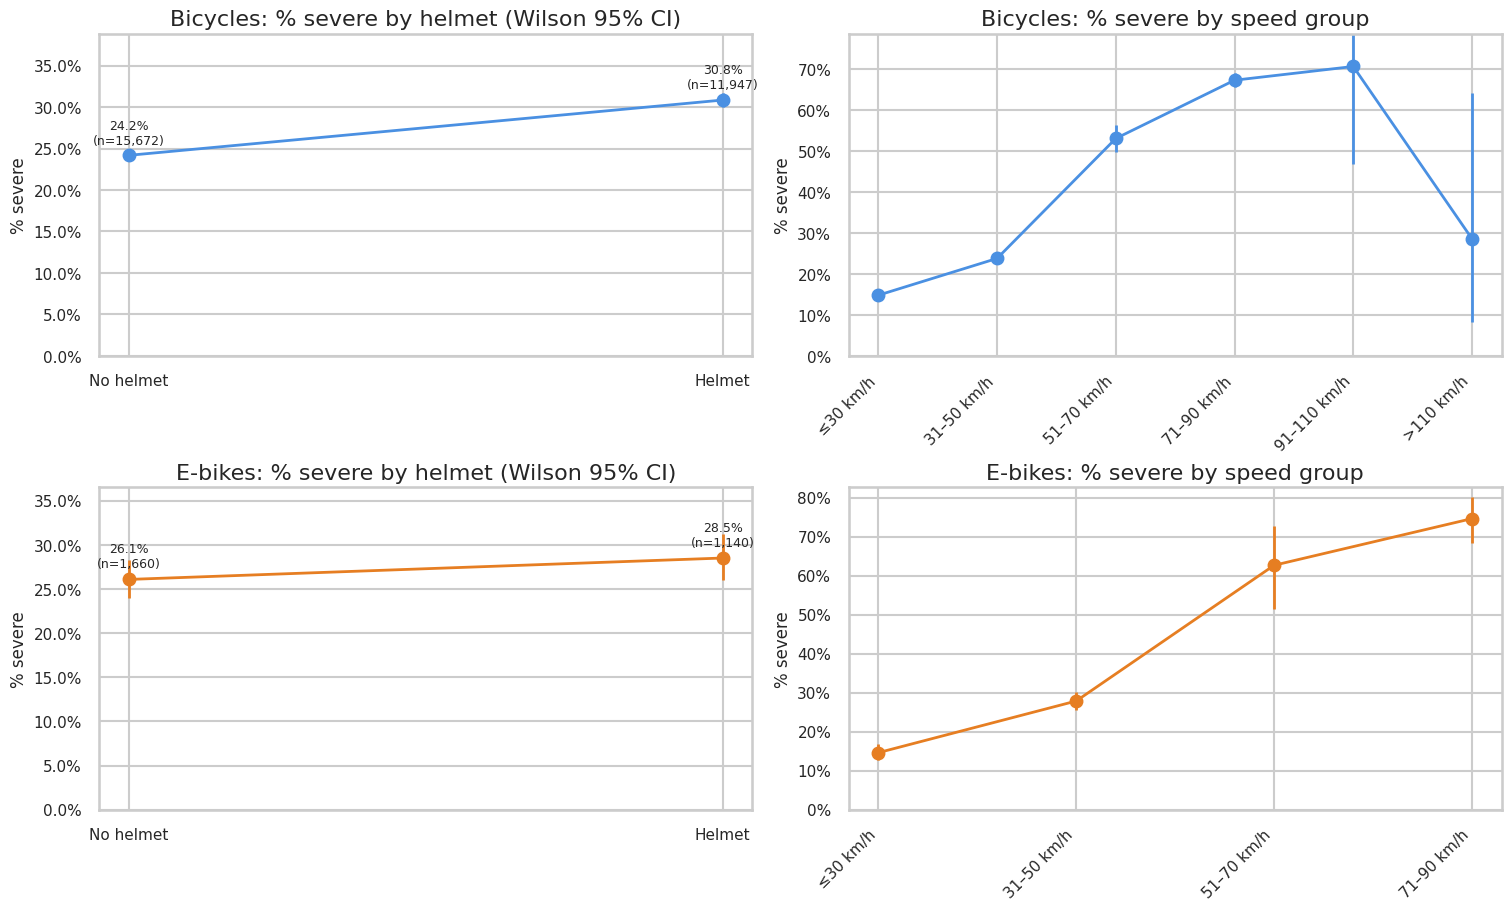

In [36]:

#from statsmodels.stats.proportion import proportion_confint, proportions_ztest
import statsmodels.formula.api as smf
import statsmodels.api as sm
#from scipy.stats import norm

# ---------- helpers ----------
def wilson_ci(k, n, alpha=0.05):
    if n == 0 or pd.isna(n) or pd.isna(k): return (np.nan, np.nan)
    lo, hi = proportion_confint(k, n, alpha=alpha, method="wilson")
    return float(lo), float(hi)

def two_prop_effects(k1, n1, k2, n2):
    # proportions
    p1, p2 = k1/n1, k2/n2
    # risk difference
    rd = p1 - p2
    # risk ratio & OR on log scale with Wald CIs
    # guardrails for zeros
    eps = 0.5
    rr = (k1 / n1) / (k2 / n2)
    se_log_rr = np.sqrt(1/max(k1,eps) - 1/max(n1,eps) + 1/max(k2,eps) - 1/max(n2,eps))
    or_ = (k1 * (n2 - k2)) / ((n1 - k1) * k2 + 1e-12)
    se_log_or = np.sqrt(1/max(k1,eps) + 1/max(k2,eps) + 1/max(n1-k1,eps) + 1/max(n2-k2,eps))
    z = norm.ppf(0.975)
    rr_ci = (np.exp(np.log(rr)-z*se_log_rr), np.exp(np.log(rr)+z*se_log_rr))
    or_ci = (np.exp(np.log(or_)-z*se_log_or), np.exp(np.log(or_)+z*se_log_or))
    # two-proportion z test for p-value (H0: p1 = p2)
    stat, pval = proportions_ztest([k1, k2], [n1, n2])
    return {
        "p1": p1, "p2": p2, "RD": rd,
        "RR": rr, "RR_CI": rr_ci,
        "OR": or_, "OR_CI": or_ci,
        "p_value": float(pval)
    }

# ---------- build flags ----------
df = data.copy()
df["helmet"] = (
    (df["safety_equipment1"] == 2) |
    (df["safety_equipment2"] == 2) |
    (df["safety_equipment3"] == 2)
)
df["severe"] = df["injury_severity"].isin([2, 3])
catv = pd.to_numeric(df["category_vehicle"], errors="coerce").astype("Int64")

def speed_group(limit):
    if pd.isna(limit): return "Unknown"
    elif limit <= 30:  return "≤30 km/h"
    elif limit <= 50:  return "31–50 km/h"
    elif limit <= 70:  return "51–70 km/h"
    elif limit <= 90:  return "71–90 km/h"
    elif limit <= 110: return "91–110 km/h"
    else:              return ">110 km/h"
df["speed_group"] = df["speed_limit"].apply(speed_group)

speed_order = ["≤30 km/h","31–50 km/h","51–70 km/h","71–90 km/h","91–110 km/h",">110 km/h"]
df["speed_group"] = pd.Categorical(df["speed_group"], categories=speed_order, ordered=True)

# ---------- A) HELMET: effect sizes for Bikes and E-bikes ----------
for veh_code, label in [(1, "Bicycle"), (80, "E-bike")]:
    sub = df[catv == veh_code]
    # counts: severe by helmet
    tab = pd.crosstab(sub["helmet"], sub["severe"]).reindex(index=[False, True], columns=[False, True], fill_value=0)
    n_no, k_no = int(tab.loc[False].sum()), int(tab.loc[False, True])
    n_yes, k_yes = int(tab.loc[True].sum()),  int(tab.loc[True,  True])

    eff = two_prop_effects(k_yes, n_yes, k_no, n_no)  # Helmet vs No-helmet
    print(f"\n{label}: Helmet vs No-helmet")
    print(f"  Severe %: helmet={eff['p1']*100:.1f}%, no-helmet={eff['p2']*100:.1f}%")
    print(f"  RD = {eff['RD']*100:.1f} pp,  RR = {eff['RR']:.2f} (95% CI {eff['RR_CI'][0]:.2f}–{eff['RR_CI'][1]:.2f}), "
          f"OR = {eff['OR']:.2f} (95% CI {eff['OR_CI'][0]:.2f}–{eff['OR_CI'][1]:.2f}), p = {eff['p_value']:.2e}")

# ---------- B) SPEED: trend test via logistic regression (ordinal, robust) ----------
speed_score = {g: i+1 for i, g in enumerate(speed_order)}  # 1..6

for veh_code, label in [(1, "Bicycle"), (80, "E-bike")]:
    sub = df[catv == veh_code].copy()
    # keep only known ordered groups
    sub = sub[sub["speed_group"].isin(speed_order)].copy()
    sub["speed_idx"] = sub["speed_group"].map(speed_score).astype(float)

    # sanity checks: need variation in predictor and outcome
    if sub["speed_idx"].nunique() < 2:
        print(f"\n{label}: cannot estimate trend — only one speed group present after filtering.")
        continue
    if sub["severe"].nunique() < 2:
        print(f"\n{label}: cannot estimate trend — outcome has a single level in this subset.")
        continue

    # (flip so “per-step increase” means faster)

    sub["speed_idx"] = (len(speed_order) + 1) - sub["speed_idx"]   # i.e., 7 - idx for 6 bins
    # fit GLM Binomial with robust SEs
    res = smf.glm("severe ~ speed_idx", data=sub, family=sm.families.Binomial()).fit(cov_type="HC3")

    # if the column was dropped, then skip
    if "speed_idx" not in res.params.index:
        print(f"\n{label}: model dropped speed_idx (collinearity) — trend not estimable.")
        continue

    or_step = np.exp(res.params["speed_idx"])
    ci_lo, ci_hi = np.exp(res.conf_int().loc["speed_idx"])
    pval = res.pvalues["speed_idx"]

    print(f"\n{label}: per-step increase in speed group")
    print(f"  OR per category = {or_step:.3f} (95% CI {ci_lo:.3f}–{ci_hi:.3f}), p = {pval:.2e}")

# ---------- D) Plots with Wilson CIs ----------
from matplotlib.ticker import PercentFormatter

def plot_pct_severe_by_helmet(sub, title, ax, color):
    tab = pd.crosstab(sub["helmet"], sub["severe"]).reindex([False, True], fill_value=0)
    n = tab.sum(axis=1).astype(int)
    k = tab[True].astype(int)
    p = (k / n).astype(float)
    cis = np.array([wilson_ci(int(ki), int(ni)) for ki, ni in zip(k, n)])
    yerr = np.vstack([p - cis[:,0], cis[:,1] - p])
    ax.errorbar(["No helmet","Helmet"], p.values, yerr=yerr, fmt="o-", linewidth=2, color=color)
    for xi, yi in enumerate(p.values):
        ax.text(xi, yi+0.01, f"{yi:.1%}\n(n={n.iloc[xi]:,})", ha="center", va="bottom", fontsize=9)
    ax.set_ylim(0, max(0.01, p.max()+0.08))
    ax.set_ylabel("% severe"); ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_title(title)

def plot_pct_severe_by_speed(sub, title, ax, color):
    tab = pd.crosstab(sub["speed_group"], sub["severe"]).reindex(speed_order, fill_value=0)
    n = tab.sum(axis=1).astype(int); k = tab[True].astype(int)
    p = (k / n.replace(0,np.nan)).astype(float)
    cis = np.array([wilson_ci(int(ki), int(ni)) if ni>0 else (np.nan,np.nan) for ki,ni in zip(k,n)])
    yerr = np.vstack([p - cis[:,0], cis[:,1] - p])
    ax.errorbar(speed_order, p.values, yerr=yerr, fmt="o-", linewidth=2, color=color)
    ax.set_xticklabels(speed_order, rotation=45, ha="right")
    ax.set_ylim(0, max(0.01, np.nanmax(p.values)+0.08))
    ax.set_ylabel("% severe"); ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    ax.set_title(title)

# Build 2×2 figure: Helmet and Speed for Bikes & E-bikes
fig, axes = plt.subplots(2, 2, figsize=(15, 9), constrained_layout=True)
plot_pct_severe_by_helmet(df[catv==1],  "Bicycles: % severe by helmet (Wilson 95% CI)", axes[0,0], "#4A90E2")
plot_pct_severe_by_speed (df[catv==1],  "Bicycles: % severe by speed group",         axes[0,1], "#4A90E2")
plot_pct_severe_by_helmet(df[catv==80], "E-bikes: % severe by helmet (Wilson 95% CI)",axes[1,0], "#E67E22")
plot_pct_severe_by_speed (df[catv==80], "E-bikes: % severe by speed group",           axes[1,1], "#E67E22")
plt.show()


#### What we tested

Helmet vs no-helmet within each group (bicycles and e-bikes):
we compared the share of crashes that were severe (killed or hospitalized). Instead of only asking “is it significant?” we reported how big the difference is (percentage-point gap, risk ratio, odds ratio) and a confidence interval.

Speed environment within each group:
we checked whether severity rises as the posted speed gets higher. We summarized the change per step up the speed scale (e.g., from 31–50 to 51–70 km/h).

Because the dataset is huge, significance tests will often be tiny; the focus here is on effect size and direction.

##### Results
Helmet vs no-helmet (unadjusted)

Bicycles: Severe outcomes were 30.8% with a helmet vs 24.2% without
→ +6.6 percentage points, about 28% higher risk.

E-bikes: 28.5% with a helmet vs 26.1% without
→ +2.4 percentage points, about 11% higher risk, not clearly different from zero (the CI includes “no difference”).

These are unadjusted comparisons. They do not mean helmets cause more severe crashes. The more likely explanation is where and how people ride: helmet wearers are over-represented in faster, riskier environments (longer trips, sport riding, higher-speed roads). To isolate the helmet effect, we also run adjusted models that include the road speed band, time, age, etc.

Speed environment (trend)

Bicycles: Each step up the speed scale multiplies the odds of a severe outcome by ~2.4×.

E-bikes: Each step up multiplies the odds by ~2.6×.

##### Takeaway: severity rises very sharply with speed environment for both bicycles and e-bikes.

##### What the graphs show

Top-left (Bicycles: % severe by helmet): the point for Helmet is higher than No helmet (≈31% vs 24%) with narrow error bars → a clear unadjusted difference.

Bottom-left (E-bikes: % severe by helmet): a smaller gap (≈29% vs 26%); the error bars overlap more → difference is uncertain.

Top-right (Bicycles: % severe by speed group): the line climbs steeply from ≤30 to 91–110 km/h, then dips at the very highest bin (likely fewer cases there—note the wider error bar).

Bottom-right (E-bikes: % severe by speed group): the same upward pattern—higher speed bands have much higher severity.

##### How to interpret this set of results

Speed environment is the big driver: moving up a posted-speed band roughly doubles to triples the odds of severe injury for both bicycles and e-bikes.

The helmet vs no-helmet gap in the raw data likely reflects who rides where, not an effect of the helmet itself. That’s why the adjusted analysis (controlling for speed band, year, hour, weekday, age, etc.) is the right way to discuss helmet association.

With very large data, emphasize effect sizes (percentage-point differences and ratios) and practical meaning, not just tiny p-values.

##### Summary

Severity increases strongly with posted speed for both bicycles and e-bikes (≈2.4–2.6× higher odds per speed category). Unadjusted helmet comparisons show higher severity among helmeted riders, which likely reflects riding in faster environments; adjusted models are needed to evaluate the helmet association independent of road context.

### 5. Speed Limit Analysis

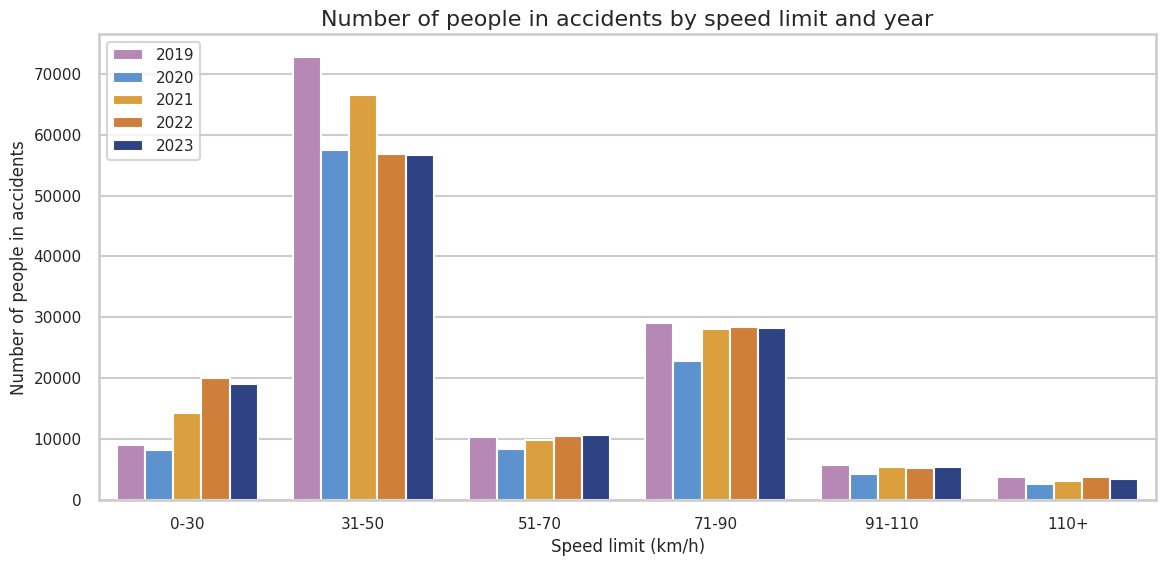

/tmp/ipython-input-437556140.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby(["speed_range", "year"])


year,2019,2020,2021,2022,2023
speed_range,,,,,
0-30,9097,8248,14311,20119,18992
31-50,72824,57409,66502,56860,56729
51-70,10431,8351,9935,10474,10745
71-90,29147,22860,28080,28416,28283
91-110,5723,4215,5392,5203,5501
110+,3754,2635,3158,3723,3430


In [37]:
# SPEED LIMIT & NUMBER OF PEOPLE IN ACCIDENTS BY YEAR

# Define a custom palette (greys, blues, and oranges)
custom_palette = [
    "#BC80BD",  # lavender
    "#4A90E2",  # medium blue
    "#F5A623",  # orange
    "#E67E22",  # dark orange
    "#1F3A93"   # dark navy blue for strong contrast
]

# Keep only values 0 – 999 as we know -1 is unspecified and is therefore not needed
data = data[data["speed_limit"].between(0, 999)]

# Create bins and labels
bins = [0, 30, 50, 70, 90, 110, float("inf")] # Most common speed limits in France: 30, 50, 80, 110, 130
labels = ["0-30", "31-50", "51-70", "71-90", "91-110", "110+"]

# Assign each accident to a bin
data["speed_range"] = pd.cut(data["speed_limit"], bins=bins, labels=labels, right=True)

# Graph using a countplot as we want to know how many per speed limit per year
plt.figure(figsize=(12,6))
sns.set_palette(custom_palette)
sns.countplot(
    x="speed_range",
    hue="year",
    data=data,
    order=labels,
    palette=custom_palette,
)

plt.title("Number of people in accidents by speed limit and year")
plt.xlabel("Speed limit (km/h)")
plt.ylabel("Number of people in accidents")
plt.legend(loc="upper left")
plt.show()

# Create a table for this information
table = (
    data.groupby(["speed_range", "year"])
    .size()
    .reset_index(name="Number_of_Accidents")
    .pivot(index="speed_range", columns="year", values="Number_of_Accidents")
    .fillna(0)
    .astype(int)
)

display(table)

##### Description

The bar chart and accompanying table show the number of accidents across different speed limit ranges (0–30, 31–50, 51–70, 71–90, 91–110, and 110+) from 2019 to 2023. Most accidents occur in the 71–90 km/h and 31–50 km/h ranges. The 0–30 km/h category shows a noticeable rise in 2023 compared to 2022, whereas accident counts at higher speed limits (91–110 and 110+) remain low and relatively stable over time.

##### Explanation

The speed limit range of 31-50 km/h being so dominant could possibly be due to the prevalence of departmental and urban roads in France where these limits apply. The lower counts between 51–70 km/h may correspond to semi-rural roads with lower volumes of vehicles, while the decrease for 91–110 km/h and 110+ km/h could be due to limited access motorways and expressways, where traffic tends to be more regulated and flows more smoothly. We have for 2020 the expected dip due to the COVID-19 lockdowns, while the rebound in 2021–2023 is consistent with traffic volumes normalizing.

##### Interpretation
Most accidents occur on roads with limits between 31 and 70 km/h, rather than on higher-speed roads. This indicates that road safety measures should focus more on urban and peri-urban areas, where these limits are common. The rise in 2023 in lower-speed zones, signals renewed mobility and possibly increased congestion, reinforcing the need for targeted safety efforts as travel patterns return to pre-pandemic levels.

/tmp/ipython-input-1820932914.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_spl_inj.groupby(["year", "speed_range", "injury_severity"])


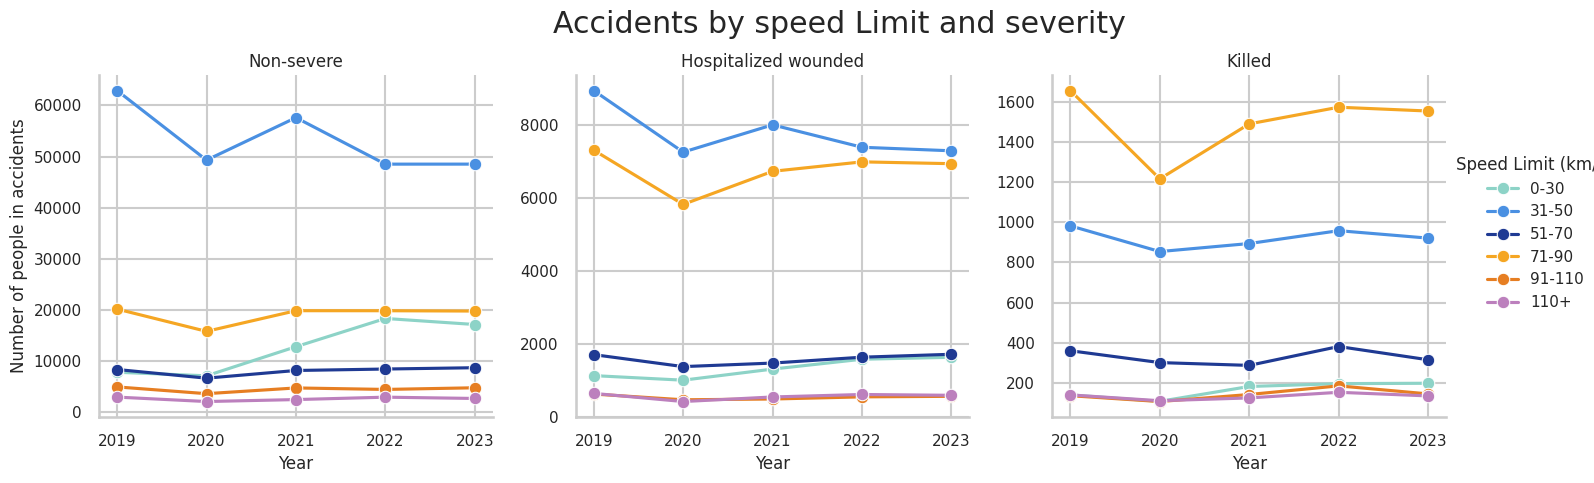

 Killed


year,2019,2020,2021,2022,2023
speed_range,,,,,
0-30,140,108,182,196,198
31-50,982,854,894,958,921
51-70,360,301,287,381,315
71-90,1656,1216,1490,1573,1554
91-110,136,107,142,185,145
110+,140,111,125,153,135



 Hospitalized


year,2019,2020,2021,2022,2023
speed_range,,,,,
0-30,1130,1005,1309,1579,1633
31-50,8941,7254,8001,7387,7290
51-70,1705,1377,1474,1635,1715
71-90,7308,5821,6728,6987,6937
91-110,625,468,489,548,563
110+,643,420,545,613,591



 Non-severe


year,2019,2020,2021,2022,2023
speed_range,,,,,
0-30,7827,7135,12820,18344,17161
31-50,62901,49301,57607,48515,48518
51-70,8366,6673,8174,8458,8715
71-90,20183,15823,19862,19856,19792
91-110,4962,3640,4761,4470,4793
110+,2971,2104,2488,2957,2704


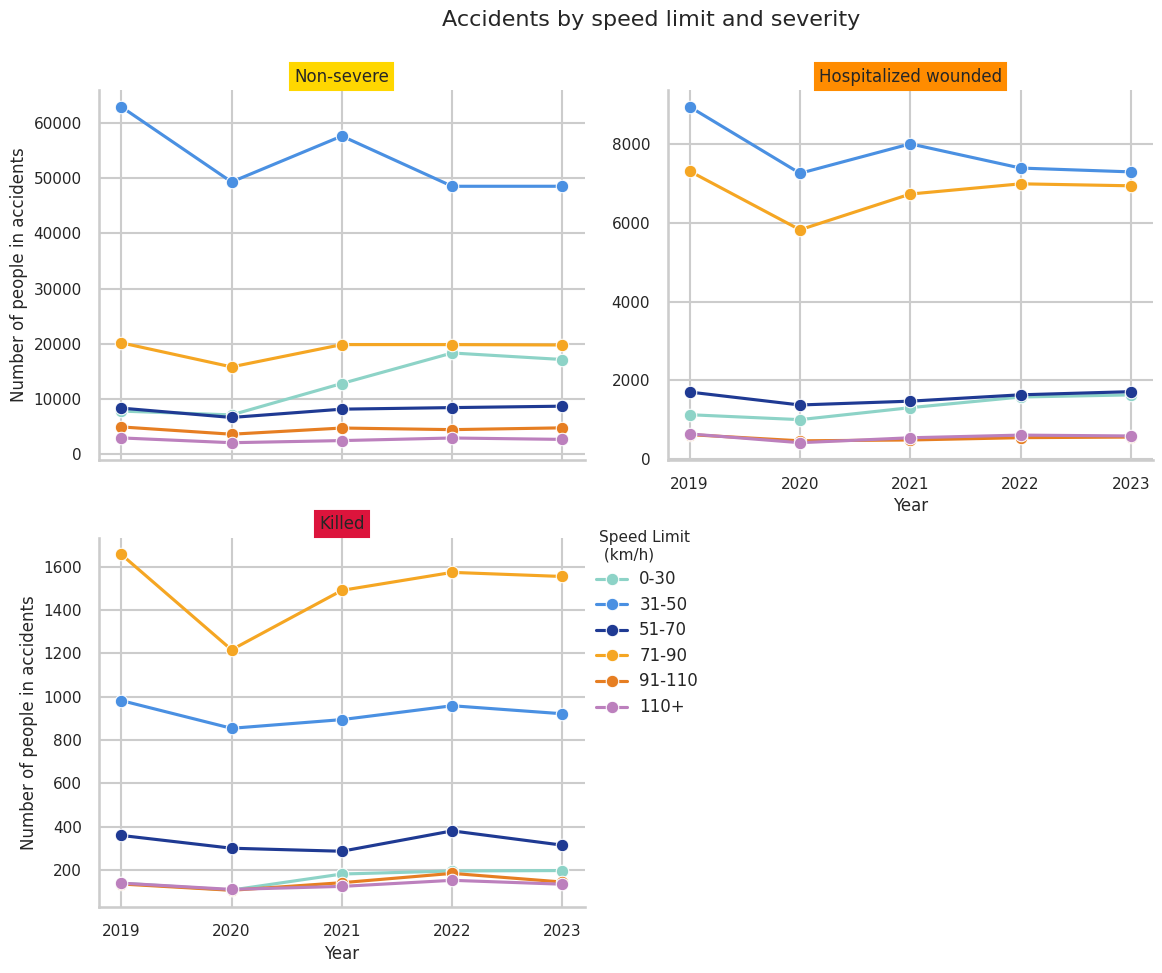

In [38]:
# SPEED LIMIT, YEAR, & INJURY SEVERITY

# Make a copy of our dataframe just in case
df_spl_inj = data.copy()

# Convert to string to avoid mixing int & str
df_spl_inj["injury_severity"] = df_spl_inj["injury_severity"].astype(str)

# Replace values to merge categories
df_spl_inj["injury_severity"] = df_spl_inj["injury_severity"].replace({
    "-1": "Non-severe", # As previously done (-1, 1, & 4 are combined to form Non-severe)
    "1": "Non-severe",
    "4": "Non-severe",
    "2": "Killed",
    "3": "Hospitalized wounded"
})

# Group our data by year + speed_range(speed limit) + injury_severity
df_spl_inj = (
    df_spl_inj.groupby(["year", "speed_range", "injury_severity"])
    .size()
    .reset_index(name="count")
)

# We want our graph to start with Non-severe, followed by hospitalized, then killed for easier analysis
severity_order = ["Non-severe", "Hospitalized wounded", "Killed"]

custom_palette = [
    "#8DD3C7",  # light turquoise
    "#4A90E2",  # medium blue
    "#1F3A93",  # dark navy blue
    "#F5A623",  # orange
    "#E67E22",  # dark orange
    "#BC80BD"   # lavender
]

# Plot with FacetGrid
g = sns.FacetGrid(
    df_spl_inj,
    col="injury_severity",
    hue="speed_range",
    col_order=severity_order,   # Use our subplot order created
    col_wrap=3, # side by side and not standing over one another
    height=5,
    sharey=False,
    palette=custom_palette
)

g.map_dataframe(sns.lineplot, x="year", y="count", marker="o")

g.add_legend(title="Speed Limit (km/h)")
leg = g._legend
leg.get_title().set_fontsize(12)
leg.set_bbox_to_anchor((0.93, 0.5))  # closer (reduce x from 1 → 0.9)


g.set_axis_labels("Year", "Number of people in accidents")
g.set_titles("{col_name}")

plt.subplots_adjust(top=0.85)
g.fig.suptitle("Accidents by speed Limit and severity")
plt.show()


# Make three tables (Non-severe, Hospitalized, and Killed) to see the actual numbers for each

# Killed Table
table_killed = (
    df_spl_inj[df_spl_inj["injury_severity"] == "Killed"]
    .pivot(index="speed_range", columns="year", values="count")
)

# Hospitalized Table
table_hosp = (
    df_spl_inj[df_spl_inj["injury_severity"] == "Hospitalized wounded"]
    .pivot(index="speed_range", columns="year", values="count")
)

# Non-severe Table
table_minor = (
    df_spl_inj[df_spl_inj["injury_severity"] == "Non-severe"]
    .pivot(index="speed_range", columns="year", values="count")
)

print(" Killed")
display(table_killed)

print("\n Hospitalized")
display(table_hosp)

print("\n Non-severe")
display(table_minor)

# Plot with FacetGrid
g = sns.FacetGrid(
    df_spl_inj,
    col="injury_severity",
    hue="speed_range",
    col_order=severity_order,
    col_wrap=2,
    height=5,
    aspect=1.2,
    sharey=False,
    palette=custom_palette
)

g.map_dataframe(sns.lineplot, x="year", y="count", marker="o")

# Add legend and adjust position and fontsize
g.add_legend(title="Speed Limit \n (km/h)")
leg = g._legend
leg.set_bbox_to_anchor((0.52, 0.35))  # move to the right of the top-right subplot
leg.get_title().set_fontsize(11)

# Adjust font size for legend labels
for text in leg.texts:
    text.set_fontsize(12)

g.set_axis_labels("Year", "Number of people in accidents")
for ax in g.axes.flatten():
    ax.set_xticks(sorted(df_spl_inj["year"].unique()))
    ax.set_xticklabels(sorted(df_spl_inj["year"].unique(), reverse=False))

# Title background colors
title_colors = {
    "Non-severe": "#FFD700",
    "Hospitalized wounded": "darkorange",
    "Killed": "crimson"
}

for ax, severity in zip(g.axes.flatten(), severity_order):
    ax.set_title(severity, backgroundcolor=title_colors[severity], fontsize=12)

plt.subplots_adjust(top=0.90)
g.fig.suptitle("Accidents by speed limit and severity", fontsize = 16)
plt.show()


/tmp/ipython-input-1201053130.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  table_spl_inj = df_spl_inj.groupby(["speed_range", "injury_severity"])["count"].sum().unstack(fill_value=0)


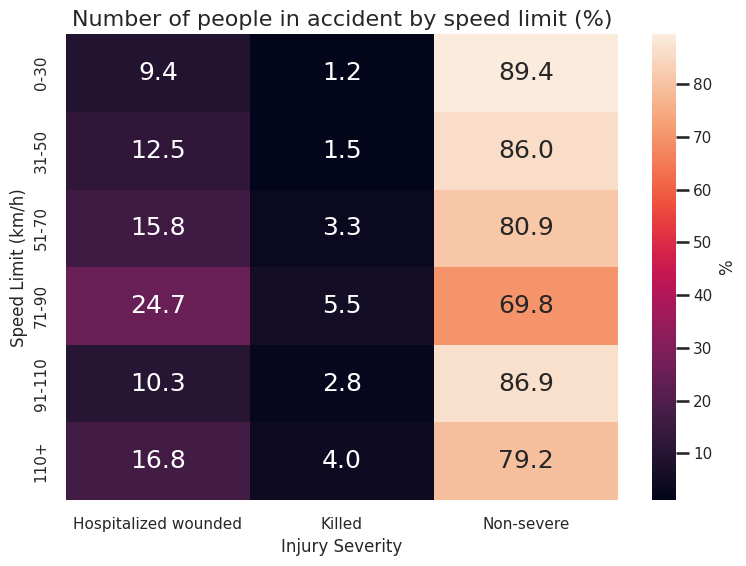

In [39]:
# SPEED LIMIT, YEAR, & INJURY SEVERITY **PERCENTAGE**

# Group data by speed range(speed limit) and injury severity and count the number of people by column
table_spl_inj = df_spl_inj.groupby(["speed_range", "injury_severity"])["count"].sum().unstack(fill_value=0)

# Sum the columns across and divide each row total to gain our percentage, rounding to the two decimal
table_spl_inj_pct = (table_spl_inj.div(table_spl_inj.sum(axis=1), axis=0) * 100).round(2)

# Use a Heatmap to represent our percentages for each injury severity
plt.figure(figsize=(8,6))
sns.heatmap(table_spl_inj_pct, annot=True, fmt=".1f", cbar_kws={'label': '%'})
plt.title("Number of people in accident by speed limit (%)")
plt.ylabel("Speed Limit (km/h)")
plt.xlabel("Injury Severity")
plt.show()

##### Description

The line charts and tables display accident outcomes by injury severity (Non-severe, hospitalized wounded, and killed), broken down by speed range and year. Accident counts are highest at 31-50 km/h across most categories, with the exception of killed, which peak at 71–90 km/h. A clear dip as expected is observed in 2020 across all severities, followed by increases in 2021–2023.

##### Explanation

Non-severe: This group represents the majority of outcomes in every speed range, particularly at 0-30 km/h.

Hospitalized wounded: Accidents in the 110+ km/h and 71–90 km/h speed limit ranges dominate, this could be due to both high traffic exposure and more severe collisions.

Killed: The 71–90 km/h range shows the highest share. While only 69.8% of accidents in this range result in minor injuries, 24.7% lead to hospitalization and 5.5% to death. By contrast, at 31–50 km/h, almost 90% are minor, with just 1.5% killed.

##### Interpretation
Most accidents occur in moderate-speed environments (31–50 km/h), accidents are far more severe on roads limited to 71–90 km/h. Higher-speed roads (91–110+ km/h) also show higher killed rates (around 3.4%), but still lower than 71–90 km/h. Interestingly, even very low speeds (0–30 km/h) produce some fatalities, The possibility of this being linked to collisions with vulnerable road users (e.g. Bicycles). The overall stability of these patterns across years (except for the 2020 dip) suggests a persistent relationship between speed environment and injury severity.

##### Next step

We will perform a chi-square test to evaluate whether the distribution of injury severity is statistically dependent on speed range. This will confirm whether the observed differences (e.g. High fatalities for 71–90 km/h) are significant and not due to chance.

Speed Limit & Injury Severity Contingency Table:


/tmp/ipython-input-1452403987.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["speed_range", "injury_severity"])["count"]


injury_severity,Non-severe,Hospitalized wounded,Killed
speed_range,,,
0-30,63287,6656,824
31-50,266842,38873,4609
51-70,40386,7906,1644
71-90,95516,33781,7489
91-110,22626,2693,715
110+,13224,2812,664


Chi-Squared Statistic: 21811.005134938227
p-value: 0.0000

 
 Standardized Residuals:


injury_severity,Non-severe,Hospitalized wounded,Killed
speed_range,,,
0-30,21.21,-39.46,-23.82
31-50,23.26,-38.02,-38.83
51-70,-3.27,3.70,9.41
71-90,-50.47,90.25,65.53
91-110,8.38,-20.05,1.35
110+,-4.30,5.48,10.91


Observed                               Expected  \
injury_severity Non-severe Hospitalized wounded Killed Non-severe   
speed_range                                                         
0-30                 63287                 6656    824    58171.8   
31-50               266842                38873   4609   255092.1   
51-70                40386                 7906   1644    41048.3   
71-90                95516                33781   7489   112440.6   
91-110               22626                 2693    715    21400.4   
110+                 13224                 2812    664    13727.7   

                                              Residuals                       \
injury_severity Hospitalized wounded  Killed Non-severe Hospitalized wounded   
speed_range                                                                    
0-30                         10747.1  1848.1      21.21               -39.46   
31-50                        47127.5  8104.4      23.26               -38.02   
51-70                         7583.6  1304.1      -3.27                 3.70   
71-90                        20773.1  3572.3     -50.47                90.25   
91-110                        3953.7   679.9       8.38               -20.05   
110+                          2536.2   436.1      -4.30                 5.48   

                        
injury_severity Killed  
speed_range             
0-30            -23.82  
31-50           -38.83  
51-70             9.41  
71-90            65.53  
91-110            1.35  
110+             10.91

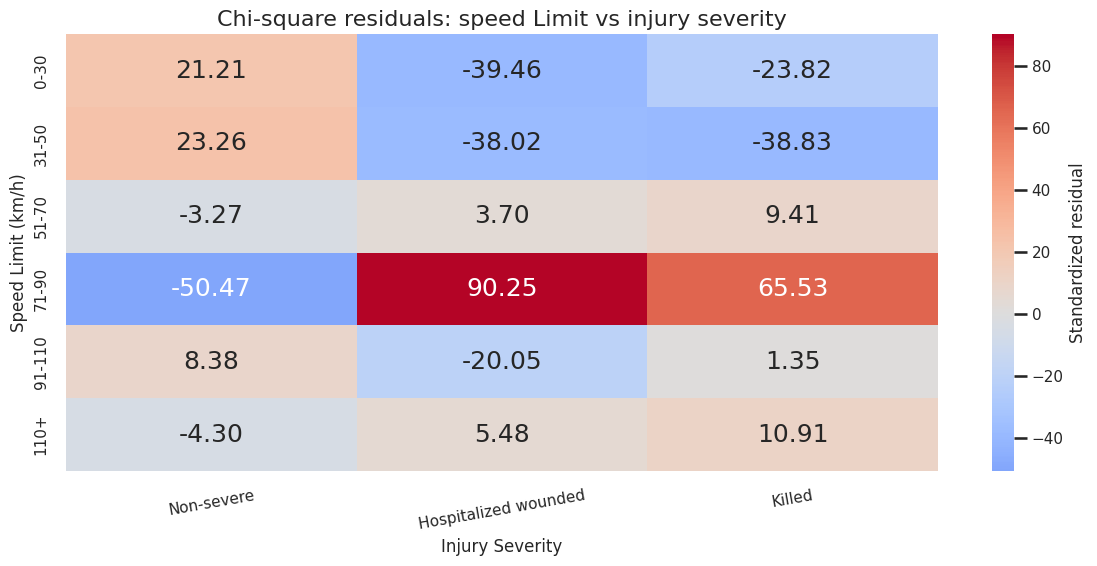

In [40]:
# CHI-SQUARE INDEPENDENT TEST

# First we make a contingency table: rows = speed ranges (speed limit), cols = injury severity
ct = (
    df_spl_inj
    .groupby(["speed_range", "injury_severity"])["count"]
    .sum()
    .unstack(fill_value=0)
    .astype(int)
)

# Reorder columns (for better analysis)
severity_order = ["Non-severe", "Hospitalized wounded", "Killed"]
ct = ct[severity_order]

print("Speed Limit & Injury Severity Contingency Table:")
display(ct) # <---- Our contingency table for speed limit and injury severity

# Perform a chi-square (independent test) using our contingency table
resultat_chi2 = chi2_contingency(ct)

statistic = resultat_chi2[0] # 0 for test statistic
p_value = resultat_chi2[1] # 1 for p-value
expected = resultat_chi2[3] # 3 for expected frequencies

print("Chi-Squared Statistic:", statistic)
print(f"p-value: {p_value:.4f}")

# As our p-value is below 0.05 we accept that injury severity is not independent of speed limit
# As our Chi-Squared statistic is relatively large it offers strong evidence of dependence between the two values.
# We want to see the difference between our observed counts and expected counts to further interpret this data and see where our links are

# Convert expected values to DataFrame
expected_df = pd.DataFrame(expected, index=ct.index, columns=ct.columns)

# Standardized residuals
std_resid = (ct - expected_df) / np.sqrt(expected_df)

print("\n \n Standardized Residuals:")
display(std_resid.round(2))


comparison = pd.concat(
    {
        "Observed": ct,
        "Expected": expected_df.round(1),
        "Residuals": std_resid.round(2)
    },
    axis=1
)

display(comparison)

# Display our Standardized Residuals on a Heatmap for easier analysis
plt.figure(figsize=(12,6))
sns.heatmap(std_resid, annot=True, fmt=".2f", center=0,
            cmap="coolwarm", cbar_kws={'label': 'Standardized residual'})
plt.title("Chi-square residuals: speed Limit vs injury severity")
plt.ylabel("Speed Limit (km/h)")
plt.xlabel("Injury Severity")
plt.xticks(rotation=10)
plt.show()

#### Conclusion: Speed Limit vs Injury Severity

##### Chi-Squared Test Result

Chi-squared statistic: 21811.005
p-value: < 0.0001

Interpretation: The p-value is far below 0.05, meaning the distribution of injury severity is not independent of speed limit. Speed limit of a road has a significant effect on accident severity.

#### Standardized Residuals by Speed Range

Positive residual: More cases observed than expected.

Negative residual: Fewer cases observed than expected.

0–30 km/h:
Strongly under-represented for severe outcomes (Hospitalized: -39.46, Killed: -23.82), and over-represented for Non-severe (+21.21) — meaning accidents in this range are far less severe than expected.

31–50 km/h:
Similar trend with Non-severe (+23.26) dominating and Hospitalized (-38.02), Killed (-38.83) much lower than expected. This reflects mostly minor, urban crashes.

51–70 km/h:
Residuals close to zero overall, indicating results roughly align with expectations. Slightly more Killed (+9.41) and Hospitalized (+3.7) than expected.

71–90 km/h:
The most extreme deviations: far fewer Non-severe (-50.47) but drastically more Hospitalized (+90.25) and Killed (+65.53) than expected.
This speed range clearly concentrates the most dangerous accidents.

91–110 km/h:
Slightly fewer Hospitalized (-20.05) but near-expected Killed (+1.35) — suggesting somewhat safer conditions than 71–90 km/h, likely due to better infrastructure.

110+ km/h:
Slight over-representation of Severe outcomes (Killed: +10.91, Hospitalized: +5.48), but still far below the extreme levels of 71–90 km/h.

##### Key Findings

71–90 km/h: Clearly the “danger zone,” with far more severe outcomes (hospitalizations and killed) than expected.

31–70 km/h: Accidents are frequent but disproportionately less severe, with higher shares of Non-severe or slightly injured.

High-speed roads (91–110, 110+): Slightly more Killed than expected, but fewer hospitalizations, and not as extreme as 71–90 km/h.

Low-speed areas (0–30 km/h) → Overwhelmingly non-severe, consistent with lower impact speeds and more pedestrian environments.


##### Conclusion

Accident severity is significantly associated with speed range. Roads with limits of 71–90 km/h stand out as especially hazardous, producing a high number of hospitalizations and fatalities compared to expectations.

In contrast, 31–70 km/h environments, while accounting for the majority of accidents, result in fewer severe outcomes than expected.

These results highlight the need for targeted safety interventions on secondary roads in the 71–90 km/h range, such as stricter enforcement, infrastructure improvements, or reconsideration of speed limits.

#### Additional analysis for speed limits

Why, because chi-square will be “significant” with the dataset no matter what. A better alternative here is a trend/effect-size model that tells you how much severity changes with speed, not just that it differs.

Binomial GLM (Severe ~ speed step)
Per-step odds ratio = 1.307 (95% CI 1.306–1.308), p = 0.00e+00


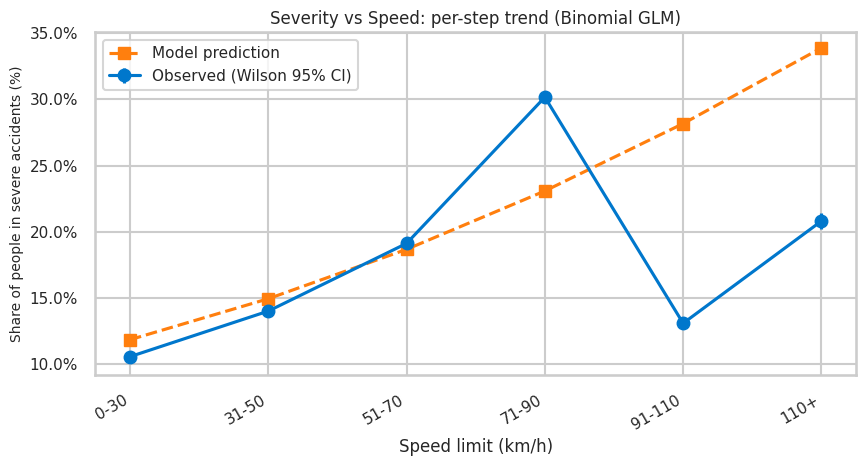

  speed_range      pred  pred_pct
0        0-30  0.118518     11.85
1       31-50  0.149458     14.95
2       51-70  0.186763     18.68
3       71-90  0.230853     23.09
4      91-110  0.281745     28.17
5        110+  0.338912     33.89
Brier score: 0.00263
McFadden pseudo-R²: 0.541


In [43]:

#import statsmodels.formula.api as smf
#import statsmodels.api as sm
#from statsmodels.stats.proportion import proportion_confint
#from matplotlib.ticker import PercentFormatter

# --- Build severe vs total from ct ---
# ct: rows = speed_range, cols = ["Non-severe","Hospitalized wounded","Killed"]
agg = pd.DataFrame({
    "Severe": ct["Hospitalized wounded"] + ct["Killed"],
    "Total":  ct.sum(axis=1)
})
agg["p_severe"] = agg["Severe"] / agg["Total"]

# Keep speed order
speed_order = list(ct.index)
agg = agg.reset_index().rename(columns={"index":"speed_range"})
agg["speed_range"] = pd.Categorical(agg["speed_range"], categories=speed_order, ordered=True)
agg["speed_idx"]   = agg["speed_range"].cat.codes + 1   # 1,2,3,...

# --- Binomial GLM with frequency weights + robust SEs ---
m = smf.glm("p_severe ~ speed_idx",
            data=agg,
            family=sm.families.Binomial(),
            freq_weights=agg["Total"]).fit(cov_type="HC3")

or_step  = np.exp(m.params["speed_idx"])
ci_low, ci_high = np.exp(m.conf_int().loc["speed_idx"])

print("Binomial GLM (Severe ~ speed step)")
print(f"Per-step odds ratio = {or_step:.3f} (95% CI {ci_low:.3f}–{ci_high:.3f}), p = {m.pvalues['speed_idx']:.2e}")

# --- Predicted probabilities by speed band ---
agg["pred"] = m.predict(agg)

# Wilson 95% CI for the observed proportions (nice for the plot)
def wilson_ci(k, n, alpha=0.05):
    lo, hi = proportion_confint(k, n, alpha=alpha, method="wilson")
    return lo, hi

cis = np.array([wilson_ci(k, n) for k, n in agg[["Severe","Total"]].to_numpy()])
yerr = np.vstack([agg["p_severe"].to_numpy() - cis[:,0], cis[:,1] - agg["p_severe"].to_numpy()])

# --- Plot observed % severe (+ CIs) and model predictions ---
fig, ax = plt.subplots(figsize=(9,5))
ax.errorbar(agg["speed_range"].astype(str), agg["p_severe"], yerr=yerr, fmt="o-", color="#0077CC", label="Observed (Wilson 95% CI)")
ax.plot(agg["speed_range"].astype(str), agg["pred"], "s--",  color="#FF7F0E", label="Model prediction")
ax.set_ylabel("Share of people in severe accidents (%)", fontsize = 10); ax.yaxis.set_major_formatter(PercentFormatter(1.0))
ax.set_xlabel("Speed limit (km/h)")
ax.set_title("Severity vs Speed: per-step trend (Binomial GLM)", fontsize = 12)
ax.legend()
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

print(agg[["speed_range", "pred"]].assign(pred_pct = (agg["pred"] * 100).round(2)))

# Calculate the Brier Score
brier = np.average((agg["p_severe"] - m.predict(agg))**2, weights=agg["Total"])
print(f"Brier score: {brier:.5f}")

# Calculate the pseudo R squared
pseudo_r2 = 1 - m.deviance / m.null_deviance
print(f"McFadden pseudo-R²: {pseudo_r2:.3f}")



#### Cramer's V for the Chi-square test

In [42]:


chi2, p, dof, exp = sm.stats.Table(ct.values).test_nominal_association().statistic, None, None, None  # or use scipy chi2_contingency(ct)
N = ct.values.sum()
r, c = ct.shape
phi2 = chi2 / N
phi2corr = max(0, phi2 - ((c-1)*(r-1))/(N-1))
rcorr = r - ((r-1)**2)/(N-1)
ccorr = c - ((c-1)**2)/(N-1)
cramers_v_bc = np.sqrt(phi2corr / max(1e-12, min(rcorr-1, ccorr-1)))
print(f"Cramér’s V (bias-corrected) = {cramers_v_bc:.3f}")


Cramér’s V (bias-corrected) = 0.134


##### Association strength (Cramér’s V)

Cramér’s V (bias-corrected) = 0.134.
This is an effect size for the whole speed-band × severity table. Values run 0–1; ~0.10 is small, ~0.30 moderate.
Interpretation: There is a small-to-moderate association between speed limit band and injury severity—i.e., the mix of “Non-severe / hospitalized / killed” changes meaningfully with speed, not just trivially (and this is independent of the huge sample size).

##### Trend model (Binomial GLM)

Model: Severe (hospitalized+killed) ~ speed-band step, fit as a Binomial GLM with frequency weights (one parameter summarizing the ordered trend).

Per-step odds ratio = 1.307 (95% CI 1.306–1.308).
Each move up one speed band multiplies the odds of a severe outcome by about +31%.
Across five steps (0–30 → 110+), the cumulative change is about 1.307⁵ ≈ 4.0x higher odds.

The tiny p-value reflects the huge sample size; focus on the OR and CI.

##### What the plot shows

Orange Dashed line (model prediction): a smooth, monotonic increase in the predicted % severe from ~11% in 0–30 km/h up to ~34% in 110+ km/h.

Blue line (observed with Wilson 95% CIs): the general rise is visible, but there are shape deviations the one-parameter trend can’t capture:

- a sharp spike at 71–90 km/h (much higher than trend),

- a drop at 91–110 km/h

- a small uptick at 110+ km/h.

These bumps are plausible: 71–90 km/h often corresponds to undivided rural roads (high impact speeds but less protective road design), while 91–110 km/h can be motorways (higher speeds but divided carriageways, better design, emergency access), yielding lower severity than the trend would predict.

##### Summary

There is a small-to-moderate association between speed environment and accident severity (Cramér’s V = 0.134).
The binomial model shows that each increase in speed category multiplies the odds of severe injury by ≈ 31% (95% CI 1.306–1.308), meaning crashes at 110+ km/h have roughly four times higher odds of severe outcomes than those below 30 km/h.

Observed data confirm the rising pattern but highlight a sharp peak at 71–90 km/h — consistent with rural undivided roads where speeds are high but safety infrastructure is limited.
This divergence underlines how road type and design moderate the effect of speed, making mid-high speed environments particularly critical for prevention efforts.

##### Bottom line
Speed environment is a strong driver of severity (large, monotone effect), and the deviations hint at road-type differences worth exploring.